# Hardware setup

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

In [2]:
import os

if 'COLAB_TPU_ADDR' not in os.environ:
  print('Not connected to TPU')
else:
  print("Connected to TPU")


Not connected to TPU


In [3]:
!nvidia-smi

Tue May 17 08:04:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W /  70W |    264MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Library setup

In [4]:
# Install required packages
#RESTART NEEDED FOR PANDAS
!pip install --upgrade arabic-reshaper
!pip install python-bidi
!pip install pandas
#for xlsx file
#!pip install pandas==1.0.3
!pip install -q transformers
!pip install -q hazm
!pip install -q clean-text[gpl]

     |████████████████████████████████| 4.2 MB 9.5 MB/s 
     |████████████████████████████████| 6.6 MB 37.5 MB/s 
     |████████████████████████████████| 596 kB 48.7 MB/s 
     |████████████████████████████████| 84 kB 2.3 MB/s 
     |████████████████████████████████| 316 kB 13.7 MB/s 
     |████████████████████████████████| 233 kB 26.8 MB/s 
     |████████████████████████████████| 1.4 MB 48.5 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 175 kB 59.8 MB/s 
     |████████████████████████████████| 235 kB 49.4 MB/s 


In [5]:
# Import required packages

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hazm
import nltk
nltk.download('punkt')
import plotly.graph_objects as go
from plotly.offline import iplot, plot, download_plotlyjs, init_notebook_mode
import os
import re
import json
import copy
import collections
import gensim
import pickle

from statistics import variance
from statistics import mean
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score, multilabel_confusion_matrix
from sklearn.utils import shuffle
from cleantext import clean
from tqdm.notebook import tqdm
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from keras.layers import *
from __future__ import print_function
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import Dense, Input, Flatten, Dropout, merge, Activation, Embedding, Conv1D, GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D, LSTM, Bidirectional
from keras.models import Model, Sequential,load_model
from tensorflow.keras.optimizers import Adadelta, RMSprop

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Reading the Dataset

### params

In [ ]:
datasetname='persian_news'
cutq=0
coulmn1=1
coulmn2=3
sep="\t"
format=0

### code

In [ ]:
#dataset information array
# information=[]

dir="/content/drive/MyDrive/payannameF/dataset/"
halfinfodir="/content/drive/MyDrive/payannameF/dataset/processed/"
infodir=halfinfodir+"info"+datasetname+".pickle"

# information.append(["mode",3])
# information.append(["cutq",cutq])

datasetmain=dir+datasetname
trainFilePath=datasetmain+"/train.csv" 
validFilePath=datasetmain+"/dev.csv"
testFilePath=datasetmain+"/test.csv" 

In [ ]:
data = pd.read_csv(trainFilePath,sep=sep, encoding='utf-8')
data2 = pd.read_csv(validFilePath,sep=sep, encoding='utf-8')
data3 = pd.read_csv(testFilePath,sep=sep, encoding='utf-8')

data = data[list(data.columns)[coulmn1:coulmn2]]
data.rename(columns = {'content':'news'}, inplace = True)
data2 = data2[list(data2.columns)[coulmn1:coulmn2]]
data2.rename(columns = {'content':'news'}, inplace = True)
data3 = data3[list(data3.columns)[coulmn1:coulmn2]]
data3.rename(columns = {'content':'news'}, inplace = True)

print(data.shape)
print(data2.shape)
print(data3.shape)
data = pd.concat([data,data3,data3])

(13314, 2)
(1480, 2)
(1644, 2)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data.index = range(data.shape[0])
cc=data['news'].apply(lambda x: len(str(x).split(' '))).sum()
# information.append(["train prepreprocess prox word count",cc])
print(cc)

6452376


In [ ]:
data.head()

news        label
0  به گزارش خبرنگار حوزه بهداشت و درمان گروه علمی...        پزشکی
1  به گزارش خبرنگار فوتبال و فوتسال گروه ورزشی با...        ورزشی
2  بهروز اکرمی، در گفتگو با خبرنگار اجتماعی باشگا...      اجتماعی
3  به گزارش خبرنگار حوزه شهری گروه اجتماعی باشگاه...      اجتماعی
4  به گزارش باشگاه خبرنگاران و به نقل از روابط عم...  فرهنگی هنری

In [ ]:
data.shape

(16602, 2)

# Preprocessing

## Missing values

In [ ]:
# print data information
print('data information')
print(data.info(), '\n')

# print missing values information
print('missing values stats')
print(data.isnull().sum(), '\n')

# print some missing values
print('some missing values')
print(data[data['label'].isnull()].iloc[:5], '\n')

# information.append(["train missing content",data.isnull().sum()["news"]])
# information.append(["train missing label",data.isnull().sum()["label"]])

data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168752 entries, 0 to 168751
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   news    168525 non-null  object
 1   label   168752 non-null  object
dtypes: object(2)
memory usage: 2.6+ MB
None 

missing values stats
news     227
label      0
dtype: int64 

some missing values
Empty DataFrame
Columns: [news, label]
Index: [] 



In [ ]:
# handle some conflicts with the dataset structure
# you can find a reliable solution, for the sake of the simplicity
# I just remove these bad combinations!
data = data.dropna(subset=['label'])
data = data.dropna(subset=['news'])
data = data.drop_duplicates(subset=['news'], keep='first')
data = data.reset_index(drop=True)

# previous information after solving the conflicts
# print data information
print('data information')
print(data.info(), '\n')

# print missing values information
print('missing values stats')
print(data.isnull().sum(), '\n')

# print some missing values
print('some missing values')
print(data[data['label'].isnull()].iloc[:5], '\n')

data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134059 entries, 0 to 134058
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   news    134059 non-null  object
 1   label   134059 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB
None 

missing values stats
news     0
label    0
dtype: int64 

some missing values
Empty DataFrame
Columns: [news, label]
Index: [] 



## Cleaning the Dataset

### regular cleaning

In [ ]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()
    
    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=False,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url=" ",
        replace_with_email=" ",
        replace_with_phone_number=" ",
        replace_with_number=" ",
        replace_with_digit=" ",
        replace_with_currency_symbol=" ",
    )
    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)
    # cleaning htmls
    #text = cleanhtml(text)

    text = re.sub(
        '[^ \u0622\u0627\u0628\u067E\u062A-\u062C\u0686\u062D-\u0632\u0698\u0633'
        '-\u063A\u0641\u0642\u06A9\u06AF\u0644-\u0648\u06CC\u200c]',
        "", text)
    
    # removing extra spaces
    text = re.sub("\s+", " ", text)

    text = bytes(text, 'utf-8').decode('utf-8', 'ignore')

    return text

In [ ]:
# cleaning news
data['cleaned_news'] = data['news'].apply(cleaning)

### advanced cleaning

In [ ]:
stop_words=["ه","اند","م","ید","د","ند","تری","ترین","تر","ایی","ای","یی","ی","هایی","برمی","های","ها"]
with open('/content/stopwords.txt') as f:
    lines = f.read().splitlines()
    for line in lines:
      line = re.sub("\t", "", line)
      stop_words.append(line)

print(stop_words)

['ه', 'اند', 'م', 'ید', 'د', 'ند', 'تری', 'ترین', 'تر', 'ایی', 'ای', 'یی', 'ی', 'هایی', 'برمی', 'های', 'ها', 'و', 'در', 'به', 'از', 'که', 'می', 'این', 'است', 'را', 'با', 'های', 'برای', 'آن', 'یک', 'شود', 'شده', 'خود', 'ها', 'کرد', 'شد', 'ای', 'تا', 'کند', 'بر', 'بود', 'گفت', 'نیز', 'وی', 'هم', 'کنند', 'دارد', 'ما', 'کرده', 'یا', 'اما', 'باید', 'دو', 'اند', 'هر', 'خواهد', 'او', 'مورد', 'آنها', 'باشد', 'دیگر', 'مردم', 'نمی', 'برمی', 'بین', 'پیش', 'پس', 'اگر', 'همه', 'صورت', 'یکی', 'هستند', 'بی', 'من', 'دهد', 'هزار', 'نیست', 'استفاده', 'داد', 'داشته', 'راه', 'داشت', 'چه', 'همچنین', 'کردند', 'داده', 'بوده', 'دارند', 'همین', 'میلیون', 'سوی', 'شوند', 'بیشتر', 'بسیار', 'روی', 'گرفته', 'هایی', 'تواند', 'اول', 'نام', 'هیچ', 'چند', 'جدید', 'بیش', 'شدن', 'کردن', 'کنیم', 'نشان', 'حتی', 'اینکه', 'ولی', 'توسط', 'چنین', 'برخی', 'نه', 'دیروز', 'دوم', 'درباره', 'بعد', 'مختلف', 'گیرد', 'شما', 'گفته', 'آنان', 'بار', 'طور', 'گرفت', 'دهند', 'گذاری', 'بسیاری', 'طی', 'بودند', 'میلیارد', 'بدون', 'تمام', 'کل',

In [ ]:
def cleaning2(count, text):
  if count % 50 ==0:
    print(count)
  lemmatizer = hazm.Lemmatizer()
  WT=hazm.word_tokenize(text)
  for j in range(len(WT)):
    WT[j]=lemmatizer.lemmatize(WT[j])
    if(WT[j].find('#') != -1):
      WT[j]=WT[j][0:WT[j].find('#')]
      if(WT[j] in stop_words):
        WT[j] = ""
  text = " ".join(WT)
  text = re.sub("\s+", " ", text)

  return text

In [ ]:
# cleaning news
# data['cleaned_news_2'] = data['cleaned_news'].apply(cleaning2)
data['cleaned_news_2'] = [cleaning2(count,text) for count, text in enumerate(data['cleaned_news'])]

0


KeyboardInterrupt: ignored

In [ ]:
data['cleaned_news_2'].head()

0    None
1    None
2    None
3    None
4    None
Name: cleaned_news_2, dtype: object

### finish cleaning

In [ ]:
data_pp1 = data[['cleaned_news', 'label']]
data_pp1.columns = ['news', 'label']
data_pp1.head()

news     label
0                   یادداشتدرباره یک سفرمراد عنادی  Politics
1                                            توضیح  Politics
2                     سفیر جدید آلمان به تهران آمد  Politics
3  انگشت نگاری از اتباع آمریکایی در دستور کار مجلس  Politics
4                       امیدواری به صعود در دقیقه      Sport

In [ ]:
data_pp2 = data[['cleaned_news_2', 'label']]
data_pp2.columns = ['news', 'label']
data_pp2.head()

## Length of the sentences

### params

In [ ]:
minlim, maxlim = 3, 25

### code

In [ ]:
# calculate the length of news based on their words
data_pp1['news_len_by_words'] = data_pp1['news'].apply(lambda t: len(hazm.word_tokenize(t)))
Variance_pp1=variance(data_pp1['news_len_by_words'])
Mean_pp1=mean(data_pp1['news_len_by_words'])
# information.append(["train length mean_pp1",Mean_pp1])
# information.append(["train length variance_pp1",Variance_pp1])

data_pp2['news_len_by_words'] = data_pp2['news'].apply(lambda t: len(hazm.word_tokenize(t)))
Variance_pp2=variance(data_pp2['news_len_by_words'])
Mean_pp2=mean(data_pp2['news_len_by_words'])
# information.append(["train length mean_pp1",Mean_pp2])
# information.append(["train length variance_pp1",Variance_pp2])

NameError: ignored

In [ ]:
min_max_len_pp1 = data_pp1["news_len_by_words"].min(), data_pp1["news_len_by_words"].max()
print(f'Min: {min_max_len_pp1[0]} \tMax: {min_max_len_pp1[1]}')
# information.append(["train min length_pp1",min_max_len_pp1[0]])
# information.append(["train max length_pp1",min_max_len_pp1[1]])

min_max_len_pp2 = data_pp2["news_len_by_words"].min(), data_pp2["news_len_by_words"].max()
print(f'Min: {min_max_len_pp2[0]} \tMax: {min_max_len_pp2[1]}')
# information.append(["train min length_pp2",min_max_len_pp2[0]])
# information.append(["train max length_pp2",min_max_len_pp2[1]])

Min: 0 	Max: 122


NameError: ignored

In [ ]:
def data_gl_than(moding, data, less_than=100.0, greater_than=0.0, col='news_len_by_words'):
    data_length = data[col].values
    data_glt = sum([1 for length in data_length if greater_than < length <= less_than])
    data_glt_rate = (data_glt / len(data_length)) * 100
    print(f'Texts with word length of greater than {greater_than} and less than {less_than} includes {data_glt_rate:.2f}% of the whole!')
    # information.append(["train maxlim"+moding,less_than])
    # information.append(["train minlim"+moding,greater_than])
    # information.append(["preserved data"+moding,data_glt_rate])

data_gl_than("_pp1", data_pp1, maxlim, minlim)
data_gl_than("_pp2", data_pp2, maxlim, minlim)

Texts with word length of greater than 3 and less than 25 includes 89.36% of the whole!


NameError: ignored

In [ ]:
# remove news with the length of fewer than three words
# data_pp1['news_len_by_words'] = data_pp1['news_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else None)
# data_pp1 = data_pp1.dropna(subset=['news_len_by_words'])
# data_pp1 = data_pp1.reset_index(drop=True)

# data_pp2['news_len_by_words'] = data_pp2['news_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else None)
# data_pp2 = data_pp2.dropna(subset=['news_len_by_words'])
# data_pp2 = data_pp2.reset_index(drop=True)
inde = []
for i in range(len(data_pp1['news_len_by_words'])):
  if minlim < data_pp1['news_len_by_words'][i] <= maxlim or minlim < data_pp2['news_len_by_words'][i] <= maxlim:
    inde.append(i)

data_pp1['news_len_by_words'] = data_pp1['news_len_by_words'][inde]
data_pp1 = data_pp1.dropna(subset=['news_len_by_words'])
data_pp1 = data_pp1.reset_index(drop=True)

data_pp2['news_len_by_words'] = data_pp2['news_len_by_words'][inde]
data_pp2 = data_pp2.dropna(subset=['news_len_by_words'])
data_pp2 = data_pp2.reset_index(drop=True)

NameError: ignored

In [ ]:
fig = go.Figure()

# fig.add_trace(go.Histogram(
#     x=data_pp1['news_len_by_words']
# ))

fig.update_layout(
    title_text='Distribution of word counts within news',
    xaxis_title_text='Word Count',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

plot(fig, filename=halfinfodir+datasetname+"lengthfig1.html", auto_open=False)
fig.show()

In [ ]:
fig.add_trace(go.Histogram(
    x=data_pp2['news_len_by_words']
))

fig.update_layout(
    title_text='Distribution of word counts within news',
    xaxis_title_text='Word Count',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()
plot(fig, filename=halfinfodir+datasetname+"lengthfig2.html", auto_open=False)

'/content/drive/MyDrive/payannameF/dataset/processed/persian_newslengthfig2.html'

In [ ]:
#code for casting to int using threshold
##################################################
#def rate_to_label(rate, threshold=3.0):
#    if rate <= threshold:
#        return 'negative'
#    else:
#        return 'positive'
#data['label'] = data['rate'].apply(lambda t: rate_to_label(t, 3.0))
##################################################

#setting the labels
labels = list(sorted(data_pp1['label'].unique()))
data_pp1.head()

news     label  \
0                   یادداشتدرباره یک سفرمراد عنادی  Politics   
1                     سفیر جدید آلمان به تهران آمد  Politics   
2  انگشت نگاری از اتباع آمریکایی در دستور کار مجلس  Politics   
3                       امیدواری به صعود در دقیقه      Sport   
4                     فوتبال قهرمانی نوجوانان آسیا     Sport   

   news_len_by_words  
0                4.0  
1                6.0  
2                9.0  
3                5.0  
4                4.0

In [ ]:
print(labels)
# information.append(["labels",labels])

['Economy', 'Politics', 'Social', 'Sport']


## Balancing the Dataset

In [ ]:
print(f'We have #{len(labels)} labels: {labels}')
# information.append(["labelcount",len(labels)])

We have #4 labels: ['Economy', 'Politics', 'Social', 'Sport']


In [ ]:
fig = go.Figure()

groupby_label = data_pp1.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_label.index)),
    y=groupby_label.tolist(),
    text=groupby_label.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of label within news',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()
plot(fig, filename=halfinfodir+datasetname+"balancefig1.html", auto_open=False)

'/content/drive/MyDrive/payannameF/dataset/processed/topic_newsbalancefig1.html'

In [ ]:
if(cutq==1):
  #random cutting based on the lowest class
  cutList=[]
  for i in range(len(labels)):
    cutList.append(data[data['label'] == labels[i]])

  cutting_point = len(min(cutList, key=len))

  for i in range(len(cutList)):
    if cutting_point <= len(cutList[i]):
      cutList[i] = cutList[i].sample(n=cutting_point).reset_index(drop=True)

  new_data1 = pd.concat(cutList)
  new_data1 = new_data1.sample(frac=1).reset_index(drop=True)
  new_data1.info()

else:
  new_data1 = data_pp1
  new_data2 = data_pp2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104748 entries, 0 to 104747
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   news          104748 non-null  object
 1   label         104748 non-null  object
 2   cleaned_news  104748 non-null  object
dtypes: object(3)
memory usage: 2.4+ MB


In [ ]:
fig = go.Figure()

groupby_label = new_data1.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_label.index)),
    y=groupby_label.tolist(),
    text=groupby_label.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of label within news (New)',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

## Splitting the Dataset

### params

In [ ]:
datasetf="/content/drive/MyDrive/payannameF/dataset/processed/dataset"+datasetname

test_size_split=0.15

# information.append(["test_size_split",test_size_split])

### code

In [ ]:
new_data1.head()

news    label  \
0  در 4 ماه اول سال جاري 3/1 ميليون تن كالااز خاك...  Economy   
1  عضو کمیسیون صنایع معادن مجلس شورای اسلامی اشار...  Economy   
2                          مطالب و نامه هاي شما رسيد   Social   
3  به استثناي سازمان هاي مرتبط فعاليت تجاري دستگا...  Economy   
4  زنجان ميزبان رقابت هاي بين المللي پينگ پنگ دهه...    Sport   

                                        cleaned_news  
0  در ماه اول سال جاری میلیون تن کالااز خاک ایران...  
1  عضو کمیسیون صنایع معادن مجلس شورای اسلامی اشار...  
2                          مطالب و نامه‌های شما رسید  
3  به استثنای سازمان‌های مرتبط فعالیت تجاری دستگا...  
4  زنجان میزبان رقابت‌های بین المللی پینگ پنگ دهه...

In [ ]:
#splitting the dataset based on a random state
new_data1['label_id'] = new_data1['label'].apply(lambda t: labels.index(t))
#new_data2['label_id'] = new_data2['label'].apply(lambda t: labels.index(t))

train, test = train_test_split(new_data1, test_size=test_size_split, random_state=1, stratify=new_data1['label'])
train, valid = train_test_split(train, test_size=test_size_split, random_state=1, stratify=train['label'])

#train2, test2 = train_test_split(new_data2, test_size=test_size_split, random_state=1, stratify=new_data2['label'])
#train2, valid2 = train_test_split(train2, test_size=test_size_split, random_state=1, stratify=train2['label'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

# train2 = train2.reset_index(drop=True)
# valid2 = valid2.reset_index(drop=True)
# test2 = test2.reset_index(drop=True)

print(train.shape)
print(valid.shape)
print(test.shape)
# print("------------------")
# print(train2.shape)
# print(valid2.shape)
# print(test2.shape)

#saving the preprocess for stability in the results
with open(datasetf+"_pp1"+".pickle", 'wb') as f:
    pickle.dump([train, valid, test, labels], f)
    f.close()

# #saving the preprocess for stability in the results
# with open(datasetf+"_pp2"+".pickle", 'wb') as f:
#     pickle.dump([train2, valid2, test2, labels], f)
#     f.close()

(75679, 4)
(13356, 4)
(15713, 4)


In [ ]:
train.head()

news     label  \
0            عضويت رضا زاده در كانون حقوق ورزش ايران     Sport   
1    جام شانزدهم دردستان پائولومالديني آرام مي گيرد؟     Sport   
2     چهار داور هندبال ايران در بازيهاي آسيايي پوسان     Sport   
3                   ماهنامه" هنرهاي نمايشي "منتشر شد    Social   
4  رئيس شوراي شهر: توجه به محروم كرج اززيرساختهاي...  Politics   

                                        cleaned_news  label_id  
0            عضویت رضا زاده در کانون حقوق ورزش ایران         3  
1      جام شانزدهم دردستان پاولومالدینی آرام می‌گیرد         3  
2     چهار داور هندبال ایران در بازیهای آسیایی پوسان         3  
3                     ماهنامه هنرهای نمایشی منتشر شد         2  
4  ریس شورای شهر توجه به محروم کرج اززیرساختهای ش...         1

In [ ]:
train2.head()

news        label  \
0   گزارش باشگاه خبرنگار نقل روابط عموم نمایش پسر...  فرهنگی هنری   
1  دکتر آریامنش دبیر هیات جذب دانشگاه پیام نور گف...        پزشکی   
2   گزارش خبرنگار کلینیک باشگاه خبرنگار شکوفه بها...        پزشکی   
3   گزارش حوزه دانشگاه گروه علم پزشک باشگاه خبرنگ...        پزشکی   
4   گزارش باشگاه خبرنگار نقل ستاد اطلاع رساند سوم...  فرهنگی هنری   

   news_len_by_words  label_id  
0              108.0         5  
1               90.0         7  
2               86.0         7  
3              234.0         7  
4               73.0         5

## Word2vec

### params

In [ ]:
model_path="/content/drive/MyDrive/payannameF/word2vec/model"+datasetname
trainOutput="/content/drive/MyDrive/payannameF/word2vec/data"+datasetname+".pickle"
word2vecf="/content/drive/MyDrive/payannameF/word2vec/word2vec"+datasetname

mod=[1]
embedding_sizes=[50, 100,300]
window_sizes=[15]
iterations=[20]

# information.append(["embedding_size",embedding_size])
# information.append(["trainTrim",trainTrim])

### code

In [ ]:
with open(datasetf+"_pp1"+".pickle", 'rb') as f:
  train, valid, test, labels = pickle.load(f)

with open(datasetf+"_pp2"+".pickle", 'rb') as f2:
  train2, valid2, test2, labels = pickle.load(f2)

In [ ]:
train.head()

news        label  \
0  به گزارش باشگاه خبرنگاران و به نقل از روابط عم...  فرهنگی هنری   
1  دکتر آریامنش دبیر هیات جذب دانشگاه پیام نور در...        پزشکی   
2  به گزارش خبرنگار کلینیک باشگاه خبرنگاران شکوفه...        پزشکی   
3  به گزارش حوزه دانشگاهی گروه علمی پزشکی باشگاه ...        پزشکی   
4  به گزارش باشگاه خبرنگاران و به نقل از ستاد اطل...  فرهنگی هنری   

   news_len_by_words  label_id  
0              177.0         5  
1              153.0         7  
2              163.0         7  
3              358.0         7  
4              106.0         5

In [ ]:
train2.head()

news        label  \
0   گزارش باشگاه خبرنگار نقل روابط عموم نمایش پسر...  فرهنگی هنری   
1  دکتر آریامنش دبیر هیات جذب دانشگاه پیام نور گف...        پزشکی   
2   گزارش خبرنگار کلینیک باشگاه خبرنگار شکوفه بها...        پزشکی   
3   گزارش حوزه دانشگاه گروه علم پزشک باشگاه خبرنگ...        پزشکی   
4   گزارش باشگاه خبرنگار نقل ستاد اطلاع رساند سوم...  فرهنگی هنری   

   news_len_by_words  label_id  
0              108.0         5  
1               90.0         7  
2               86.0         7  
3              234.0         7  
4               73.0         5

In [ ]:
to_train1_df = pd.concat([train['news'],valid['news'],test['news']])
# to_train2_df = pd.concat([train2['news'],valid2['news'],test2['news']])

In [ ]:
to_train1_list = list()
# to_train2_list = list()

for row1 in to_train1_df:
  to_train1_list.append(hazm.word_tokenize(row1))

# for row2 in to_train2_df:
#   to_train2_list.append(hazm.word_tokenize(row2))

In [ ]:
# Train Word2Vec Model
def train_W2Vmodel(mod, list_to_train, embeddingSize, window_size, iterations):

    # size : each vector length
    # window : num of each window size distance between this word to target word
    # min_count : number of min word repeat to consider in training
    # workers : num of multiprocess task

    # W2Vmodel = Word2Vec(LineSentence(inputFilePath), size=embeddingSize, window=window_size, sg=1, min_count=0, workers=8, iter=iterations)
    W2Vmodel = Word2Vec(list_to_train, size=embeddingSize, window=window_size, sg=1, min_count=0, workers=8, iter=iterations)
    print("model configs: "+str(embeddingSize)+"-"+str(window_size)+"-"+str(iterations))
    print("vocab length:"+str(len(W2Vmodel.wv.vectors)))
    print("-------------------")
    # information.append(["vocab length",len(W2Vmodel.wv.vectors)])

    # saving model
    W2Vmodel.save(model_path+"-"+str(mod)+"-"+str(embeddingSize)+"-"+str(window_size)+"-"+str(iterations))

In [ ]:
for m in mod:
  for es in embedding_sizes:
    for ws in window_sizes:
      for it in iterations:
        if m == 1:
          train_W2Vmodel(m, to_train1_list,es,ws,it)
        elif m == 2:
          train_W2Vmodel(m, to_train2_list,es,ws,it)

model configs: 50-15-20
vocab length:77479
-------------------
model configs: 100-15-20
vocab length:77479
-------------------
model configs: 300-15-20
vocab length:77479
-------------------


In [ ]:
W2vmodel = gensim.models.Word2Vec.load(model_path+"-1-100-15-20")
print(labels)
print(W2vmodel.wv.most_similar('پزشک', topn=100))
W2vmodel.wv.similarity('پزشک', 'داروساز')

['اجتماعی', 'اقتصادی', 'بین الملل', 'سیاسی', 'علمی فناوری', 'فرهنگی هنری', 'ورزشی', 'پزشکی']
[('پزشکان', 0.7950217723846436), ('بیمار', 0.7815870046615601), ('داده_نمی\u200cشوند', 0.7673633098602295), ('معالج', 0.7519540786743164), ('بهیار', 0.7517136335372925), ('اعصابی', 0.7474230527877808), ('فیزوتراپ', 0.7458006143569946), ('متخصص', 0.7415546774864197), ('تکنیسین\u200c', 0.7299047112464905), ('بیماران', 0.727983832359314), ('تجویز', 0.7213561534881592), ('تغییرمخاط', 0.7180830240249634), ('حزینی', 0.7171612977981567), ('آنتی\u200cبیوتیک\u200cهای', 0.7153587937355042), ('جنسیتیرسیدگی', 0.7119030952453613), ('سردوانده', 0.7108669281005859), ('هیستروسکوپی', 0.7079848051071167), ('پنی\u200cسیلین', 0.7064067125320435), ('چکاپ', 0.7026886343955994), ('آزمایشهای', 0.7011507749557495), ('بدل\u200c', 0.7010353803634644), ('درمان', 0.6992555260658264), ('آنکلوژی', 0.6989026665687561), ('بیمارانی', 0.6967998743057251), ('تجویزها', 0.6962530612945557), ('تحت\u200cنظر', 0.6939724683761597), ('م

0.5767354

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



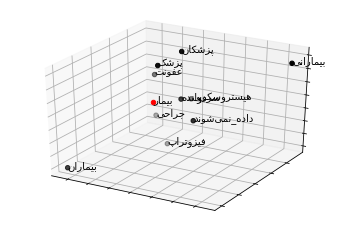

In [ ]:
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

# install: pip install --upgrade arabic-reshaper
import arabic_reshaper

# install: pip install python-bidi
from bidi.algorithm import get_display

# W2vmodel = gensim.models.Word2Vec.load(model_path)
word = "بیمار"
fig = plt.figure()

## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 W2vmodel.wv.most_similar(word, topn=10)]
X = W2vmodel.wv[tot_words]

## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1

## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=get_display(arabic_reshaper.reshape(label)))

#### morphing

##### params

In [ ]:
trainTrim=25

In [ ]:
with open(datasetf+"_pp1"+".pickle", 'rb') as f:
  train, valid, test, labels = pickle.load(f)

# with open(datasetf+"_pp2"+".pickle", 'rb') as f2:
#   train2, valid2, test2, labels = pickle.load(f2)

In [ ]:
x_train, y_train = train['news'].values.tolist(), train['label_id'].values.tolist()
x_valid, y_valid = valid['news'].values.tolist(), valid['label_id'].values.tolist()
x_test, y_test = test['news'].values.tolist(), test['label_id'].values.tolist()

# x_train2, y_train2 = train2['news'].values.tolist(), train2['label_id'].values.tolist()
# x_valid2, y_valid2 = valid2['news'].values.tolist(), valid2['label_id'].values.tolist()
# x_test2, y_test2 = test2['news'].values.tolist(), test2['label_id'].values.tolist()

In [ ]:
def morph(x,y):

  morphedtokens=[]
  labele=[]
  for i in range(len(x)):
    te=list(np.zeros(len(labels), dtype=int))
    te[y[i]]=1
    labele.append(te)

    #Tokenizing
    tokenizedlines=hazm.word_tokenize(x[i])

    #Trimming
    tokenizedlines=tokenizedlines[:trainTrim]

    templine=[]
    for j in range(len(tokenizedlines)):
      if(W2vmodel.wv.vocab.get(tokenizedlines[j])==None):
        print(tokenizedlines[j])

      templine.append(W2vmodel.wv.vocab.get(tokenizedlines[j]).index+1)

    #Padding
    for k in range(trainTrim-len(templine)):
      templine.append(0)

    morphedtokens.append(templine)

  return morphedtokens,labele

In [ ]:
for m in mod:
  for es in embedding_sizes:
    for ws in window_sizes:
      for it in iterations:
        #morphing W2V model
        W2vmodel = gensim.models.Word2Vec.load(model_path+"-"+str(m)+"-"+str(es)+"-"+str(ws)+"-"+str(it))

        zeross=np.zeros(es)
        zeross = np.array([zeross.astype('float32')])
        W2V=np.concatenate((zeross, W2vmodel.wv.vectors), axis=0)

        with open(word2vecf+"-"+str(m)+"-"+str(es)+"-"+str(ws)+"-"+str(it), 'wb') as f:
          np.savez(word2vecf+"-"+str(m)+"-"+str(es)+"-"+str(ws)+"-"+str(it),W2V)
          f.close()

        if m==1:
          x_train_m,y_train_m=morph(x_train,y_train)
          x_valid_m,y_valid_m=morph(x_valid,y_valid)
          x_test_m,y_test_m=morph(x_test,y_test)

          X_train_m=np.array(x_train_m)
          Y_train_m=np.array(y_train_m)

          X_valid_m=np.array(x_valid_m)
          Y_valid_m=np.array(y_valid_m)

          X_test_m=np.array(x_test_m)
          Y_test_m=np.array(y_test_m)

          with open(trainOutput+"-"+str(m)+"-"+str(es)+"-"+str(ws)+"-"+str(it), 'wb') as f:
              pickle.dump([X_train_m, Y_train_m, X_valid_m, Y_valid_m, X_test_m, Y_test_m], f)
              f.close()

        elif m==2:
          x_train_m2,y_train_m2=morph(x_train2,y_train2)
          x_valid_m2,y_valid_m2=morph(x_valid2,y_valid2)
          x_test_m2,y_test_m2=morph(x_test2,y_test2)

          X_train_m2=np.array(x_train_m2)
          Y_train_m2=np.array(y_train_m2)

          X_valid_m2=np.array(x_valid_m2)
          Y_valid_m2=np.array(y_valid_m2)

          X_test_m2=np.array(x_test_m2)
          Y_test_m2=np.array(y_test_m2)

          with open(trainOutput+"-"+str(m)+"-"+str(es)+"-"+str(ws)+"-"+str(it), 'wb') as f:
              pickle.dump([X_train_m2, Y_train_m2, X_valid_m2, Y_valid_m2, X_test_m2, Y_test_m2], f)
              f.close()

In [ ]:
print(X_train_m.shape)
print(Y_test_m.shape)
print(W2V.shape)

(75679, 25)
(15713, 4)
(77480, 300)


# pre model 

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [64]:
import pickle
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score, roc_auc_score
from sklearn import metrics
from keras import regularizers
import seaborn as sns
# install: pip install --upgrade arabic-reshaper
import arabic_reshaper

# install: pip install python-bidi
from bidi.algorithm import get_display

datasetname="persian_news"

mod=[1,2]
embedding_sizes=[100,300]
window_sizes=[5,15]
iterations=[5,20]

morphed_dataset = "/content/drive/MyDrive/payannameF/word2vec/data"+datasetname+".pickle-2-300-15-20"
Word2vec = "/content/drive/MyDrive/payannameF/word2vec/word2vec"+datasetname+"-2-300-15-20.npz"
dataset = "/content/drive/MyDrive/payannameF/dataset/processed/dataset"+datasetname+"_pp2.pickle"

with open(morphed_dataset, "rb") as f:
    x_train_m, y_train_m, x_valid_m, y_valid_m, x_test_m, y_test_m = pickle.load(f)

with open(dataset, "rb") as f:
    train, valid, test, labels = pickle.load(f)

with open(Word2vec, 'rb') as file:
    Word_vector_l = np.load(file)
    word_vector_l = Word_vector_l['arr_0']

vocab_size=word_vector_l.shape[0]
embedding_size=word_vector_l.shape[1]
maxlim=5

# Bert training

## config1 on ds1

### Model

In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torch;
torch.__version__

'1.11.0+cu113'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


### Config

In [ ]:
# general config
MAX_LEN = 512
TRAIN_BATCH_SIZE = 10
VALID_BATCH_SIZE = 10
TEST_BATCH_SIZE = 10

EPOCHS = 3
EEVERY_EPOCH = 1207
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/drive/MyDrive/payannameF/models/BERT/'+datasetname+'model.bin'
HISTORY_PATH = '/content/drive/MyDrive/payannameF/models/BERT/'+datasetname+'history.npy'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
# create a key finder based on label 2 id and id to label

label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'اجتماعی': 0, 'اقتصادی': 1, 'بین الملل': 2, 'سیاسی': 3, 'علمی فناوری': 4, 'فرهنگی هنری': 5, 'ورزشی': 6, 'پزشکی': 7}
id2label: {0: 'اجتماعی', 1: 'اقتصادی', 2: 'بین الملل', 3: 'سیاسی', 4: 'علمی فناوری', 5: 'فرهنگی هنری', 6: 'ورزشی', 7: 'پزشکی'}


In [ ]:
# setup the tokenizer and configuration
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "\u0627\u062c\u062a\u0645\u0627\u0639\u06cc",
    "1": "\u0627\u0642\u062a\u0635\u0627\u062f\u06cc",
    "2": "\u0628\u06cc\u0646 \u0627\u0644\u0645\u0644\u0644",
    "3": "\u0633\u06cc\u0627\u0633\u06cc",
    "4": "\u0639\u0644\u0645\u06cc \u0641\u0646\u0627\u0648\u0631\u06cc",
    "5": "\u0641\u0631\u0647\u0646\u06af\u06cc \u0647\u0646\u0631\u06cc",
    "6": "\u0648\u0631\u0632\u0634\u06cc",
    "7": "\u067e\u0632\u0634\u06a9\u06cc"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "\u0627\u062c\u062a\u0645\u0627\u0639\u06cc": 0,
    "\u0627\u0642\u062a\u0635\u0627\u062f\u06cc": 1,
    "\u0628\u06cc\u0646 \u0627\u0644\u0645\u0644\u0644": 2,
    "\u0633\u06cc\u0627\u0633\u06cc": 3,
    "\u0639\u0644\u0645\u06cc \u0641\u0646\u0627\u0648\

In [ ]:
class TaaghcheDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Taaghche. """

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=512):
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
    
    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = TaaghcheDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        label_list=label_list)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
label_list = labels
train_data_loader = create_data_loader(train['news'].to_numpy(), train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['news'].to_numpy(), valid['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['news'].to_numpy(), None, tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

In [ ]:
import torch, gc
 
gc.collect()
torch.cuda.empty_cache()
 
!nvidia-smi

Thu May  5 13:01:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    63W / 149W |    145MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH,return_dict=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids)
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits 

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
pt_model = None

!nvidia-smi

Thu May  5 13:01:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    63W / 149W |    145MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.SentimentModel'>


In [ ]:
!nvidia-smi

Thu May  5 13:02:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    64W / 149W |   1247MiB / 11441MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Train

In [ ]:
def simple_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = simple_accuracy(y_true, y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss


def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):
            
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            # calculate the batch loss
            loss = loss_fn(outputs, targets)

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)
    
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss


def train_op(model, 
             data_loader, 
             loss_fn, 
             optimizer, 
             scheduler, 
             step=0, 
             print_every_step=100, 
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None, 
             clip=0.0):
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
        # convert output probabilities to predicted class
        _, preds = torch.max(outputs, dim=1)

        # calculate the batch loss
        loss = loss_fn(outputs, targets)

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min

In [ ]:
optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

step = 0
eval_loss_min = np.Inf
#history = collections.defaultdict(list)
history=[[],[],[],[]]

def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history[0].append(train_score['acc'])
    history[1].append(train_loss)
    history[2].append(eval_score['acc'])
    history[3].append(eval_loss)

np.save(HISTORY_PATH, history)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Epochs... :   0%|          | 0/3 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 1/3...Step: 1207...Train Loss: 0.175845...Train Acc: 0.947...Valid Loss: 0.098378...Valid Acc: 0.977...
Validation loss decreased (inf --> 0.098378).  Saving model ...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 2/3...Step: 2414...Train Loss: 0.039907...Train Acc: 0.990...Valid Loss: 0.090531...Valid Acc: 0.977...
Validation loss decreased (0.098378 --> 0.090531).  Saving model ...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 3/3...Step: 3621...Train Loss: 0.012998...Train Acc: 0.996...Valid Loss: 0.125625...Valid Acc: 0.972...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

### Predict

In [ ]:
def predict(model, news, tokenizer, max_len=512, batch_size=10):
    data_loader = create_data_loader(news, None, tokenizer, max_len, batch_size, None)
    
    predictions = []
    prediction_probs = []

    
    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

In [ ]:
test_comments = test['news'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=512, batch_size=10)

print(preds.shape, probs.shape)

  0%|          | 0/150 [00:00<?, ?it/s]

(1491,) (1491, 8)


### Results

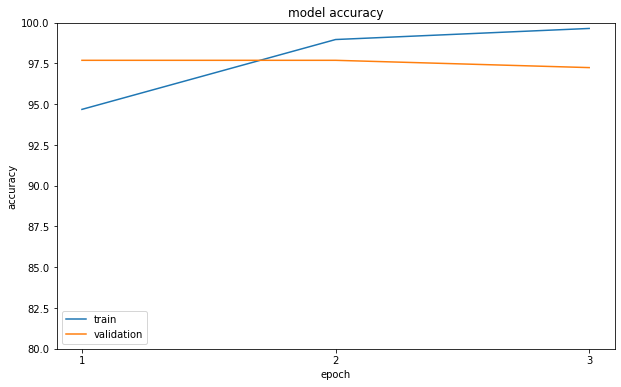

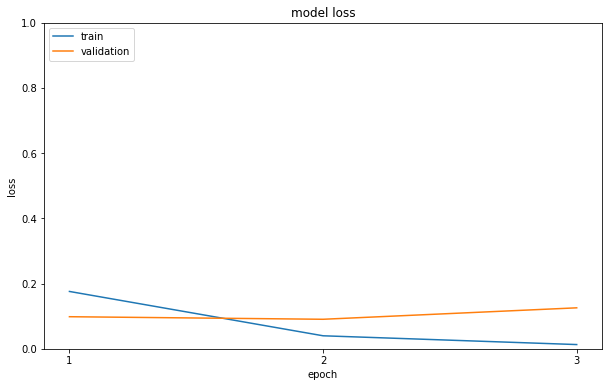

In [ ]:
history=np.load(HISTORY_PATH,allow_pickle=True)

# summarize history for accuracy
plt.rcParams["figure.figsize"] = (10,6)
e_arr = np.array([1,2,3])
plt.plot(e_arr, history[0]*100)
plt.plot(e_arr, history[2]*100)
plt.xticks(range(1, 4))
plt.ylim(80,100)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

# summarize history for loss
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(e_arr, history[1])
plt.plot(e_arr, history[3])
plt.xticks(range(1, 4))
plt.ylim(0,1)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score,roc_auc_score, classification_report
import seaborn as sns
# install: pip install --upgrade arabic-reshaper
import arabic_reshaper

# install: pip install python-bidi
from bidi.algorithm import get_display

y_test, y_pred = [label_list.index(label) for label in test['label'].values], preds
# classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

per_label = []
for lb in labels:
  per_label.append(get_display(arabic_reshaper.reshape(lb)))

In [ ]:
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test, preds)
auc = roc_auc_score(y_test, probs, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test, preds))

Accuracy: 0.98
F1: 0.9764834688010102
Auc: 1.0
Detail:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       197
           1       0.97      0.97      0.97       142
           2       0.99      0.99      0.99       179
           3       0.97      0.95      0.96       204
           4       0.98      0.99      0.99       222
           5       0.99      0.98      0.98       232
           6       1.00      0.99      1.00       126
           7       0.95      0.99      0.97       189

    accuracy                           0.98      1491
   macro avg       0.98      0.98      0.98      1491
weighted avg       0.98      0.98      0.98      1491



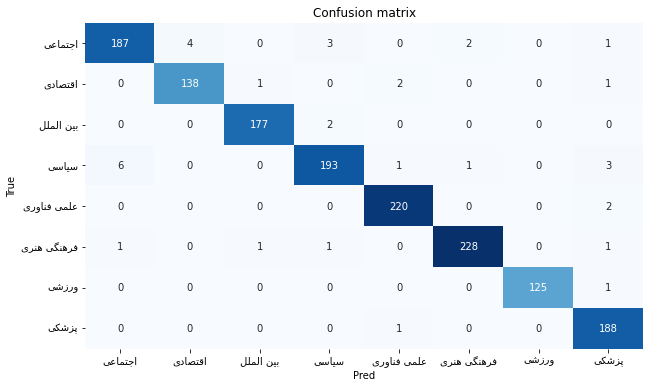

In [ ]:
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, preds)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=per_label, 
       yticklabels=per_label, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

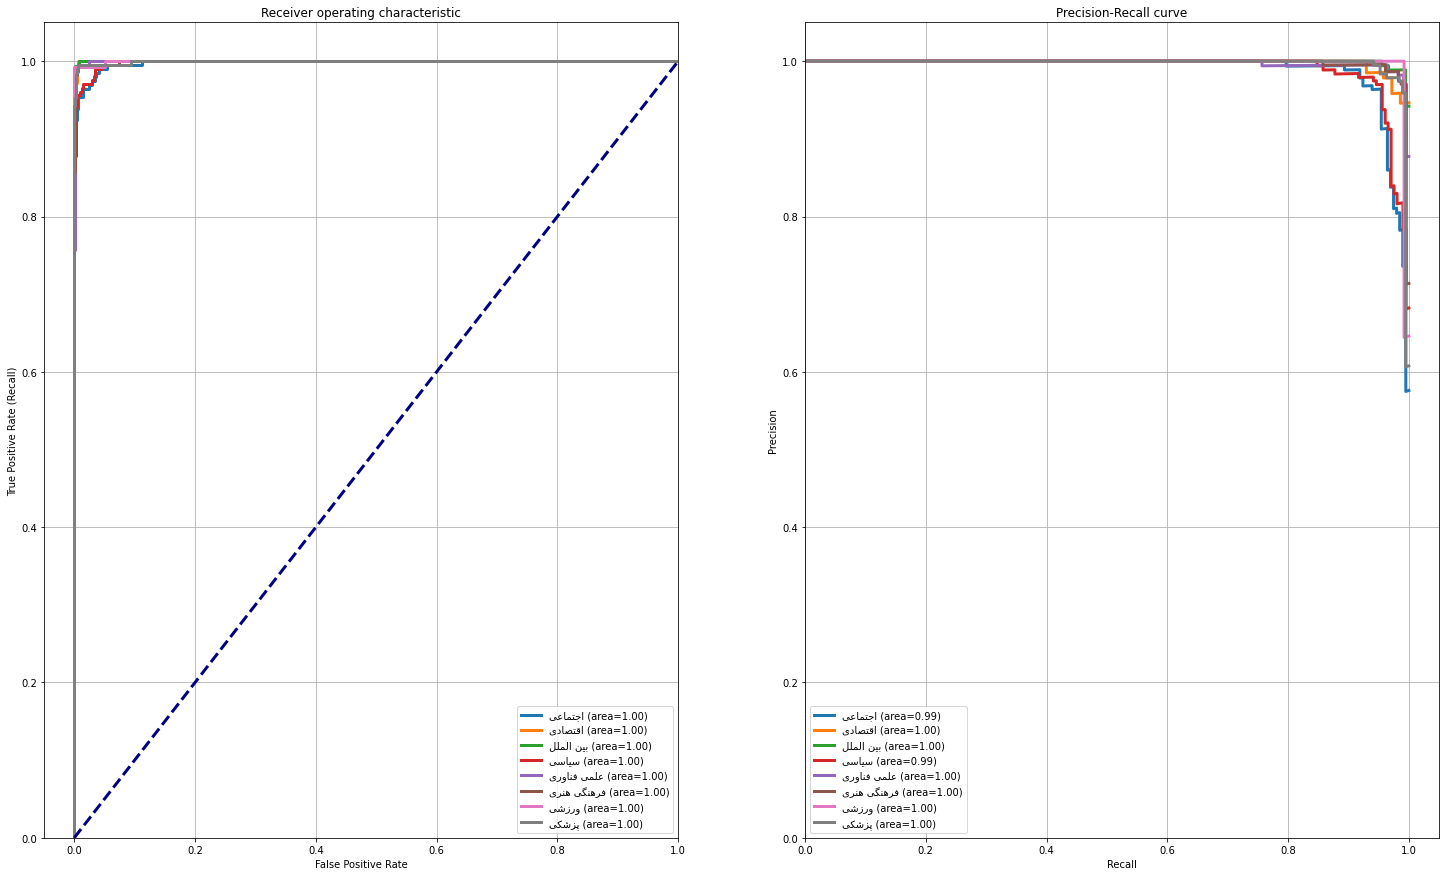

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,15))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           probs[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(per_label[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], probs[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(per_label[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## config2 on ds1

### Model

In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torch;
torch.__version__

'1.11.0+cu113'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


### Config

In [ ]:
# general config
MAX_LEN = 50
TRAIN_BATCH_SIZE = 10
VALID_BATCH_SIZE = 10
TEST_BATCH_SIZE = 10

EPOCHS = 3
EEVERY_EPOCH = 1207
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/drive/MyDrive/payannameF/models/BERT/'+datasetname+'model.bin'
HISTORY_PATH = '/content/drive/MyDrive/payannameF/models/BERT/'+datasetname+'history.npy'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
# create a key finder based on label 2 id and id to label

label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'اجتماعی': 0, 'اقتصادی': 1, 'بین الملل': 2, 'سیاسی': 3, 'علمی فناوری': 4, 'فرهنگی هنری': 5, 'ورزشی': 6, 'پزشکی': 7}
id2label: {0: 'اجتماعی', 1: 'اقتصادی', 2: 'بین الملل', 3: 'سیاسی', 4: 'علمی فناوری', 5: 'فرهنگی هنری', 6: 'ورزشی', 7: 'پزشکی'}


In [ ]:
# setup the tokenizer and configuration
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

Downloading:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440 [00:00<?, ?B/s]

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "\u0627\u062c\u062a\u0645\u0627\u0639\u06cc",
    "1": "\u0627\u0642\u062a\u0635\u0627\u062f\u06cc",
    "2": "\u0628\u06cc\u0646 \u0627\u0644\u0645\u0644\u0644",
    "3": "\u0633\u06cc\u0627\u0633\u06cc",
    "4": "\u0639\u0644\u0645\u06cc \u0641\u0646\u0627\u0648\u0631\u06cc",
    "5": "\u0641\u0631\u0647\u0646\u06af\u06cc \u0647\u0646\u0631\u06cc",
    "6": "\u0648\u0631\u0632\u0634\u06cc",
    "7": "\u067e\u0632\u0634\u06a9\u06cc"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "\u0627\u062c\u062a\u0645\u0627\u0639\u06cc": 0,
    "\u0627\u0642\u062a\u0635\u0627\u062f\u06cc": 1,
    "\u0628\u06cc\u0646 \u0627\u0644\u0645\u0644\u0644": 2,
    "\u0633\u06cc\u0627\u0633\u06cc": 3,
    "\u0639\u0644\u0645\u06cc \u0641\u0646\u0627\u0648\

In [ ]:
class TaaghcheDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Taaghche. """

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=512):
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
    
    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = TaaghcheDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        label_list=label_list)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
label_list = labels
train_data_loader = create_data_loader(train['news'].to_numpy(), train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['news'].to_numpy(), valid['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['news'].to_numpy(), None, tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

In [ ]:
import torch, gc
 
gc.collect()
torch.cuda.empty_cache()
 
!nvidia-smi

Sat May  7 09:47:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    72W / 149W |    145MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH,return_dict=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids)
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits 

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
pt_model = None

!nvidia-smi

Sat May  7 09:47:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    72W / 149W |    145MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Downloading:   0%|          | 0.00/624M [00:00<?, ?B/s]

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.SentimentModel'>


In [ ]:
!nvidia-smi

Sat May  7 09:48:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    72W / 149W |   1247MiB / 11441MiB |     21%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Train

In [ ]:
def simple_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = simple_accuracy(y_true, y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss


def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):
            
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            # calculate the batch loss
            loss = loss_fn(outputs, targets)

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)
    
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss


def train_op(model, 
             data_loader, 
             loss_fn, 
             optimizer, 
             scheduler, 
             step=0, 
             print_every_step=100, 
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None, 
             clip=0.0):
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
        # convert output probabilities to predicted class
        _, preds = torch.max(outputs, dim=1)

        # calculate the batch loss
        loss = loss_fn(outputs, targets)

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min

In [ ]:
optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

step = 0
eval_loss_min = np.Inf
#history = collections.defaultdict(list)
history=[[],[],[],[]]

def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history[0].append(train_score['acc'])
    history[1].append(train_loss)
    history[2].append(eval_score['acc'])
    history[3].append(eval_loss)

np.save(HISTORY_PATH, history)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Epochs... :   0%|          | 0/3 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 1/3...Step: 1207...Train Loss: 0.200543...Train Acc: 0.939...Valid Loss: 0.130950...Valid Acc: 0.965...
Validation loss decreased (inf --> 0.130950).  Saving model ...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 2/3...Step: 2414...Train Loss: 0.054597...Train Acc: 0.984...Valid Loss: 0.145982...Valid Acc: 0.961...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 3/3...Step: 3621...Train Loss: 0.018791...Train Acc: 0.995...Valid Loss: 0.149505...Valid Acc: 0.960...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

### Predict

In [ ]:
def predict(model, news, tokenizer, max_len=512, batch_size=10):
    data_loader = create_data_loader(news, None, tokenizer, max_len, batch_size, None)
    
    predictions = []
    prediction_probs = []

    
    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

In [ ]:
test_comments = test['news'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=50, batch_size=10)

print(preds.shape, probs.shape)

  0%|          | 0/150 [00:00<?, ?it/s]

(1491,) (1491, 8)


### Results

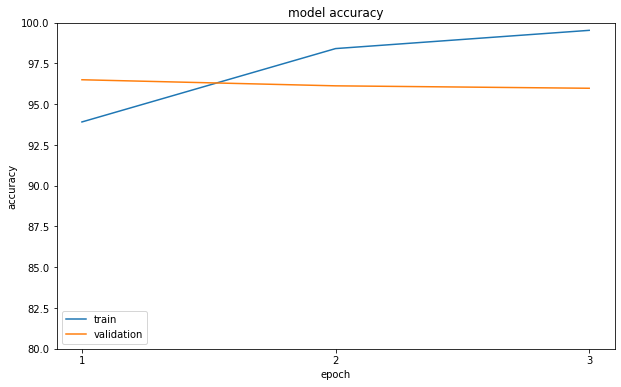

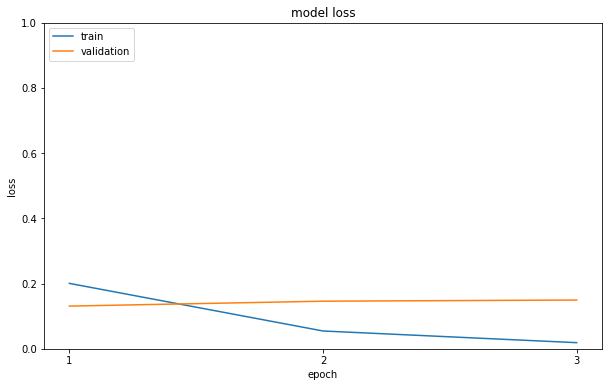

In [ ]:
history=np.load(HISTORY_PATH,allow_pickle=True)

# summarize history for accuracy
plt.rcParams["figure.figsize"] = (10,6)
e_arr = np.array([1,2,3])
plt.plot(e_arr, history[0]*100)
plt.plot(e_arr, history[2]*100)
plt.xticks(range(1, 4))
plt.ylim(80,100)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

# summarize history for loss
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(e_arr, history[1])
plt.plot(e_arr, history[3])
plt.xticks(range(1, 4))
plt.ylim(0,1)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score,roc_auc_score, classification_report
import seaborn as sns
# install: pip install --upgrade arabic-reshaper
import arabic_reshaper

# install: pip install python-bidi
from bidi.algorithm import get_display

y_test, y_pred = [label_list.index(label) for label in test['label'].values], preds
# classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

per_label = []
for lb in labels:
  per_label.append(get_display(arabic_reshaper.reshape(lb)))

In [ ]:
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test, preds)
auc = roc_auc_score(y_test, probs, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test, preds))

Accuracy: 0.96
F1: 0.9644418740443321
Auc: 1.0
Detail:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       197
           1       0.95      0.96      0.95       142
           2       0.97      0.98      0.98       179
           3       0.97      0.94      0.95       204
           4       0.97      0.96      0.97       222
           5       0.98      0.98      0.98       232
           6       0.97      0.98      0.98       126
           7       0.97      0.97      0.97       189

    accuracy                           0.96      1491
   macro avg       0.96      0.97      0.96      1491
weighted avg       0.96      0.96      0.96      1491



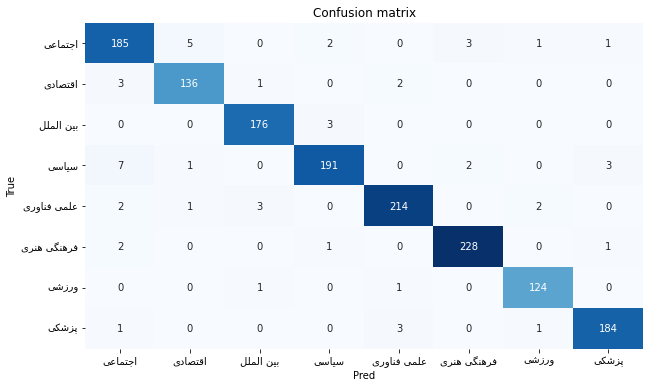

In [ ]:
from sklearn import metrics
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, preds)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=per_label, 
       yticklabels=per_label, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

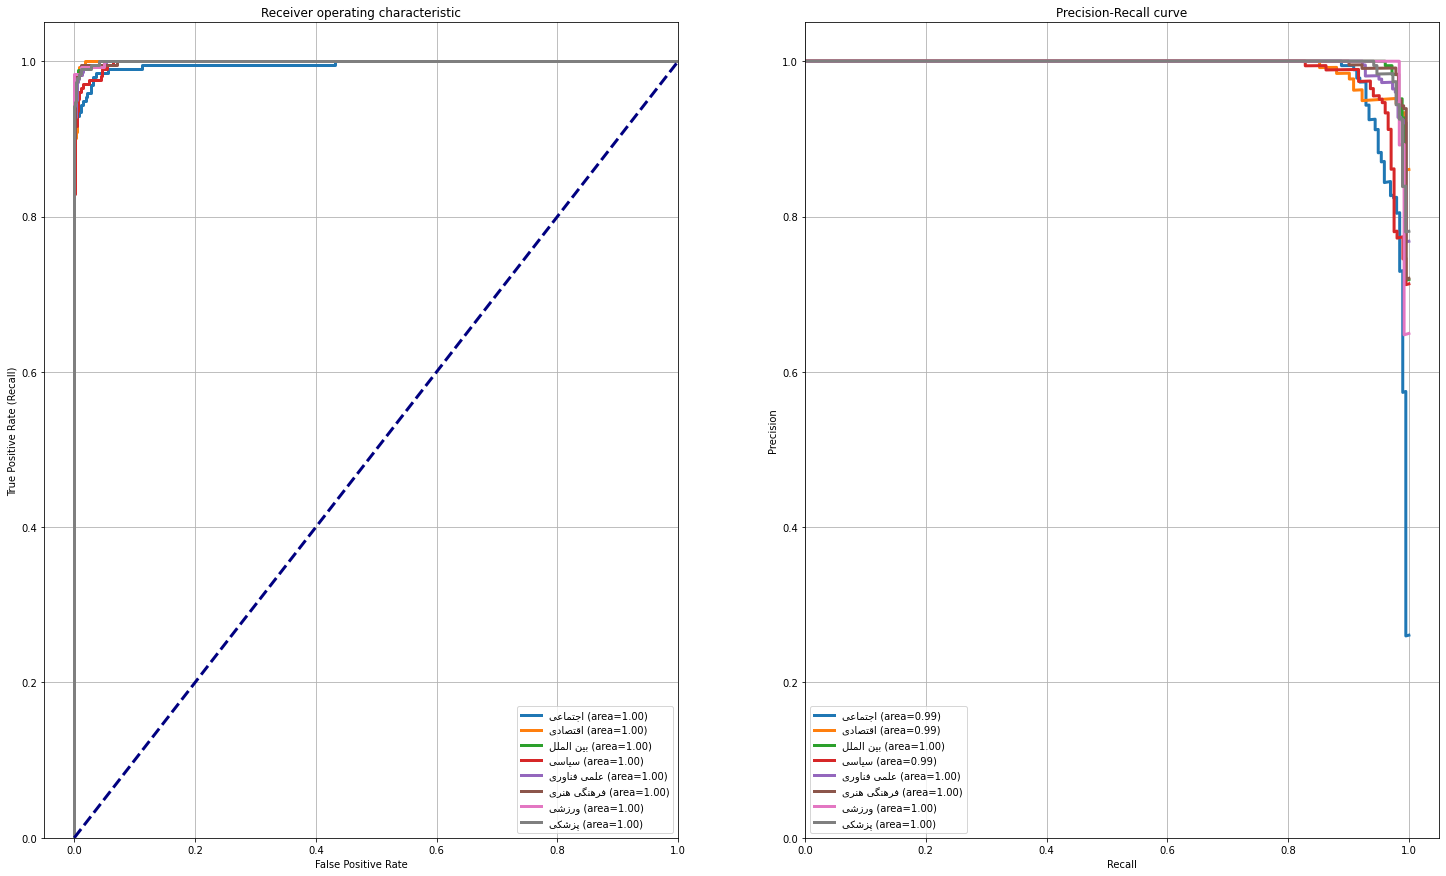

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,15))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           probs[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(per_label[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], probs[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(per_label[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## config3 on ds1

### Model

In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torch;
torch.__version__

'1.11.0+cu113'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


### Config

In [ ]:
# general config
MAX_LEN = 10
TRAIN_BATCH_SIZE = 10
VALID_BATCH_SIZE = 10
TEST_BATCH_SIZE = 10

EPOCHS = 3
EEVERY_EPOCH = 1207
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/drive/MyDrive/payannameF/models/BERT/'+datasetname+'model.bin'
HISTORY_PATH = '/content/drive/MyDrive/payannameF/models/BERT/'+datasetname+'history.npy'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
# create a key finder based on label 2 id and id to label

label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'اجتماعی': 0, 'اقتصادی': 1, 'بین الملل': 2, 'سیاسی': 3, 'علمی فناوری': 4, 'فرهنگی هنری': 5, 'ورزشی': 6, 'پزشکی': 7}
id2label: {0: 'اجتماعی', 1: 'اقتصادی', 2: 'بین الملل', 3: 'سیاسی', 4: 'علمی فناوری', 5: 'فرهنگی هنری', 6: 'ورزشی', 7: 'پزشکی'}


In [ ]:
# setup the tokenizer and configuration
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "\u0627\u062c\u062a\u0645\u0627\u0639\u06cc",
    "1": "\u0627\u0642\u062a\u0635\u0627\u062f\u06cc",
    "2": "\u0628\u06cc\u0646 \u0627\u0644\u0645\u0644\u0644",
    "3": "\u0633\u06cc\u0627\u0633\u06cc",
    "4": "\u0639\u0644\u0645\u06cc \u0641\u0646\u0627\u0648\u0631\u06cc",
    "5": "\u0641\u0631\u0647\u0646\u06af\u06cc \u0647\u0646\u0631\u06cc",
    "6": "\u0648\u0631\u0632\u0634\u06cc",
    "7": "\u067e\u0632\u0634\u06a9\u06cc"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "\u0627\u062c\u062a\u0645\u0627\u0639\u06cc": 0,
    "\u0627\u0642\u062a\u0635\u0627\u062f\u06cc": 1,
    "\u0628\u06cc\u0646 \u0627\u0644\u0645\u0644\u0644": 2,
    "\u0633\u06cc\u0627\u0633\u06cc": 3,
    "\u0639\u0644\u0645\u06cc \u0641\u0646\u0627\u0648\

In [ ]:
class TaaghcheDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Taaghche. """

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=512):
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
    
    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = TaaghcheDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        label_list=label_list)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
label_list = labels
train_data_loader = create_data_loader(train['news'].to_numpy(), train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['news'].to_numpy(), valid['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['news'].to_numpy(), None, tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

In [ ]:
import torch, gc
 
gc.collect()
torch.cuda.empty_cache()
 
!nvidia-smi

Sat May  7 10:20:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    73W / 149W |   3206MiB / 11441MiB |     44%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH,return_dict=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids)
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits 

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
pt_model = None

!nvidia-smi

Sat May  7 10:20:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    72W / 149W |   3206MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.SentimentModel'>


In [ ]:
!nvidia-smi

Sat May  7 10:20:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    72W / 149W |   3860MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Train

In [ ]:
def simple_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = simple_accuracy(y_true, y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss


def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):
            
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            # calculate the batch loss
            loss = loss_fn(outputs, targets)

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)
    
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss


def train_op(model, 
             data_loader, 
             loss_fn, 
             optimizer, 
             scheduler, 
             step=0, 
             print_every_step=100, 
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None, 
             clip=0.0):
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
        # convert output probabilities to predicted class
        _, preds = torch.max(outputs, dim=1)

        # calculate the batch loss
        loss = loss_fn(outputs, targets)

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min

In [ ]:
optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

step = 0
eval_loss_min = np.Inf
#history = collections.defaultdict(list)
history=[[],[],[],[]]

def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history[0].append(train_score['acc'])
    history[1].append(train_loss)
    history[2].append(eval_score['acc'])
    history[3].append(eval_loss)

np.save(HISTORY_PATH, history)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Epochs... :   0%|          | 0/3 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 1/3...Step: 1207...Train Loss: 0.401626...Train Acc: 0.877...Valid Loss: 0.271901...Valid Acc: 0.914...
Validation loss decreased (inf --> 0.271901).  Saving model ...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 2/3...Step: 2414...Train Loss: 0.163925...Train Acc: 0.950...Valid Loss: 0.259632...Valid Acc: 0.926...
Validation loss decreased (0.271901 --> 0.259632).  Saving model ...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 3/3...Step: 3621...Train Loss: 0.079567...Train Acc: 0.977...Valid Loss: 0.273357...Valid Acc: 0.928...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

### Predict

In [ ]:
def predict(model, news, tokenizer, max_len=512, batch_size=10):
    data_loader = create_data_loader(news, None, tokenizer, max_len, batch_size, None)
    
    predictions = []
    prediction_probs = []

    
    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

In [ ]:
test_comments = test['news'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=10, batch_size=10)

print(preds.shape, probs.shape)

  0%|          | 0/150 [00:00<?, ?it/s]

(1491,) (1491, 8)


### Results

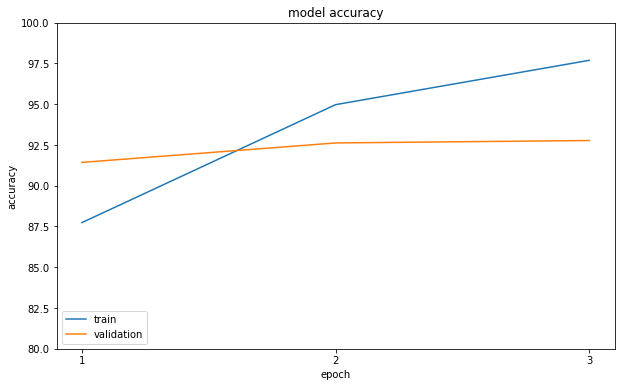

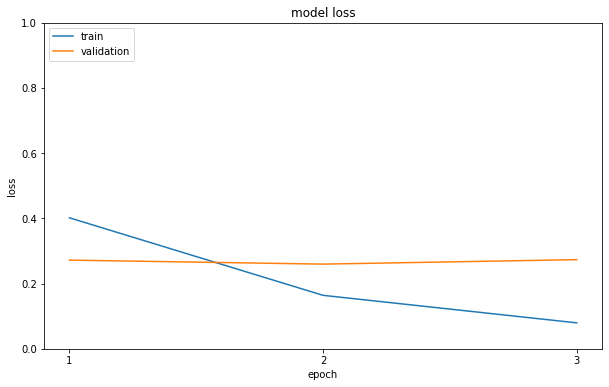

In [ ]:
history=np.load(HISTORY_PATH,allow_pickle=True)

# summarize history for accuracy
plt.rcParams["figure.figsize"] = (10,6)
e_arr = np.array([1,2,3])
plt.plot(e_arr, history[0]*100)
plt.plot(e_arr, history[2]*100)
plt.xticks(range(1, 4))
plt.ylim(80,100)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

# summarize history for loss
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(e_arr, history[1])
plt.plot(e_arr, history[3])
plt.xticks(range(1, 4))
plt.ylim(0,1)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score,roc_auc_score, classification_report
import seaborn as sns
# install: pip install --upgrade arabic-reshaper
import arabic_reshaper

# install: pip install python-bidi
from bidi.algorithm import get_display

y_test, y_pred = [label_list.index(label) for label in test['label'].values], preds
# classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

per_label = []
for lb in labels:
  per_label.append(get_display(arabic_reshaper.reshape(lb)))

In [ ]:
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test, preds)
auc = roc_auc_score(y_test, probs, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test, preds))

Accuracy: 0.91
F1: 0.9065096809634069
Auc: 0.99
Detail:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       197
           1       0.88      0.87      0.88       142
           2       0.95      0.97      0.96       179
           3       0.90      0.89      0.89       204
           4       0.91      0.91      0.91       222
           5       0.94      0.92      0.93       232
           6       0.95      0.97      0.96       126
           7       0.87      0.92      0.89       189

    accuracy                           0.91      1491
   macro avg       0.91      0.91      0.91      1491
weighted avg       0.91      0.91      0.91      1491



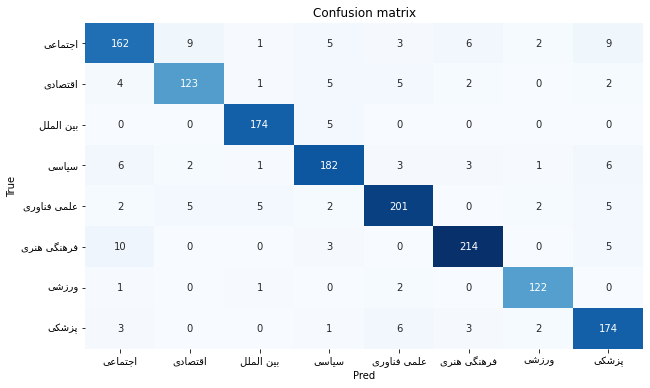

In [ ]:
from sklearn import metrics
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, preds)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=per_label, 
       yticklabels=per_label, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

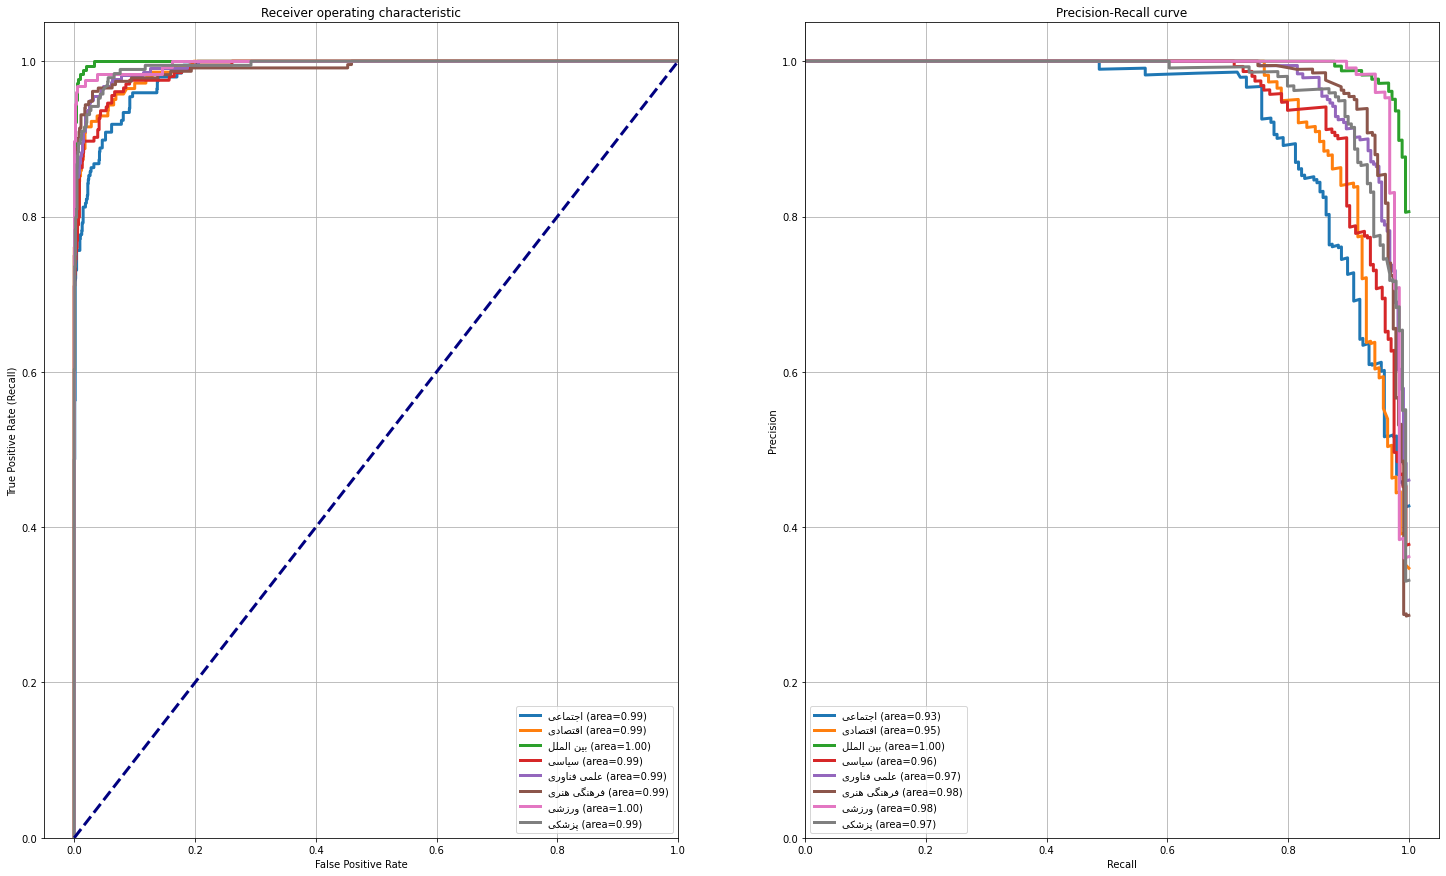

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,15))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           probs[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(per_label[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], probs[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(per_label[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## config4 on ds1

### Model

In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torch;
torch.__version__

'1.11.0+cu113'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


### Config

In [ ]:
# general config
MAX_LEN = 5
TRAIN_BATCH_SIZE = 10
VALID_BATCH_SIZE = 10
TEST_BATCH_SIZE = 10

EPOCHS = 3
EEVERY_EPOCH = 1207
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/drive/MyDrive/payannameF/models/BERT/'+datasetname+'model.bin'
HISTORY_PATH = '/content/drive/MyDrive/payannameF/models/BERT/'+datasetname+'history.npy'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
# create a key finder based on label 2 id and id to label

label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'اجتماعی': 0, 'اقتصادی': 1, 'بین الملل': 2, 'سیاسی': 3, 'علمی فناوری': 4, 'فرهنگی هنری': 5, 'ورزشی': 6, 'پزشکی': 7}
id2label: {0: 'اجتماعی', 1: 'اقتصادی', 2: 'بین الملل', 3: 'سیاسی', 4: 'علمی فناوری', 5: 'فرهنگی هنری', 6: 'ورزشی', 7: 'پزشکی'}


In [ ]:
# setup the tokenizer and configuration
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "\u0627\u062c\u062a\u0645\u0627\u0639\u06cc",
    "1": "\u0627\u0642\u062a\u0635\u0627\u062f\u06cc",
    "2": "\u0628\u06cc\u0646 \u0627\u0644\u0645\u0644\u0644",
    "3": "\u0633\u06cc\u0627\u0633\u06cc",
    "4": "\u0639\u0644\u0645\u06cc \u0641\u0646\u0627\u0648\u0631\u06cc",
    "5": "\u0641\u0631\u0647\u0646\u06af\u06cc \u0647\u0646\u0631\u06cc",
    "6": "\u0648\u0631\u0632\u0634\u06cc",
    "7": "\u067e\u0632\u0634\u06a9\u06cc"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "\u0627\u062c\u062a\u0645\u0627\u0639\u06cc": 0,
    "\u0627\u0642\u062a\u0635\u0627\u062f\u06cc": 1,
    "\u0628\u06cc\u0646 \u0627\u0644\u0645\u0644\u0644": 2,
    "\u0633\u06cc\u0627\u0633\u06cc": 3,
    "\u0639\u0644\u0645\u06cc \u0641\u0646\u0627\u0648\

In [ ]:
class TaaghcheDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Taaghche. """

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=512):
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
    
    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = TaaghcheDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        label_list=label_list)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
label_list = labels
train_data_loader = create_data_loader(train['news'].to_numpy(), train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['news'].to_numpy(), valid['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['news'].to_numpy(), None, tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

In [ ]:
import torch, gc
 
gc.collect()
torch.cuda.empty_cache()
 
!nvidia-smi

Sat May  7 12:10:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    59W / 149W |   3540MiB / 11441MiB |     27%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH,return_dict=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids)
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits 

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
pt_model = None

!nvidia-smi

Sat May  7 12:10:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    59W / 149W |   3540MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.SentimentModel'>


In [ ]:
!nvidia-smi

Sat May  7 12:10:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    60W / 149W |   3874MiB / 11441MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Train

In [ ]:
def simple_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = simple_accuracy(y_true, y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss


def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):
            
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            # calculate the batch loss
            loss = loss_fn(outputs, targets)

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)
    
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss


def train_op(model, 
             data_loader, 
             loss_fn, 
             optimizer, 
             scheduler, 
             step=0, 
             print_every_step=100, 
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None, 
             clip=0.0):
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
        # convert output probabilities to predicted class
        _, preds = torch.max(outputs, dim=1)

        # calculate the batch loss
        loss = loss_fn(outputs, targets)

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min

In [ ]:
optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

step = 0
eval_loss_min = np.Inf
#history = collections.defaultdict(list)
history=[[],[],[],[]]

def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history[0].append(train_score['acc'])
    history[1].append(train_loss)
    history[2].append(eval_score['acc'])
    history[3].append(eval_loss)

np.save(HISTORY_PATH, history)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Epochs... :   0%|          | 0/3 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 1/3...Step: 1207...Train Loss: 1.574935...Train Acc: 0.397...Valid Loss: 1.401079...Valid Acc: 0.462...
Validation loss decreased (inf --> 1.401079).  Saving model ...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 2/3...Step: 2414...Train Loss: 1.350582...Train Acc: 0.475...Valid Loss: 1.327083...Valid Acc: 0.484...
Validation loss decreased (1.401079 --> 1.327083).  Saving model ...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 3/3...Step: 3621...Train Loss: 1.215814...Train Acc: 0.529...Valid Loss: 1.315482...Valid Acc: 0.494...
Validation loss decreased (1.327083 --> 1.315482).  Saving model ...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

### Predict

In [ ]:
def predict(model, news, tokenizer, max_len=512, batch_size=10):
    data_loader = create_data_loader(news, None, tokenizer, max_len, batch_size, None)
    
    predictions = []
    prediction_probs = []

    
    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

In [ ]:
test_comments = test['news'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=5, batch_size=10)

print(preds.shape, probs.shape)

  0%|          | 0/150 [00:00<?, ?it/s]

(1491,) (1491, 8)


### Results

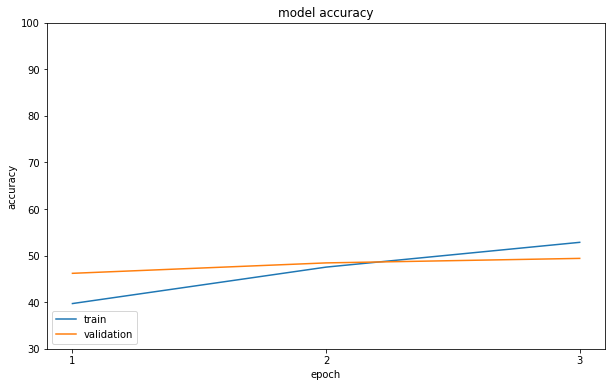

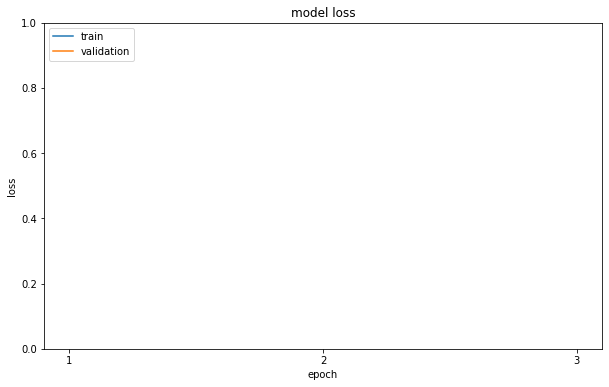

In [ ]:
history=np.load(HISTORY_PATH,allow_pickle=True)

# summarize history for accuracy
plt.rcParams["figure.figsize"] = (10,6)
e_arr = np.array([1,2,3])
plt.plot(e_arr, history[0]*100)
plt.plot(e_arr, history[2]*100)
plt.xticks(range(1, 4))
plt.ylim(30,100)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

# summarize history for loss
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(e_arr, history[1])
plt.plot(e_arr, history[3])
plt.xticks(range(1, 4))
plt.ylim(0,1)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score,roc_auc_score, classification_report, confusion_matrix
from sklearn import metrics
import seaborn as sns
# install: pip install --upgrade arabic-reshaper
import arabic_reshaper

# install: pip install python-bidi
from bidi.algorithm import get_display

y_test, y_pred = [label_list.index(label) for label in test['label'].values], preds
# classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

per_label = []
for lb in labels:
  per_label.append(get_display(arabic_reshaper.reshape(lb)))

In [ ]:
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test, preds)
auc = roc_auc_score(y_test, probs, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test, preds))

Accuracy: 0.47
F1: 0.4507215053094683
Auc: 0.84
Detail:
              precision    recall  f1-score   support

           0       0.24      0.57      0.34       197
           1       0.30      0.10      0.15       142
           2       0.52      0.91      0.66       179
           3       0.45      0.47      0.46       204
           4       0.85      0.80      0.82       222
           5       0.60      0.34      0.44       232
           6       0.48      0.10      0.16       126
           7       0.58      0.26      0.36       189

    accuracy                           0.47      1491
   macro avg       0.50      0.44      0.42      1491
weighted avg       0.52      0.47      0.45      1491



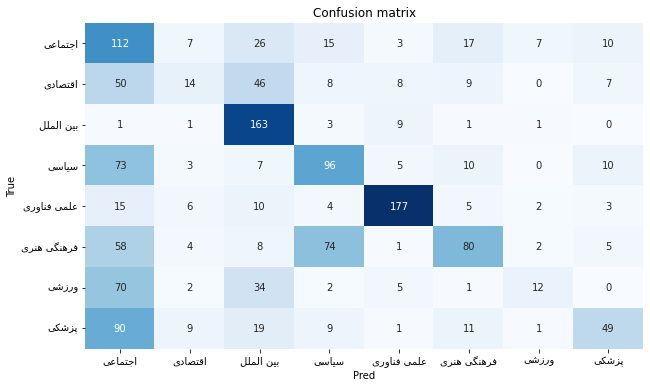

In [ ]:
## Plot confusion matrix
cm = confusion_matrix(y_test, preds)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=per_label, 
       yticklabels=per_label, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

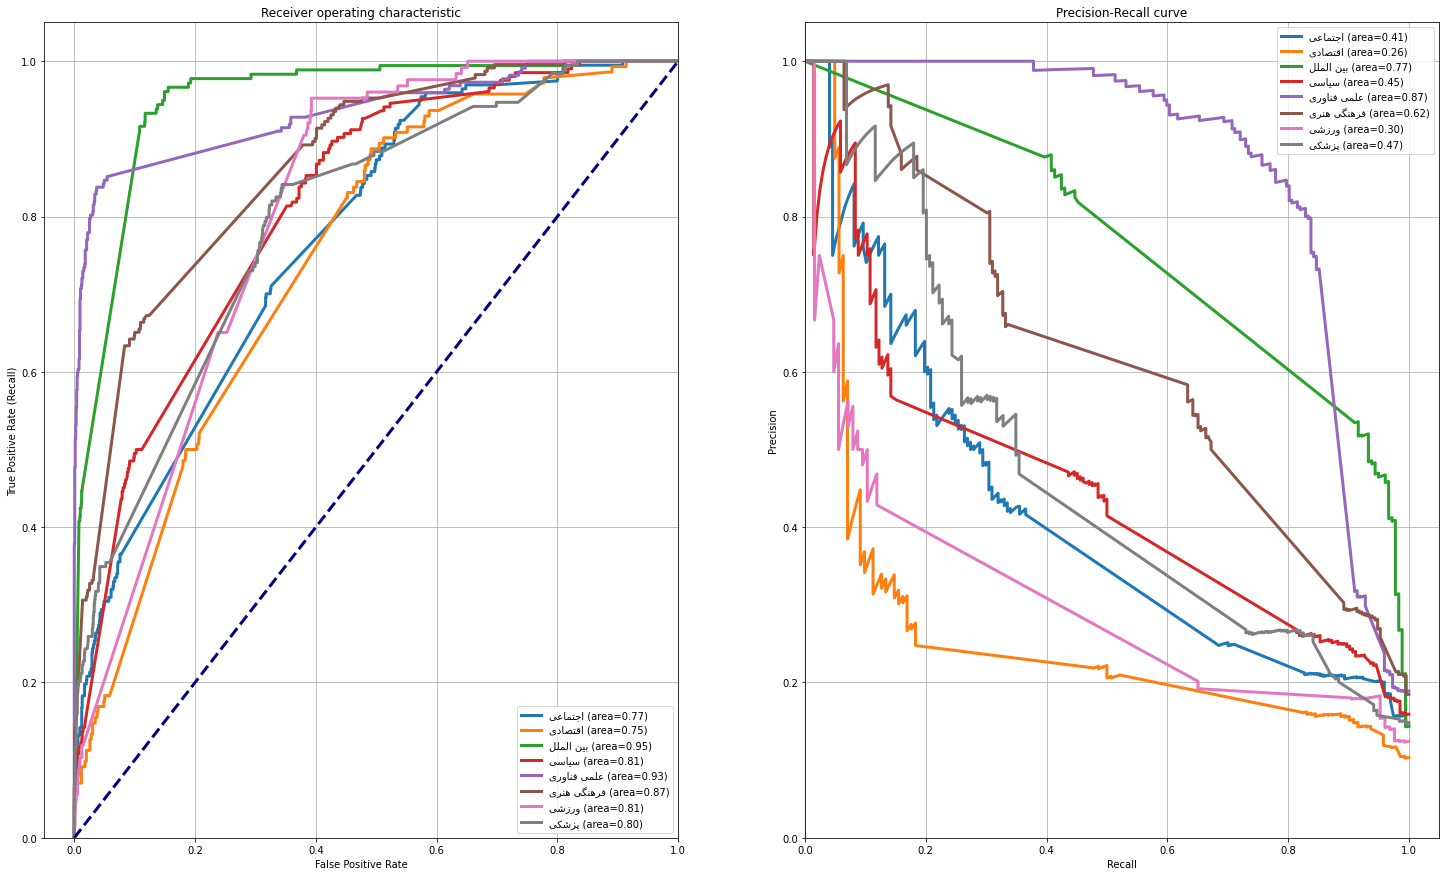

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,15))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           probs[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(per_label[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], probs[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(per_label[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## config5 on ds1

### Model

In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torch;
torch.__version__

'1.11.0+cu113'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


### Config

In [ ]:
# general config
MAX_LEN = 5
TRAIN_BATCH_SIZE = 10
VALID_BATCH_SIZE = 10
TEST_BATCH_SIZE = 10

EPOCHS = 10
EEVERY_EPOCH = 1207
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/drive/MyDrive/payannameF/models/BERT/'+datasetname+'model.bin'
HISTORY_PATH = '/content/drive/MyDrive/payannameF/models/BERT/'+datasetname+'history.npy'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
# create a key finder based on label 2 id and id to label

label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'اجتماعی': 0, 'اقتصادی': 1, 'بین الملل': 2, 'سیاسی': 3, 'علمی فناوری': 4, 'فرهنگی هنری': 5, 'ورزشی': 6, 'پزشکی': 7}
id2label: {0: 'اجتماعی', 1: 'اقتصادی', 2: 'بین الملل', 3: 'سیاسی', 4: 'علمی فناوری', 5: 'فرهنگی هنری', 6: 'ورزشی', 7: 'پزشکی'}


In [ ]:
# setup the tokenizer and configuration
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "\u0627\u062c\u062a\u0645\u0627\u0639\u06cc",
    "1": "\u0627\u0642\u062a\u0635\u0627\u062f\u06cc",
    "2": "\u0628\u06cc\u0646 \u0627\u0644\u0645\u0644\u0644",
    "3": "\u0633\u06cc\u0627\u0633\u06cc",
    "4": "\u0639\u0644\u0645\u06cc \u0641\u0646\u0627\u0648\u0631\u06cc",
    "5": "\u0641\u0631\u0647\u0646\u06af\u06cc \u0647\u0646\u0631\u06cc",
    "6": "\u0648\u0631\u0632\u0634\u06cc",
    "7": "\u067e\u0632\u0634\u06a9\u06cc"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "\u0627\u062c\u062a\u0645\u0627\u0639\u06cc": 0,
    "\u0627\u0642\u062a\u0635\u0627\u062f\u06cc": 1,
    "\u0628\u06cc\u0646 \u0627\u0644\u0645\u0644\u0644": 2,
    "\u0633\u06cc\u0627\u0633\u06cc": 3,
    "\u0639\u0644\u0645\u06cc \u0641\u0646\u0627\u0648\

In [ ]:
class TaaghcheDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Taaghche. """

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=512):
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
    
    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = TaaghcheDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        label_list=label_list)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
label_list = labels
train_data_loader = create_data_loader(train['news'].to_numpy(), train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['news'].to_numpy(), valid['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['news'].to_numpy(), None, tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

In [ ]:
import torch, gc
 
gc.collect()
torch.cuda.empty_cache()
 
!nvidia-smi

Tue May 10 13:22:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    58W / 149W |    145MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH,return_dict=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids)
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits 

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
pt_model = None

!nvidia-smi

Tue May 10 13:22:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    58W / 149W |    145MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.SentimentModel'>


In [ ]:
!nvidia-smi

Tue May 10 13:22:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    58W / 149W |   1247MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Train

In [ ]:
def simple_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = simple_accuracy(y_true, y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss


def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):
            
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            # calculate the batch loss
            loss = loss_fn(outputs, targets)

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)
    
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss


def train_op(model, 
             data_loader, 
             loss_fn, 
             optimizer, 
             scheduler, 
             step=0, 
             print_every_step=100, 
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None, 
             clip=0.0):
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
        # convert output probabilities to predicted class
        _, preds = torch.max(outputs, dim=1)

        # calculate the batch loss
        loss = loss_fn(outputs, targets)

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min

In [ ]:
optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

step = 0
eval_loss_min = np.Inf
#history = collections.defaultdict(list)
history=[[],[],[],[]]

def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history[0].append(train_score['acc'])
    history[1].append(train_loss)
    history[2].append(eval_score['acc'])
    history[3].append(eval_loss)

np.save(HISTORY_PATH, history)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Epochs... :   0%|          | 0/10 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 1/10...Step: 1207...Train Loss: 1.531770...Train Acc: 0.409...Valid Loss: 1.362104...Valid Acc: 0.465...
Validation loss decreased (inf --> 1.362104).  Saving model ...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 2/10...Step: 2414...Train Loss: 1.312185...Train Acc: 0.496...Valid Loss: 1.356092...Valid Acc: 0.484...
Validation loss decreased (1.362104 --> 1.356092).  Saving model ...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 3/10...Step: 3621...Train Loss: 1.185281...Train Acc: 0.540...Valid Loss: 1.380992...Valid Acc: 0.483...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 4/10...Step: 4828...Train Loss: 1.089546...Train Acc: 0.575...Valid Loss: 1.431864...Valid Acc: 0.490...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

### Predict

In [ ]:
def predict(model, news, tokenizer, max_len=512, batch_size=10):
    data_loader = create_data_loader(news, None, tokenizer, max_len, batch_size, None)
    
    predictions = []
    prediction_probs = []

    
    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

In [ ]:
test_comments = test['news'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=5, batch_size=10)

print(preds.shape, probs.shape)

  0%|          | 0/150 [00:00<?, ?it/s]

(1491,) (1491, 8)


### Results

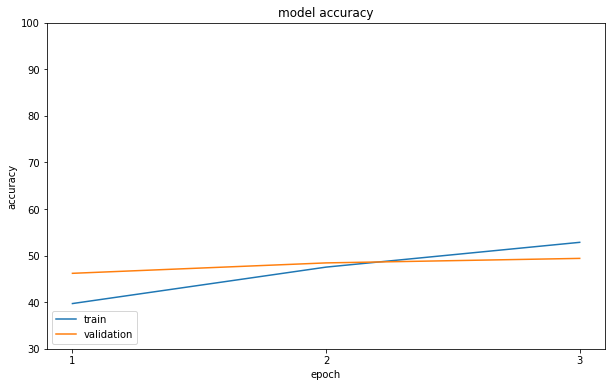

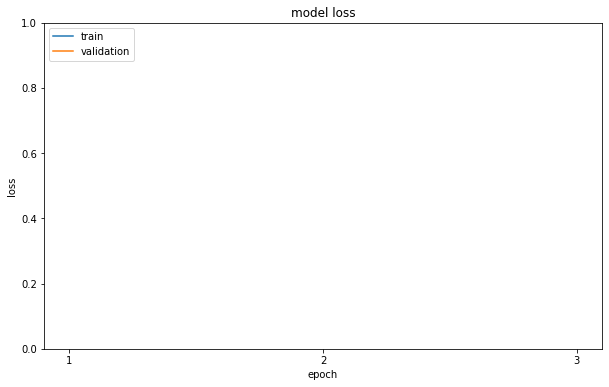

In [ ]:
history=np.load(HISTORY_PATH,allow_pickle=True)

# summarize history for accuracy
plt.rcParams["figure.figsize"] = (10,6)
e_arr = np.array([1,2,3])
plt.plot(e_arr, history[0]*100)
plt.plot(e_arr, history[2]*100)
plt.xticks(range(1, 4))
plt.ylim(30,100)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

# summarize history for loss
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(e_arr, history[1])
plt.plot(e_arr, history[3])
plt.xticks(range(1, 4))
plt.ylim(0,1)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score,roc_auc_score, classification_report, confusion_matrix
from sklearn import metrics
import seaborn as sns
# install: pip install --upgrade arabic-reshaper
import arabic_reshaper

# install: pip install python-bidi
from bidi.algorithm import get_display

y_test, y_pred = [label_list.index(label) for label in test['label'].values], preds
# classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

per_label = []
for lb in labels:
  per_label.append(get_display(arabic_reshaper.reshape(lb)))

In [ ]:
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test, preds)
auc = roc_auc_score(y_test, probs, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test, preds))

Accuracy: 0.47
F1: 0.4507215053094683
Auc: 0.84
Detail:
              precision    recall  f1-score   support

           0       0.24      0.57      0.34       197
           1       0.30      0.10      0.15       142
           2       0.52      0.91      0.66       179
           3       0.45      0.47      0.46       204
           4       0.85      0.80      0.82       222
           5       0.60      0.34      0.44       232
           6       0.48      0.10      0.16       126
           7       0.58      0.26      0.36       189

    accuracy                           0.47      1491
   macro avg       0.50      0.44      0.42      1491
weighted avg       0.52      0.47      0.45      1491



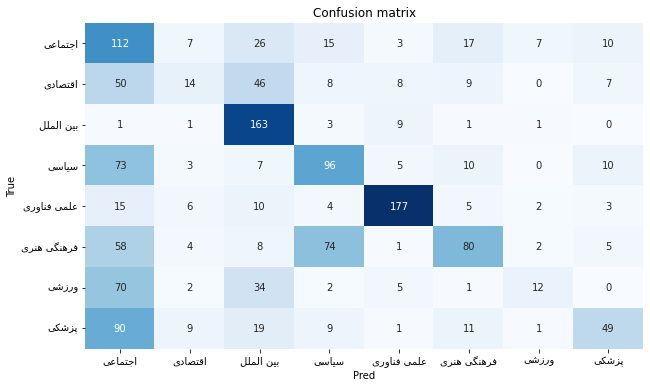

In [ ]:
## Plot confusion matrix
cm = confusion_matrix(y_test, preds)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=per_label, 
       yticklabels=per_label, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

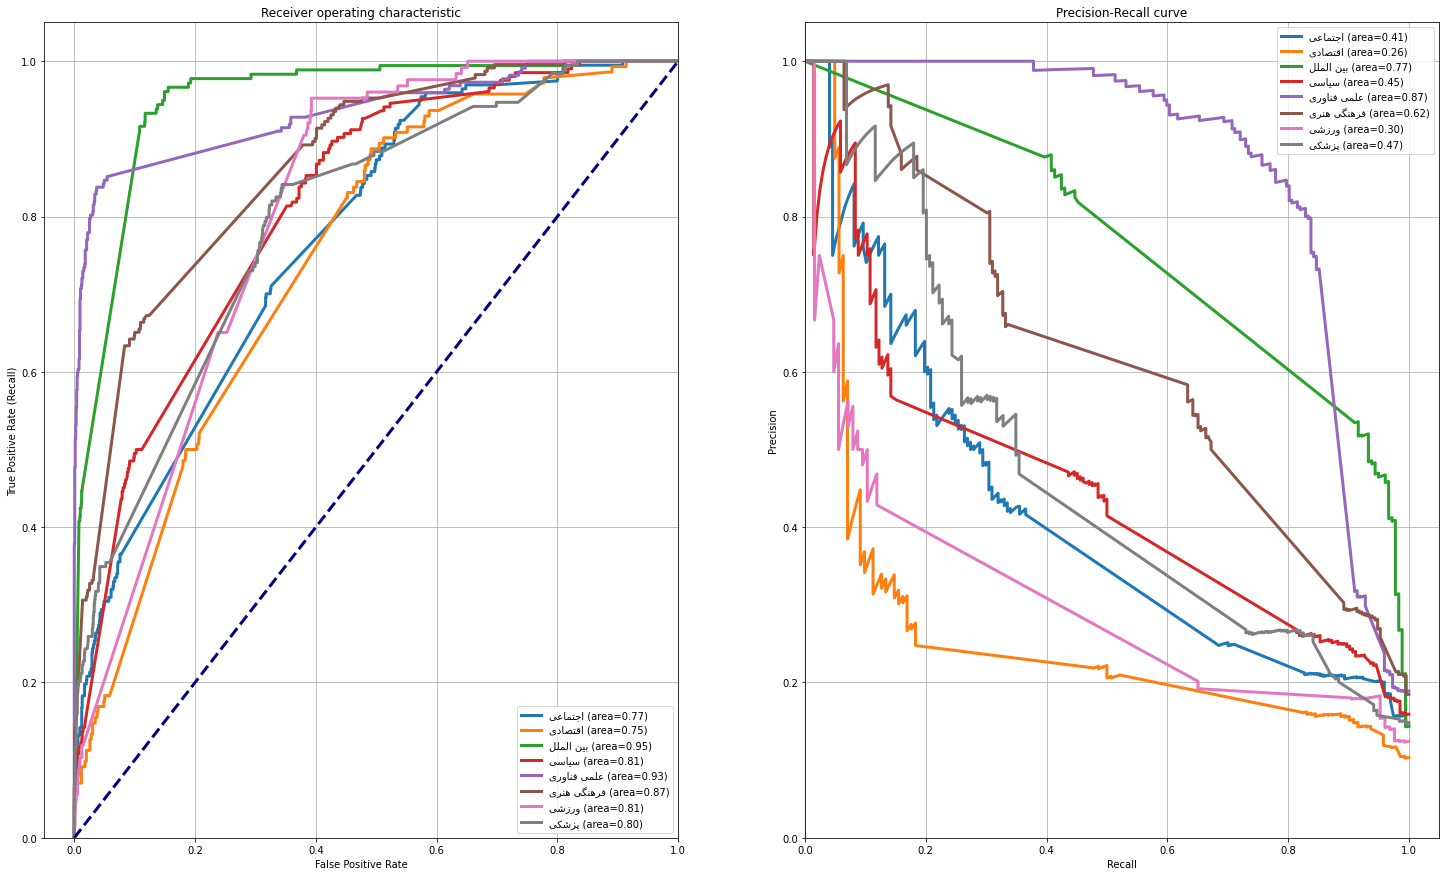

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,15))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           probs[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(per_label[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], probs[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(per_label[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## config1 on ds2

### Model

In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torch;
torch.__version__

'1.11.0+cu113'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


### Config

In [ ]:
# general config
MAX_LEN = 512
TRAIN_BATCH_SIZE = 10
VALID_BATCH_SIZE = 10
TEST_BATCH_SIZE = 10

EPOCHS = 3
EEVERY_EPOCH = 1207
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/drive/MyDrive/payannameF/models/BERT/'+datasetname+'model.bin'
HISTORY_PATH = '/content/drive/MyDrive/payannameF/models/BERT/'+datasetname+'history.npy'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
# create a key finder based on label 2 id and id to label

label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'اجتماعی': 0, 'اقتصادی': 1, 'بین الملل': 2, 'سیاسی': 3, 'علمی فناوری': 4, 'فرهنگی هنری': 5, 'ورزشی': 6, 'پزشکی': 7}
id2label: {0: 'اجتماعی', 1: 'اقتصادی', 2: 'بین الملل', 3: 'سیاسی', 4: 'علمی فناوری', 5: 'فرهنگی هنری', 6: 'ورزشی', 7: 'پزشکی'}


In [ ]:
# setup the tokenizer and configuration
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "\u0627\u062c\u062a\u0645\u0627\u0639\u06cc",
    "1": "\u0627\u0642\u062a\u0635\u0627\u062f\u06cc",
    "2": "\u0628\u06cc\u0646 \u0627\u0644\u0645\u0644\u0644",
    "3": "\u0633\u06cc\u0627\u0633\u06cc",
    "4": "\u0639\u0644\u0645\u06cc \u0641\u0646\u0627\u0648\u0631\u06cc",
    "5": "\u0641\u0631\u0647\u0646\u06af\u06cc \u0647\u0646\u0631\u06cc",
    "6": "\u0648\u0631\u0632\u0634\u06cc",
    "7": "\u067e\u0632\u0634\u06a9\u06cc"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "\u0627\u062c\u062a\u0645\u0627\u0639\u06cc": 0,
    "\u0627\u0642\u062a\u0635\u0627\u062f\u06cc": 1,
    "\u0628\u06cc\u0646 \u0627\u0644\u0645\u0644\u0644": 2,
    "\u0633\u06cc\u0627\u0633\u06cc": 3,
    "\u0639\u0644\u0645\u06cc \u0641\u0646\u0627\u0648\

In [ ]:
class TaaghcheDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Taaghche. """

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=512):
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
    
    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = TaaghcheDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        label_list=label_list)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
label_list = labels
train_data_loader = create_data_loader(train['news'].to_numpy(), train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['news'].to_numpy(), valid['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['news'].to_numpy(), None, tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

In [ ]:
import torch, gc
 
gc.collect()
torch.cuda.empty_cache()
 
!nvidia-smi

Fri May  6 08:15:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    74W / 149W |    145MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH,return_dict=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids)
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits 

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
pt_model = None

!nvidia-smi

Fri May  6 08:15:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    74W / 149W |    145MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.SentimentModel'>


In [ ]:
!nvidia-smi

Fri May  6 08:16:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    74W / 149W |   1247MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Train

In [ ]:
def simple_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = simple_accuracy(y_true, y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss


def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):
            
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            # calculate the batch loss
            loss = loss_fn(outputs, targets)

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)
    
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss


def train_op(model, 
             data_loader, 
             loss_fn, 
             optimizer, 
             scheduler, 
             step=0, 
             print_every_step=100, 
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None, 
             clip=0.0):
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
        # convert output probabilities to predicted class
        _, preds = torch.max(outputs, dim=1)

        # calculate the batch loss
        loss = loss_fn(outputs, targets)

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min

In [ ]:
optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

step = 0
eval_loss_min = np.Inf
#history = collections.defaultdict(list)
history=[[],[],[],[]]

def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history[0].append(train_score['acc'])
    history[1].append(train_loss)
    history[2].append(eval_score['acc'])
    history[3].append(eval_loss)

np.save(HISTORY_PATH, history)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Epochs... :   0%|          | 0/3 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 1/3...Step: 1207...Train Loss: 0.204786...Train Acc: 0.940...Valid Loss: 0.116953...Valid Acc: 0.969...
Validation loss decreased (inf --> 0.116953).  Saving model ...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 2/3...Step: 2414...Train Loss: 0.055228...Train Acc: 0.984...Valid Loss: 0.102470...Valid Acc: 0.974...
Validation loss decreased (0.116953 --> 0.102470).  Saving model ...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 3/3...Step: 3621...Train Loss: 0.019259...Train Acc: 0.995...Valid Loss: 0.110510...Valid Acc: 0.970...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

### Predict

In [ ]:
def predict(model, news, tokenizer, max_len=512, batch_size=10):
    data_loader = create_data_loader(news, None, tokenizer, max_len, batch_size, None)
    
    predictions = []
    prediction_probs = []

    
    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

In [ ]:
test_comments = test['news'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=512, batch_size=10)

print(preds.shape, probs.shape)

  0%|          | 0/150 [00:00<?, ?it/s]

(1491,) (1491, 8)


### Results

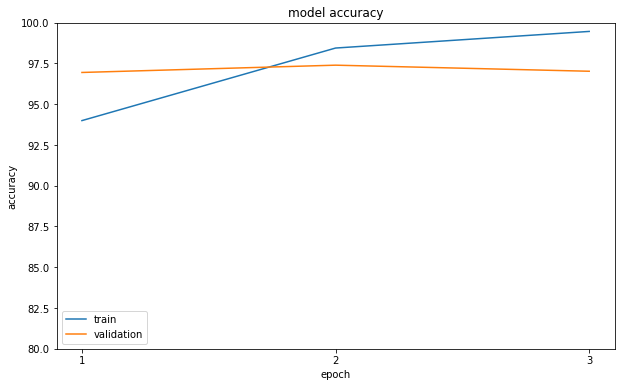

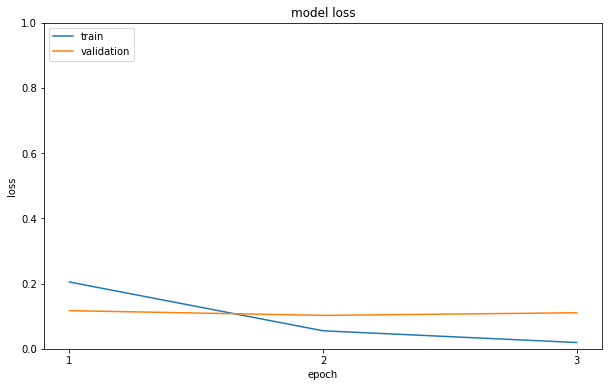

In [ ]:
history=np.load(HISTORY_PATH,allow_pickle=True)

# summarize history for accuracy
plt.rcParams["figure.figsize"] = (10,6)
e_arr = np.array([1,2,3])
plt.plot(e_arr, history[0]*100)
plt.plot(e_arr, history[2]*100)
plt.xticks(range(1, 4))
plt.ylim(80,100)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

# summarize history for loss
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(e_arr, history[1])
plt.plot(e_arr, history[3])
plt.xticks(range(1, 4))
plt.ylim(0,1)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score,roc_auc_score, classification_report, confusion_matrix
from sklearn import metrics
import seaborn as sns
# install: pip install --upgrade arabic-reshaper
import arabic_reshaper

# install: pip install python-bidi
from bidi.algorithm import get_display

y_test, y_pred = [label_list.index(label) for label in test['label'].values], preds
# classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

per_label = []
for lb in labels:
  per_label.append(get_display(arabic_reshaper.reshape(lb)))

In [ ]:
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test, preds)
auc = roc_auc_score(y_test, probs, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test, preds))

Accuracy: 0.97
F1: 0.9744588605035257
Auc: 1.0
Detail:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       197
           1       0.98      0.95      0.96       142
           2       0.99      0.99      0.99       179
           3       0.98      0.94      0.96       204
           4       0.98      0.99      0.98       222
           5       0.97      0.99      0.98       232
           6       0.99      0.99      0.99       126
           7       0.95      0.98      0.97       189

    accuracy                           0.97      1491
   macro avg       0.98      0.97      0.97      1491
weighted avg       0.97      0.97      0.97      1491



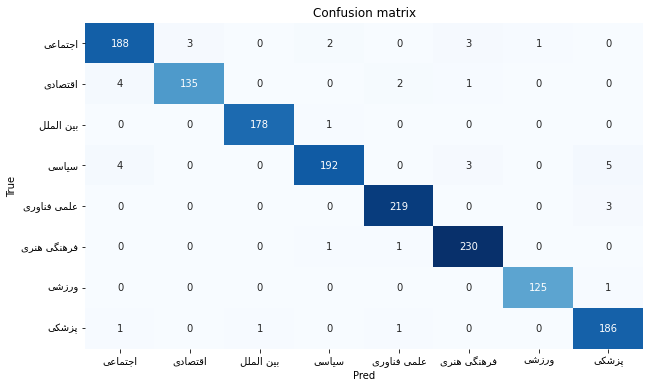

In [ ]:
## Plot confusion matrix
cm = confusion_matrix(y_test, preds)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=per_label, 
       yticklabels=per_label, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

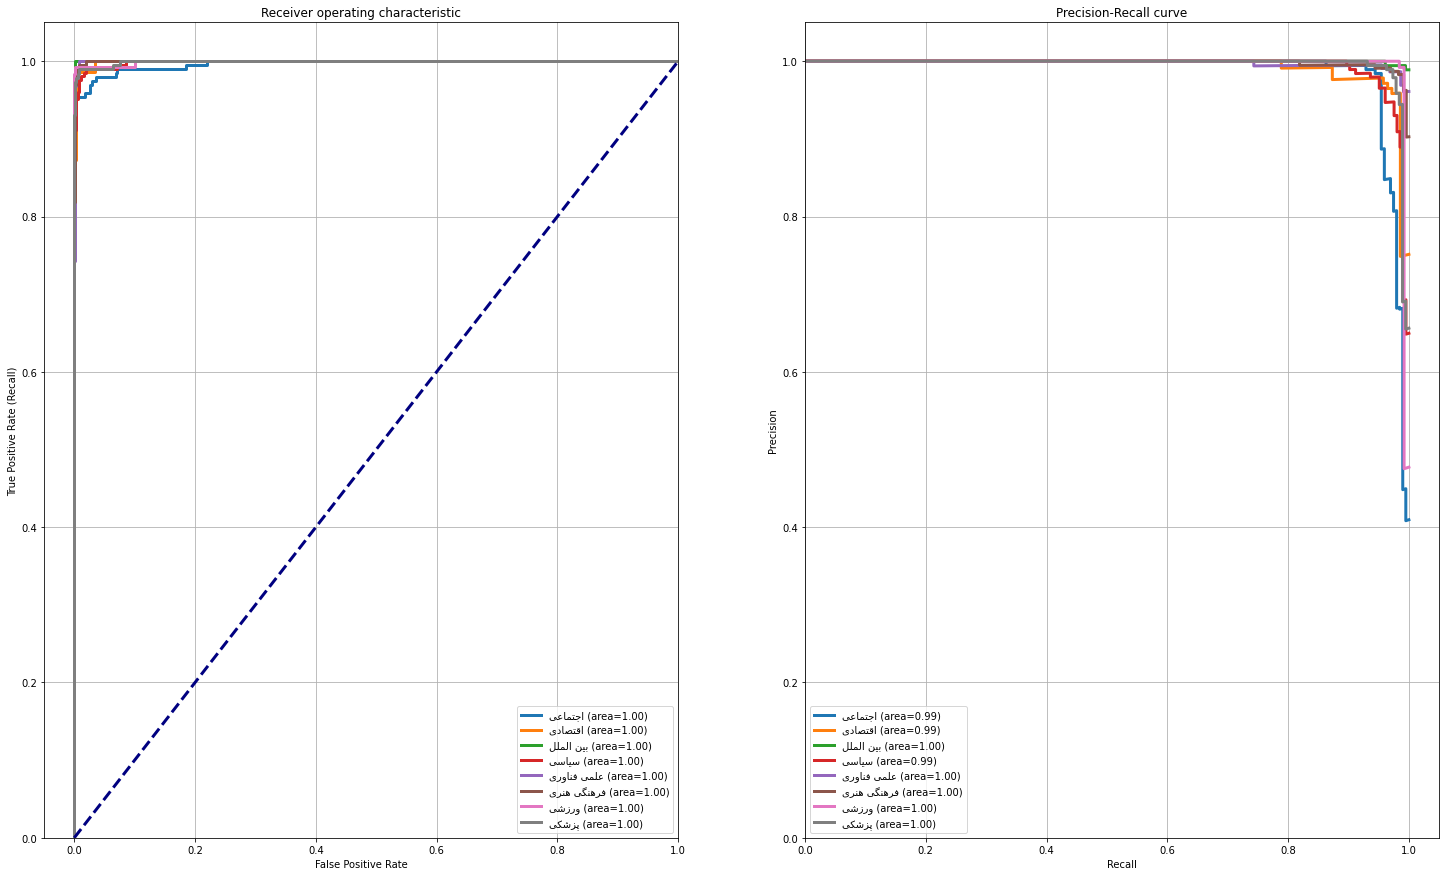

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,15))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           probs[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(per_label[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], probs[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(per_label[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## config2 on ds2

### Model

In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torch;
torch.__version__

'1.11.0+cu113'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


### Config

In [ ]:
# general config
MAX_LEN = 50
TRAIN_BATCH_SIZE = 10
VALID_BATCH_SIZE = 10
TEST_BATCH_SIZE = 10

EPOCHS = 3
EEVERY_EPOCH = 1207
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/drive/MyDrive/payannameF/models/BERT/'+datasetname+'model.bin'
HISTORY_PATH = '/content/drive/MyDrive/payannameF/models/BERT/'+datasetname+'history.npy'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
# create a key finder based on label 2 id and id to label

label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'اجتماعی': 0, 'اقتصادی': 1, 'بین الملل': 2, 'سیاسی': 3, 'علمی فناوری': 4, 'فرهنگی هنری': 5, 'ورزشی': 6, 'پزشکی': 7}
id2label: {0: 'اجتماعی', 1: 'اقتصادی', 2: 'بین الملل', 3: 'سیاسی', 4: 'علمی فناوری', 5: 'فرهنگی هنری', 6: 'ورزشی', 7: 'پزشکی'}


In [ ]:
# setup the tokenizer and configuration
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "\u0627\u062c\u062a\u0645\u0627\u0639\u06cc",
    "1": "\u0627\u0642\u062a\u0635\u0627\u062f\u06cc",
    "2": "\u0628\u06cc\u0646 \u0627\u0644\u0645\u0644\u0644",
    "3": "\u0633\u06cc\u0627\u0633\u06cc",
    "4": "\u0639\u0644\u0645\u06cc \u0641\u0646\u0627\u0648\u0631\u06cc",
    "5": "\u0641\u0631\u0647\u0646\u06af\u06cc \u0647\u0646\u0631\u06cc",
    "6": "\u0648\u0631\u0632\u0634\u06cc",
    "7": "\u067e\u0632\u0634\u06a9\u06cc"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "\u0627\u062c\u062a\u0645\u0627\u0639\u06cc": 0,
    "\u0627\u0642\u062a\u0635\u0627\u062f\u06cc": 1,
    "\u0628\u06cc\u0646 \u0627\u0644\u0645\u0644\u0644": 2,
    "\u0633\u06cc\u0627\u0633\u06cc": 3,
    "\u0639\u0644\u0645\u06cc \u0641\u0646\u0627\u0648\

In [ ]:
class TaaghcheDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Taaghche. """

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=512):
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
    
    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = TaaghcheDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        label_list=label_list)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
label_list = labels
train_data_loader = create_data_loader(train['news'].to_numpy(), train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['news'].to_numpy(), valid['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['news'].to_numpy(), None, tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

In [ ]:
import torch, gc
 
gc.collect()
torch.cuda.empty_cache()
 
!nvidia-smi

Sat May  7 12:47:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    59W / 149W |   3222MiB / 11441MiB |     52%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH,return_dict=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids)
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits 

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
pt_model = None

!nvidia-smi

Sat May  7 12:47:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    59W / 149W |   3222MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.SentimentModel'>


In [ ]:
!nvidia-smi

Sat May  7 12:47:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    59W / 149W |   3876MiB / 11441MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Train

In [ ]:
def simple_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = simple_accuracy(y_true, y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss


def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):
            
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            # calculate the batch loss
            loss = loss_fn(outputs, targets)

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)
    
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss


def train_op(model, 
             data_loader, 
             loss_fn, 
             optimizer, 
             scheduler, 
             step=0, 
             print_every_step=100, 
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None, 
             clip=0.0):
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
        # convert output probabilities to predicted class
        _, preds = torch.max(outputs, dim=1)

        # calculate the batch loss
        loss = loss_fn(outputs, targets)

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min

In [ ]:
optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

step = 0
eval_loss_min = np.Inf
#history = collections.defaultdict(list)
history=[[],[],[],[]]

def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history[0].append(train_score['acc'])
    history[1].append(train_loss)
    history[2].append(eval_score['acc'])
    history[3].append(eval_loss)

np.save(HISTORY_PATH, history)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Epochs... :   0%|          | 0/3 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 1/3...Step: 1207...Train Loss: 0.263358...Train Acc: 0.926...Valid Loss: 0.141616...Valid Acc: 0.964...
Validation loss decreased (inf --> 0.141616).  Saving model ...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 2/3...Step: 2414...Train Loss: 0.075506...Train Acc: 0.978...Valid Loss: 0.130920...Valid Acc: 0.966...
Validation loss decreased (0.141616 --> 0.130920).  Saving model ...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 3/3...Step: 3621...Train Loss: 0.033516...Train Acc: 0.991...Valid Loss: 0.148140...Valid Acc: 0.962...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

### Predict

In [ ]:
def predict(model, news, tokenizer, max_len=512, batch_size=10):
    data_loader = create_data_loader(news, None, tokenizer, max_len, batch_size, None)
    
    predictions = []
    prediction_probs = []

    
    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

In [ ]:
test_comments = test['news'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=50, batch_size=10)

print(preds.shape, probs.shape)

  0%|          | 0/150 [00:00<?, ?it/s]

(1491,) (1491, 8)


### Results

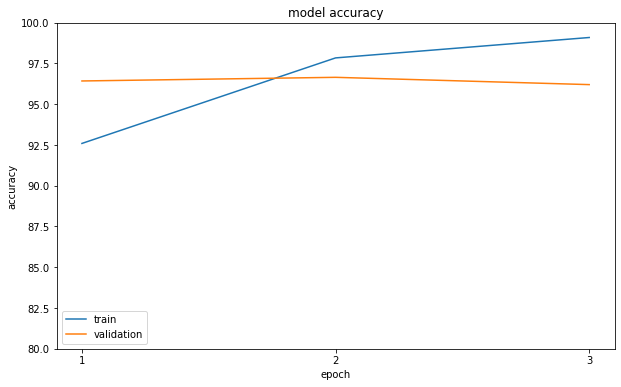

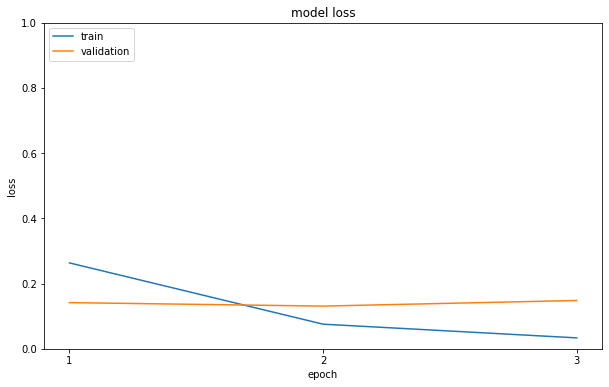

In [ ]:
history=np.load(HISTORY_PATH,allow_pickle=True)

# summarize history for accuracy
plt.rcParams["figure.figsize"] = (10,6)
e_arr = np.array([1,2,3])
plt.plot(e_arr, history[0]*100)
plt.plot(e_arr, history[2]*100)
plt.xticks(range(1, 4))
plt.ylim(80,100)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

# summarize history for loss
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(e_arr, history[1])
plt.plot(e_arr, history[3])
plt.xticks(range(1, 4))
plt.ylim(0,1)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score,roc_auc_score, classification_report
import seaborn as sns
# install: pip install --upgrade arabic-reshaper
import arabic_reshaper

# install: pip install python-bidi
from bidi.algorithm import get_display

y_test, y_pred = [label_list.index(label) for label in test['label'].values], preds
# classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

per_label = []
for lb in labels:
  per_label.append(get_display(arabic_reshaper.reshape(lb)))

In [ ]:
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test, preds)
auc = roc_auc_score(y_test, probs, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test, preds))

Accuracy: 0.96
F1: 0.9637275289170383
Auc: 1.0
Detail:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       197
           1       0.94      0.96      0.95       142
           2       0.98      0.99      0.98       179
           3       0.96      0.93      0.95       204
           4       0.98      0.95      0.96       222
           5       0.97      0.98      0.98       232
           6       0.98      0.99      0.99       126
           7       0.96      0.97      0.97       189

    accuracy                           0.96      1491
   macro avg       0.96      0.97      0.96      1491
weighted avg       0.96      0.96      0.96      1491



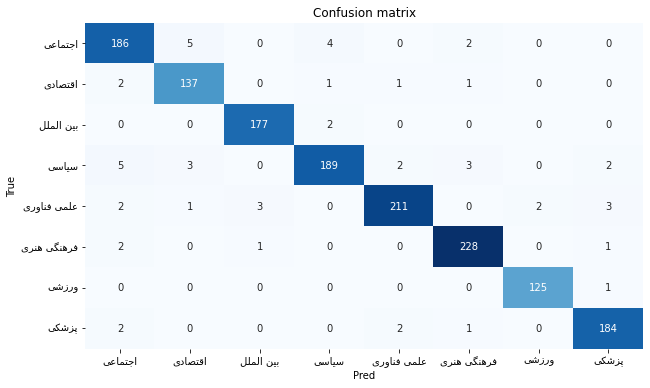

In [ ]:
from sklearn import metrics
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, preds)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=per_label, 
       yticklabels=per_label, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

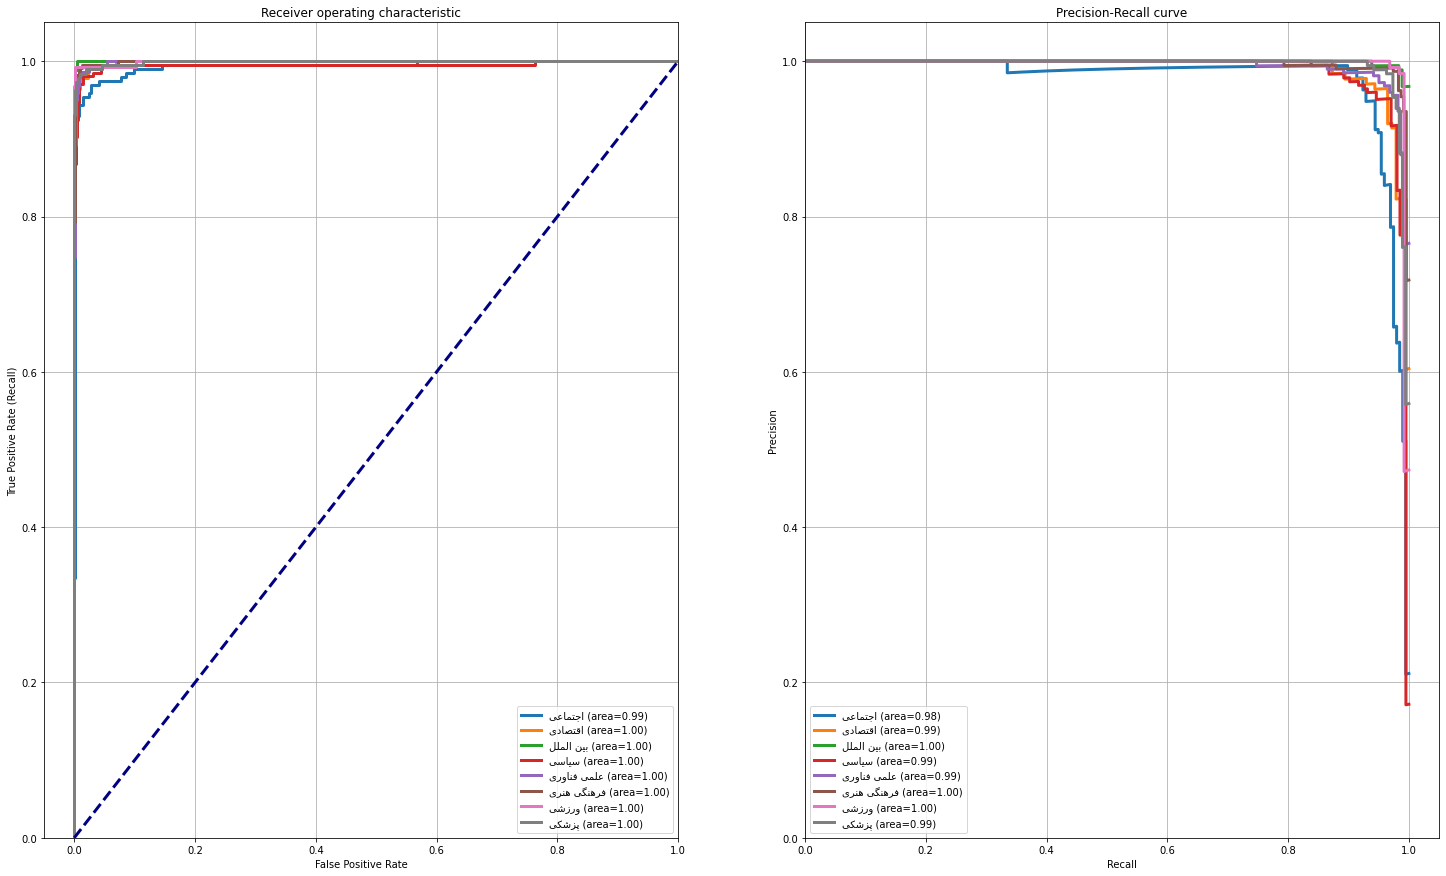

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,15))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           probs[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(per_label[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], probs[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(per_label[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## config3 on ds2

### Model

In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torch;
torch.__version__

'1.11.0+cu113'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


### Config

In [ ]:
# general config
MAX_LEN = 10
TRAIN_BATCH_SIZE = 10
VALID_BATCH_SIZE = 10
TEST_BATCH_SIZE = 10

EPOCHS = 3
EEVERY_EPOCH = 1207
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/drive/MyDrive/payannameF/models/BERT/'+datasetname+'model.bin'
HISTORY_PATH = '/content/drive/MyDrive/payannameF/models/BERT/'+datasetname+'history.npy'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
# create a key finder based on label 2 id and id to label

label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'اجتماعی': 0, 'اقتصادی': 1, 'بین الملل': 2, 'سیاسی': 3, 'علمی فناوری': 4, 'فرهنگی هنری': 5, 'ورزشی': 6, 'پزشکی': 7}
id2label: {0: 'اجتماعی', 1: 'اقتصادی', 2: 'بین الملل', 3: 'سیاسی', 4: 'علمی فناوری', 5: 'فرهنگی هنری', 6: 'ورزشی', 7: 'پزشکی'}


In [ ]:
# setup the tokenizer and configuration
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

Downloading:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440 [00:00<?, ?B/s]

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "\u0627\u062c\u062a\u0645\u0627\u0639\u06cc",
    "1": "\u0627\u0642\u062a\u0635\u0627\u062f\u06cc",
    "2": "\u0628\u06cc\u0646 \u0627\u0644\u0645\u0644\u0644",
    "3": "\u0633\u06cc\u0627\u0633\u06cc",
    "4": "\u0639\u0644\u0645\u06cc \u0641\u0646\u0627\u0648\u0631\u06cc",
    "5": "\u0641\u0631\u0647\u0646\u06af\u06cc \u0647\u0646\u0631\u06cc",
    "6": "\u0648\u0631\u0632\u0634\u06cc",
    "7": "\u067e\u0632\u0634\u06a9\u06cc"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "\u0627\u062c\u062a\u0645\u0627\u0639\u06cc": 0,
    "\u0627\u0642\u062a\u0635\u0627\u062f\u06cc": 1,
    "\u0628\u06cc\u0646 \u0627\u0644\u0645\u0644\u0644": 2,
    "\u0633\u06cc\u0627\u0633\u06cc": 3,
    "\u0639\u0644\u0645\u06cc \u0641\u0646\u0627\u0648\

In [ ]:
class TaaghcheDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Taaghche. """

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=512):
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
    
    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = TaaghcheDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        label_list=label_list)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
label_list = labels
train_data_loader = create_data_loader(train['news'].to_numpy(), train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['news'].to_numpy(), valid['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['news'].to_numpy(), None, tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

In [ ]:
import torch, gc
 
gc.collect()
torch.cuda.empty_cache()
 
!nvidia-smi

Sat May  7 11:21:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    58W / 149W |    145MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH,return_dict=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids)
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits 

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
pt_model = None

!nvidia-smi

Sat May  7 11:21:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    58W / 149W |    145MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Downloading:   0%|          | 0.00/624M [00:00<?, ?B/s]

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.SentimentModel'>


In [ ]:
!nvidia-smi

Sat May  7 11:22:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    58W / 149W |   1247MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Train

In [ ]:
def simple_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = simple_accuracy(y_true, y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss


def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):
            
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            # calculate the batch loss
            loss = loss_fn(outputs, targets)

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)
    
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss


def train_op(model, 
             data_loader, 
             loss_fn, 
             optimizer, 
             scheduler, 
             step=0, 
             print_every_step=100, 
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None, 
             clip=0.0):
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
        # convert output probabilities to predicted class
        _, preds = torch.max(outputs, dim=1)

        # calculate the batch loss
        loss = loss_fn(outputs, targets)

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min

In [ ]:
optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

step = 0
eval_loss_min = np.Inf
#history = collections.defaultdict(list)
history=[[],[],[],[]]

def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history[0].append(train_score['acc'])
    history[1].append(train_loss)
    history[2].append(eval_score['acc'])
    history[3].append(eval_loss)

np.save(HISTORY_PATH, history)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Epochs... :   0%|          | 0/3 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 1/3...Step: 1207...Train Loss: 0.402700...Train Acc: 0.878...Valid Loss: 0.268524...Valid Acc: 0.925...
Validation loss decreased (inf --> 0.268524).  Saving model ...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 2/3...Step: 2414...Train Loss: 0.161511...Train Acc: 0.952...Valid Loss: 0.278697...Valid Acc: 0.923...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 3/3...Step: 3621...Train Loss: 0.083991...Train Acc: 0.976...Valid Loss: 0.293350...Valid Acc: 0.928...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

### Predict

In [ ]:
def predict(model, news, tokenizer, max_len=512, batch_size=10):
    data_loader = create_data_loader(news, None, tokenizer, max_len, batch_size, None)
    
    predictions = []
    prediction_probs = []

    
    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

In [ ]:
test_comments = test['news'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=10, batch_size=10)

print(preds.shape, probs.shape)

  0%|          | 0/150 [00:00<?, ?it/s]

(1491,) (1491, 8)


### Results

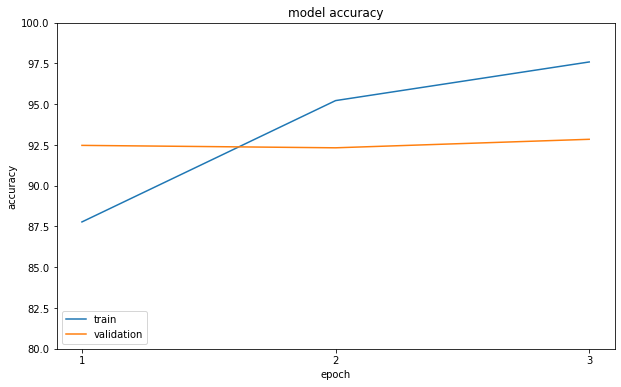

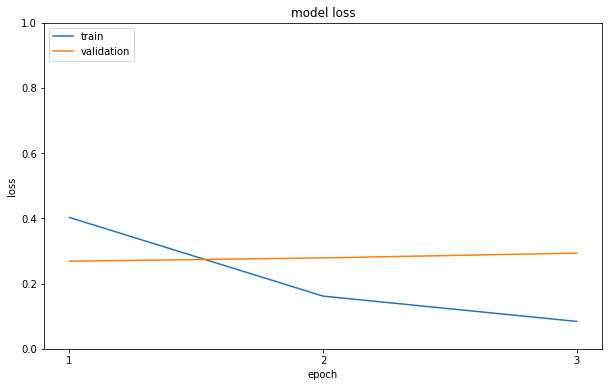

In [ ]:
history=np.load(HISTORY_PATH,allow_pickle=True)

# summarize history for accuracy
plt.rcParams["figure.figsize"] = (10,6)
e_arr = np.array([1,2,3])
plt.plot(e_arr, history[0]*100)
plt.plot(e_arr, history[2]*100)
plt.xticks(range(1, 4))
plt.ylim(80,100)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

# summarize history for loss
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(e_arr, history[1])
plt.plot(e_arr, history[3])
plt.xticks(range(1, 4))
plt.ylim(0,1)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score,roc_auc_score, classification_report, confusion_matrix
from sklearn import metrics
import seaborn as sns
# install: pip install --upgrade arabic-reshaper
import arabic_reshaper

# install: pip install python-bidi
from bidi.algorithm import get_display

y_test, y_pred = [label_list.index(label) for label in test['label'].values], preds
# classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

per_label = []
for lb in labels:
  per_label.append(get_display(arabic_reshaper.reshape(lb)))

In [ ]:
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test, preds)
auc = roc_auc_score(y_test, probs, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test, preds))

Accuracy: 0.92
F1: 0.9219910930439035
Auc: 0.99
Detail:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       197
           1       0.91      0.90      0.91       142
           2       0.96      0.98      0.97       179
           3       0.91      0.89      0.90       204
           4       0.93      0.90      0.92       222
           5       0.94      0.94      0.94       232
           6       0.95      0.98      0.96       126
           7       0.88      0.95      0.91       189

    accuracy                           0.92      1491
   macro avg       0.92      0.92      0.92      1491
weighted avg       0.92      0.92      0.92      1491



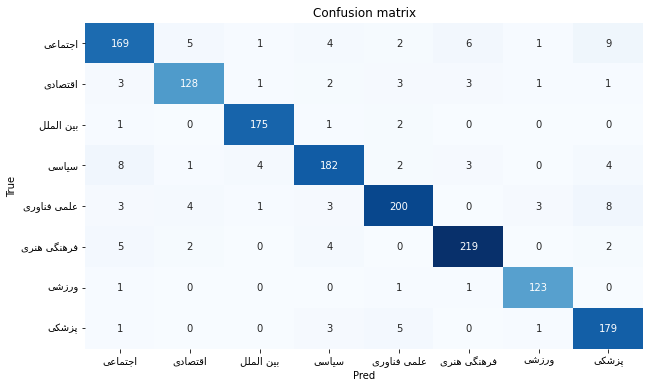

In [ ]:
## Plot confusion matrix
cm = confusion_matrix(y_test, preds)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=per_label, 
       yticklabels=per_label, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

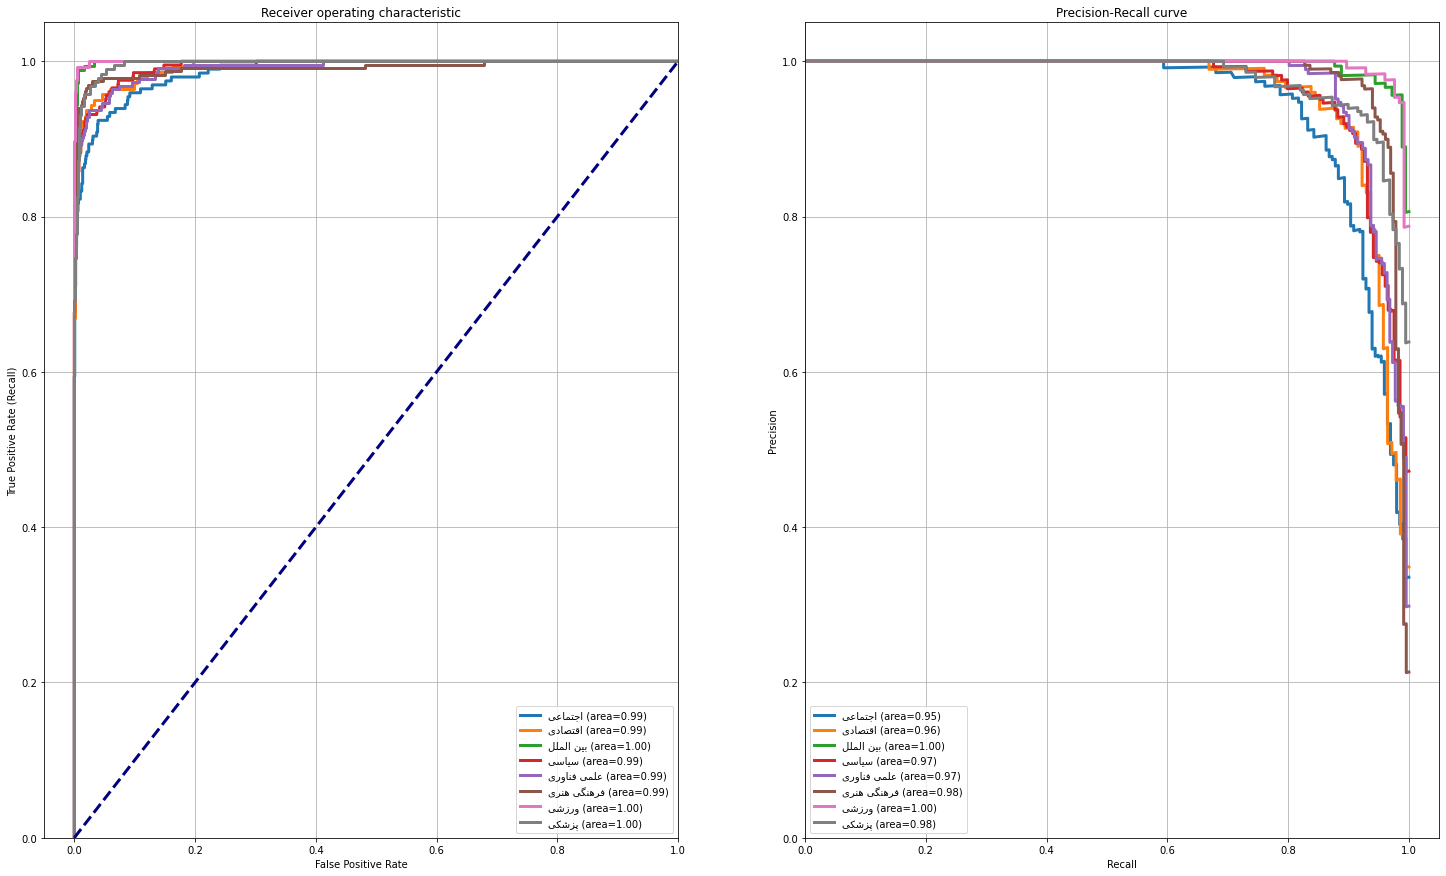

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,15))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           probs[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(per_label[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], probs[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(per_label[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## config4 on ds2

### Model

In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torch;
torch.__version__

'1.11.0+cu113'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


### Config

In [ ]:
# general config
MAX_LEN = 5
TRAIN_BATCH_SIZE = 10
VALID_BATCH_SIZE = 10
TEST_BATCH_SIZE = 10

EPOCHS = 3
EEVERY_EPOCH = 1207
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/drive/MyDrive/payannameF/models/BERT/'+datasetname+'model.bin'
HISTORY_PATH = '/content/drive/MyDrive/payannameF/models/BERT/'+datasetname+'history.npy'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
# create a key finder based on label 2 id and id to label

label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'اجتماعی': 0, 'اقتصادی': 1, 'بین الملل': 2, 'سیاسی': 3, 'علمی فناوری': 4, 'فرهنگی هنری': 5, 'ورزشی': 6, 'پزشکی': 7}
id2label: {0: 'اجتماعی', 1: 'اقتصادی', 2: 'بین الملل', 3: 'سیاسی', 4: 'علمی فناوری', 5: 'فرهنگی هنری', 6: 'ورزشی', 7: 'پزشکی'}


In [ ]:
# setup the tokenizer and configuration
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "\u0627\u062c\u062a\u0645\u0627\u0639\u06cc",
    "1": "\u0627\u0642\u062a\u0635\u0627\u062f\u06cc",
    "2": "\u0628\u06cc\u0646 \u0627\u0644\u0645\u0644\u0644",
    "3": "\u0633\u06cc\u0627\u0633\u06cc",
    "4": "\u0639\u0644\u0645\u06cc \u0641\u0646\u0627\u0648\u0631\u06cc",
    "5": "\u0641\u0631\u0647\u0646\u06af\u06cc \u0647\u0646\u0631\u06cc",
    "6": "\u0648\u0631\u0632\u0634\u06cc",
    "7": "\u067e\u0632\u0634\u06a9\u06cc"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "\u0627\u062c\u062a\u0645\u0627\u0639\u06cc": 0,
    "\u0627\u0642\u062a\u0635\u0627\u062f\u06cc": 1,
    "\u0628\u06cc\u0646 \u0627\u0644\u0645\u0644\u0644": 2,
    "\u0633\u06cc\u0627\u0633\u06cc": 3,
    "\u0639\u0644\u0645\u06cc \u0641\u0646\u0627\u0648\

In [ ]:
class TaaghcheDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Taaghche. """

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=512):
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
    
    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = TaaghcheDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        label_list=label_list)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
label_list = labels
train_data_loader = create_data_loader(train['news'].to_numpy(), train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['news'].to_numpy(), valid['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['news'].to_numpy(), None, tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

In [ ]:
import torch, gc
 
gc.collect()
torch.cuda.empty_cache()
 
!nvidia-smi

Sat May  7 11:44:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    59W / 149W |   3224MiB / 11441MiB |     24%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH,return_dict=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids)
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits 

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
pt_model = None

!nvidia-smi

Sat May  7 11:44:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    59W / 149W |   3224MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.SentimentModel'>


In [ ]:
!nvidia-smi

Sat May  7 11:44:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    60W / 149W |   3878MiB / 11441MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Train

In [ ]:
def simple_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = simple_accuracy(y_true, y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss


def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):
            
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            # calculate the batch loss
            loss = loss_fn(outputs, targets)

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)
    
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss


def train_op(model, 
             data_loader, 
             loss_fn, 
             optimizer, 
             scheduler, 
             step=0, 
             print_every_step=100, 
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None, 
             clip=0.0):
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
        # convert output probabilities to predicted class
        _, preds = torch.max(outputs, dim=1)

        # calculate the batch loss
        loss = loss_fn(outputs, targets)

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min

In [ ]:
optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

step = 0
eval_loss_min = np.Inf
#history = collections.defaultdict(list)
history=[[],[],[],[]]

def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history[0].append(train_score['acc'])
    history[1].append(train_loss)
    history[2].append(eval_score['acc'])
    history[3].append(eval_loss)

np.save(HISTORY_PATH, history)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Epochs... :   0%|          | 0/3 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 1/3...Step: 1207...Train Loss: 0.833943...Train Acc: 0.700...Valid Loss: 0.645996...Valid Acc: 0.753...
Validation loss decreased (inf --> 0.645996).  Saving model ...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 2/3...Step: 2414...Train Loss: 0.576952...Train Acc: 0.787...Valid Loss: 0.637367...Valid Acc: 0.776...
Validation loss decreased (0.645996 --> 0.637367).  Saving model ...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Training... :   0%|          | 0/1207 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 3/3...Step: 3621...Train Loss: 0.447275...Train Acc: 0.831...Valid Loss: 0.669733...Valid Acc: 0.776...


Evaluation... :   0%|          | 0/135 [00:00<?, ?it/s]

### Predict

In [ ]:
def predict(model, news, tokenizer, max_len=512, batch_size=10):
    data_loader = create_data_loader(news, None, tokenizer, max_len, batch_size, None)
    
    predictions = []
    prediction_probs = []

    
    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

In [ ]:
test_comments = test['news'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=5, batch_size=10)

print(preds.shape, probs.shape)

  0%|          | 0/150 [00:00<?, ?it/s]

(1491,) (1491, 8)


### Results

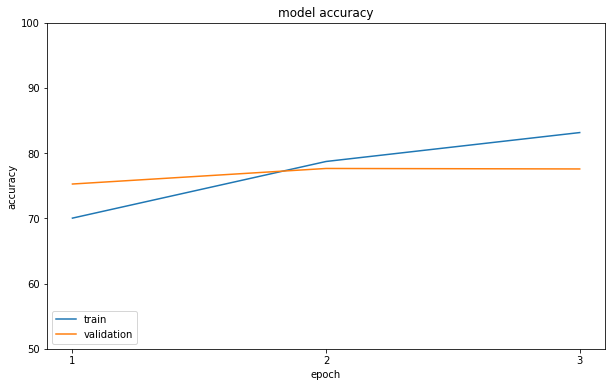

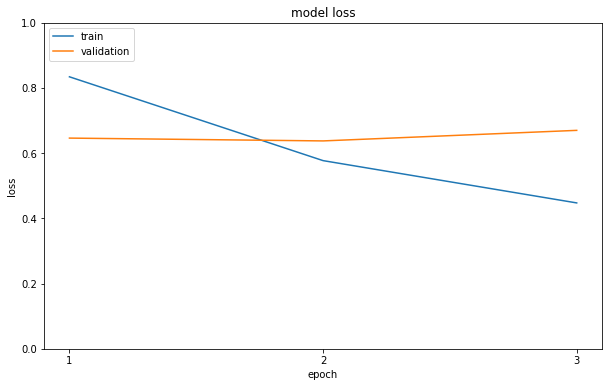

In [ ]:
history=np.load(HISTORY_PATH,allow_pickle=True)

# summarize history for accuracy
plt.rcParams["figure.figsize"] = (10,6)
e_arr = np.array([1,2,3])
plt.plot(e_arr, history[0]*100)
plt.plot(e_arr, history[2]*100)
plt.xticks(range(1, 4))
plt.ylim(50,100)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

# summarize history for loss
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(e_arr, history[1])
plt.plot(e_arr, history[3])
plt.xticks(range(1, 4))
plt.ylim(0,1)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score,roc_auc_score, classification_report, confusion_matrix
from sklearn import metrics
import seaborn as sns
# install: pip install --upgrade arabic-reshaper
import arabic_reshaper

# install: pip install python-bidi
from bidi.algorithm import get_display

y_test, y_pred = [label_list.index(label) for label in test['label'].values], preds
# classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

per_label = []
for lb in labels:
  per_label.append(get_display(arabic_reshaper.reshape(lb)))

In [ ]:
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test, preds)
auc = roc_auc_score(y_test, probs, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test, preds))

Accuracy: 0.77
F1: 0.7708182089706347
Auc: 0.96
Detail:
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       197
           1       0.78      0.80      0.79       142
           2       0.95      0.96      0.95       179
           3       0.85      0.74      0.79       204
           4       0.83      0.85      0.84       222
           5       0.63      0.88      0.73       232
           6       0.86      0.76      0.81       126
           7       0.72      0.61      0.66       189

    accuracy                           0.77      1491
   macro avg       0.79      0.77      0.77      1491
weighted avg       0.78      0.77      0.77      1491



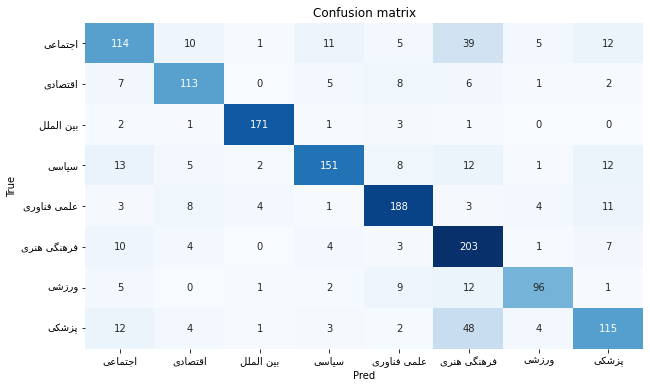

In [ ]:
## Plot confusion matrix
cm = confusion_matrix(y_test, preds)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=per_label, 
       yticklabels=per_label, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

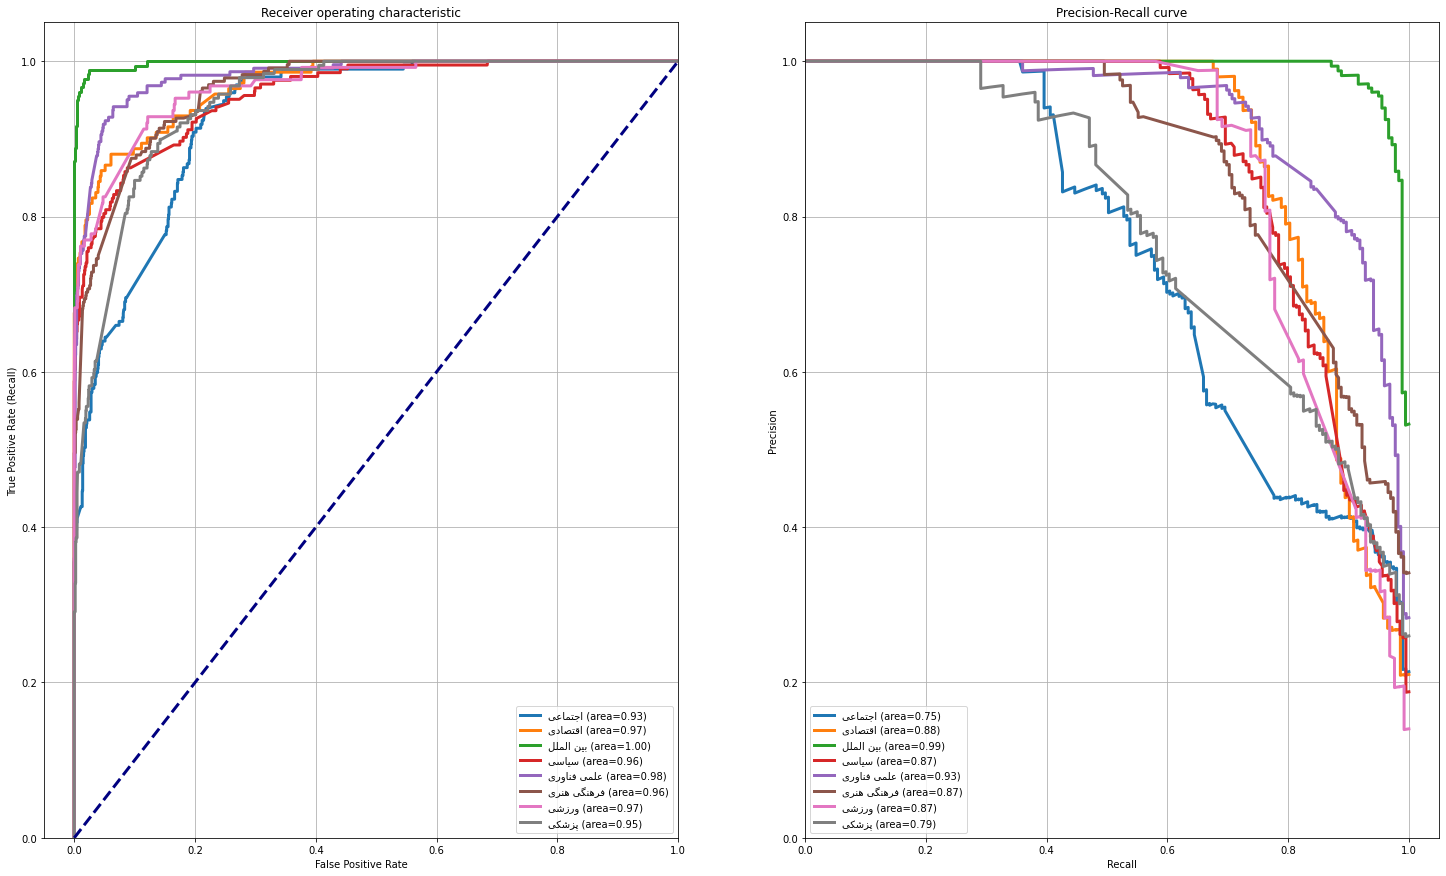

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,15))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           probs[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(per_label[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], probs[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(per_label[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# NN_models

## CNN_BILSTM config100 on ds1

### train

In [ ]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_size, weights=[word_vector_l], input_length=maxlim, trainable=True, mask_zero=True))
model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=None, padding="valid"))
model.add(Dropout(0.5, seed=100))
model.add(Bidirectional(LSTM(64, activation="tanh", recurrent_activation="sigmoid", dropout=0.0, recurrent_dropout=0.0)))
model.add(Dropout(0.5, seed=100))
model.add(Dense(y_train_m.shape[1], activation='sigmoid'))

print(model.summary())
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint("/content/drive/MyDrive/best_model.h5", monitor='val_accuracy', mode='max',
                              verbose=1, save_best_only=True)

print('Training model...')
history = model.fit(x_train_m, y_train_m, epochs=50, batch_size=64,
                validation_data=(x_valid_m, y_valid_m), callbacks=[es,mc], verbose=1)

with open("/content/drive/MyDrive/history.h5", 'wb') as f2:
        pickle.dump(history.history, f2)
        f2.close()

### predict

In [ ]:
model=load_model("/content/drive/MyDrive/best_model.h5")

In [ ]:
predictions=[]
prediction=[]

predictions=model.predict(x_test_m[:])

prediction = np.zeros_like(predictions, dtype=int)

predictions=predictions.tolist()
prediction=prediction.tolist()

for i in range(len(predictions)):
  prediction[i][predictions[i].index(max(predictions[i]))]=1

prediction = np.array(prediction)

y_test_array = y_test_m.argmax(axis=1)

per_label = []
for lb in labels:
  per_label.append(get_display(arabic_reshaper.reshape(lb)))

### Results

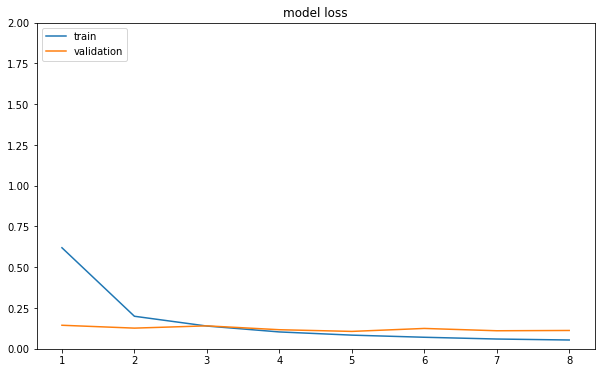

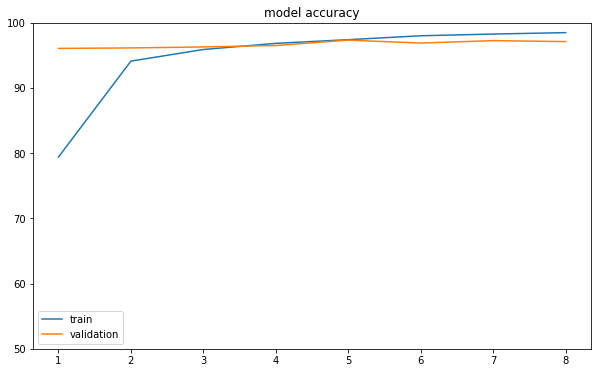

In [ ]:
with open("/content/drive/MyDrive/history.h5", "rb") as f:
    hist = pickle.load(f)

# Plotting Loss and Accuracy Graphs
plt.rcParams["figure.figsize"] = (10,6)
e_arr = np.array(range(1,9))
plt.plot(e_arr, hist['loss'])
plt.plot(e_arr, hist['val_loss'])
# plt.xticks(range(1, 14))
plt.ylim(0,2)
plt.title('model loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(e_arr, np.array(hist['accuracy'])*100)
plt.plot(e_arr, np.array(hist['val_accuracy'])*100)
# plt.xticks(range(1, 4))
plt.ylim(50,100)
plt.title('model accuracy')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

In [ ]:
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test_m, prediction)
auc = metrics.roc_auc_score(y_test_m, predictions, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print(f'F1: {f1_score(y_test_m, prediction, average="weighted")}')
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test_m, prediction))
  

Accuracy: 0.96
F1: 0.9617580716190774
Auc: 1.0
Detail:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       197
           1       0.94      0.95      0.94       142
           2       0.98      0.98      0.98       179
           3       0.98      0.93      0.95       204
           4       0.99      0.96      0.97       222
           5       0.95      1.00      0.97       232
           6       0.99      0.98      0.98       126
           7       0.94      0.97      0.95       189

   micro avg       0.96      0.96      0.96      1491
   macro avg       0.96      0.96      0.96      1491
weighted avg       0.96      0.96      0.96      1491
 samples avg       0.96      0.96      0.96      1491



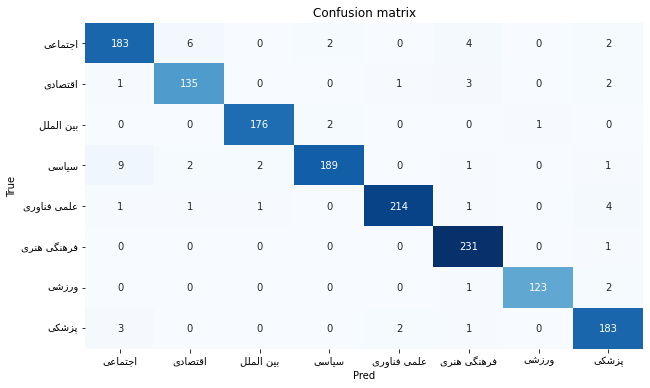

In [ ]:
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_array, np.array(prediction).argmax(axis=1))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=per_label, 
       yticklabels=per_label, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

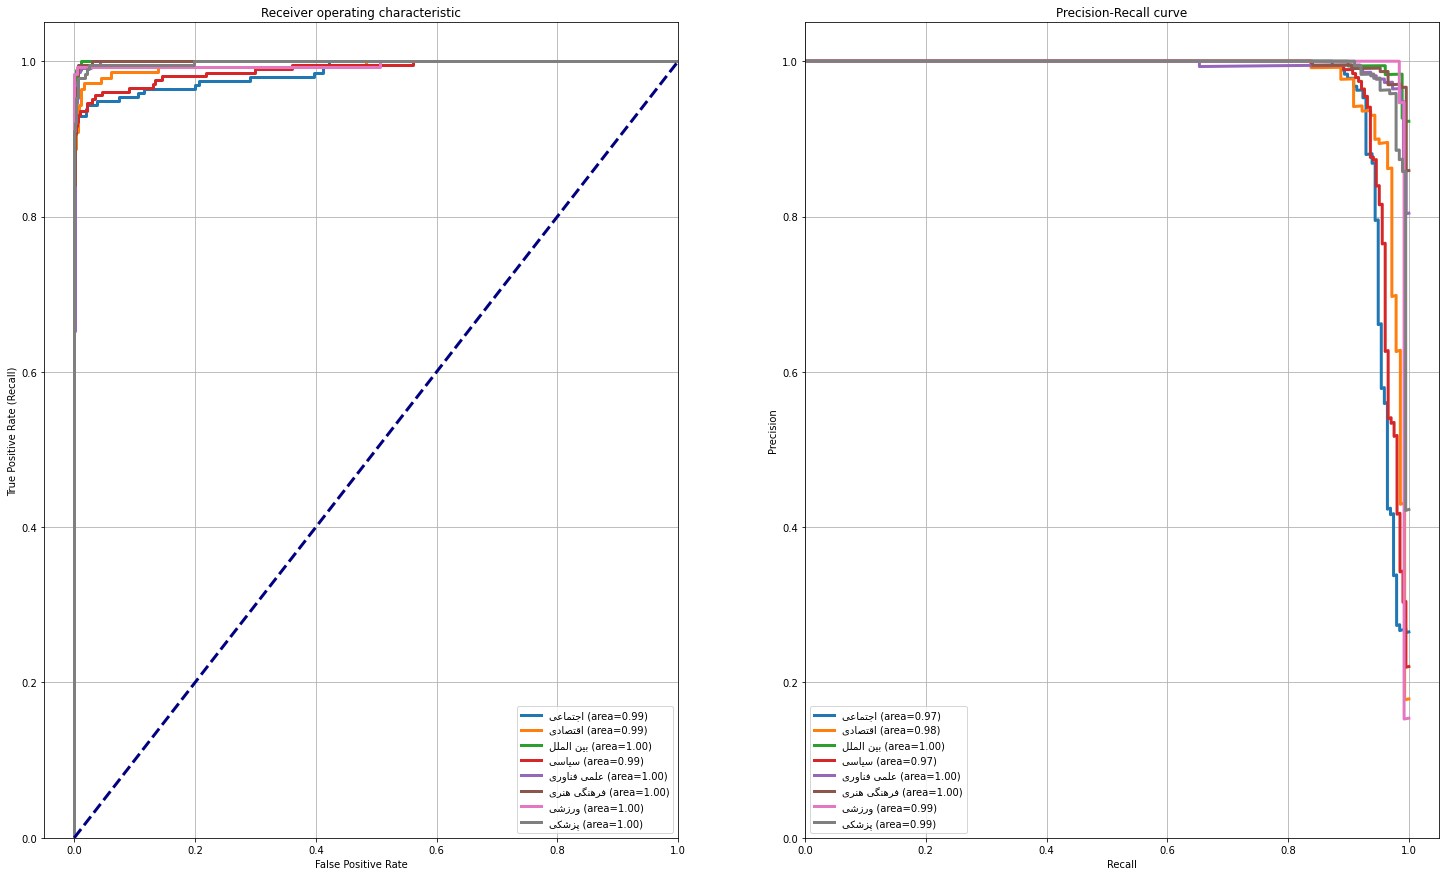

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,15))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_m[:,i],  
                           np.array(predictions)[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(per_label[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_m[:,i], np.array(predictions)[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(per_label[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## CNN_BILSTM config100-half on ds1

### train

In [ ]:
x_train_m = x_train_m[:,:50]
x_valid_m = x_valid_m[:,:50]

In [ ]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_size, weights=[word_vector_l], input_length=maxlim, trainable=True))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=30, strides=None, padding="valid"))
model.add(Dropout(0.5, seed=100))
model.add(Bidirectional(LSTM(128, activation="tanh", recurrent_activation="sigmoid", dropout=0.0, recurrent_dropout=0.0)))
model.add(Dropout(0.7, seed=100))
model.add(Dense(y_train_m.shape[1], activation='sigmoid'))

print(model.summary())
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint("/content/drive/MyDrive/best_model.h5", monitor='val_accuracy', mode='max',
                              verbose=1, save_best_only=True)

print('Training model...')
history = model.fit(x_train_m, y_train_m, epochs=50, batch_size=8,
                validation_data=(x_valid_m, y_valid_m), callbacks=[es,mc], verbose=1)

with open("/content/drive/MyDrive/history.h5", 'wb') as f2:
        pickle.dump(history.history, f2)
        f2.close()

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_77 (Embedding)    (None, 50, 100)           10220500  
                                                                 
 conv1d_85 (Conv1D)          (None, 50, 32)            22432     
                                                                 
 max_pooling1d_81 (MaxPoolin  (None, 1, 32)            0         
 g1D)                                                            
                                                                 
 dropout_130 (Dropout)       (None, 1, 32)             0         
                                                                 
 bidirectional_72 (Bidirecti  (None, 256)              164864    
 onal)                                                           
                                                                 
 dropout_131 (Dropout)       (None, 256)             

### predict

In [ ]:
model=load_model("/content/drive/MyDrive/best_model.h5")

In [ ]:
predictions=[]
prediction=[]
x_test_m = x_test_m[:,:50]
predictions=model.predict(x_test_m[:])

prediction = np.zeros_like(predictions, dtype=int)

predictions=predictions.tolist()
prediction=prediction.tolist()

for i in range(len(predictions)):
  prediction[i][predictions[i].index(max(predictions[i]))]=1

prediction = np.array(prediction)

y_test_array = y_test_m.argmax(axis=1)

per_label = []
for lb in labels:
  per_label.append(get_display(arabic_reshaper.reshape(lb)))

### Results

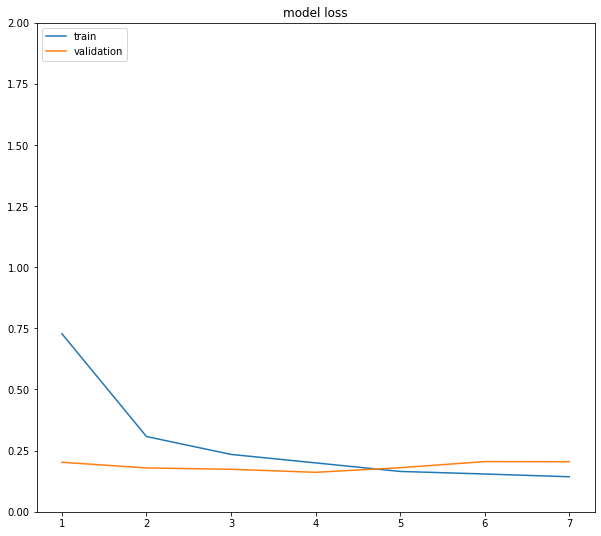

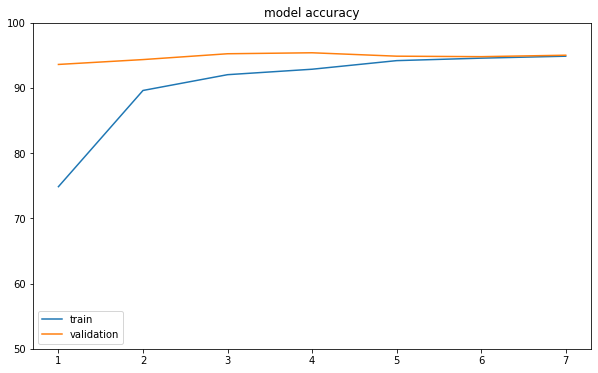

In [ ]:
with open("/content/drive/MyDrive/history.h5", "rb") as f:
    hist = pickle.load(f)

# Plotting Loss and Accuracy Graphs
plt.rcParams["figure.figsize"] = (10,9)
e_arr = np.array(range(1,8))
plt.plot(e_arr, hist['loss'])
plt.plot(e_arr, hist['val_loss'])
# plt.xticks(range(1, 14))
plt.ylim(0,2)
plt.title('model loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(e_arr, np.array(hist['accuracy'])*100)
plt.plot(e_arr, np.array(hist['val_accuracy'])*100)
# plt.xticks(range(1, 4))
plt.ylim(50,100)
plt.title('model accuracy')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

In [ ]:
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test_m, prediction)
auc = metrics.roc_auc_score(y_test_m, predictions, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print(f'F1: {f1_score(y_test_m, prediction, average="weighted")}')
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test_m, prediction))
  

Accuracy: 0.95
F1: 0.94784356895341
Auc: 0.98
Detail:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       197
           1       0.96      0.90      0.93       142
           2       0.97      0.96      0.97       179
           3       0.94      0.90      0.92       204
           4       0.96      0.95      0.96       222
           5       0.96      0.98      0.97       232
           6       0.99      0.98      0.98       126
           7       0.96      0.96      0.96       189

   micro avg       0.95      0.95      0.95      1491
   macro avg       0.95      0.95      0.95      1491
weighted avg       0.95      0.95      0.95      1491
 samples avg       0.95      0.95      0.95      1491



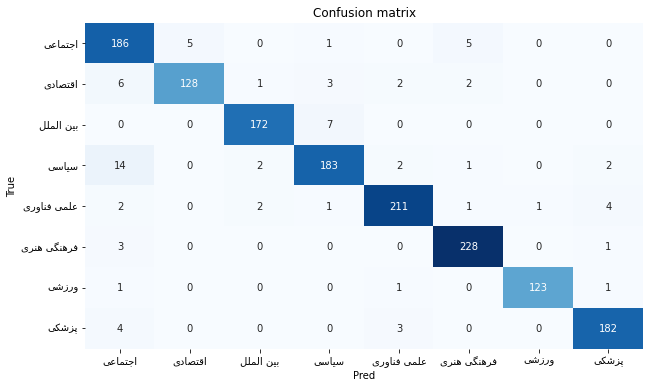

In [ ]:
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_array, np.array(prediction).argmax(axis=1))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=per_label, 
       yticklabels=per_label, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

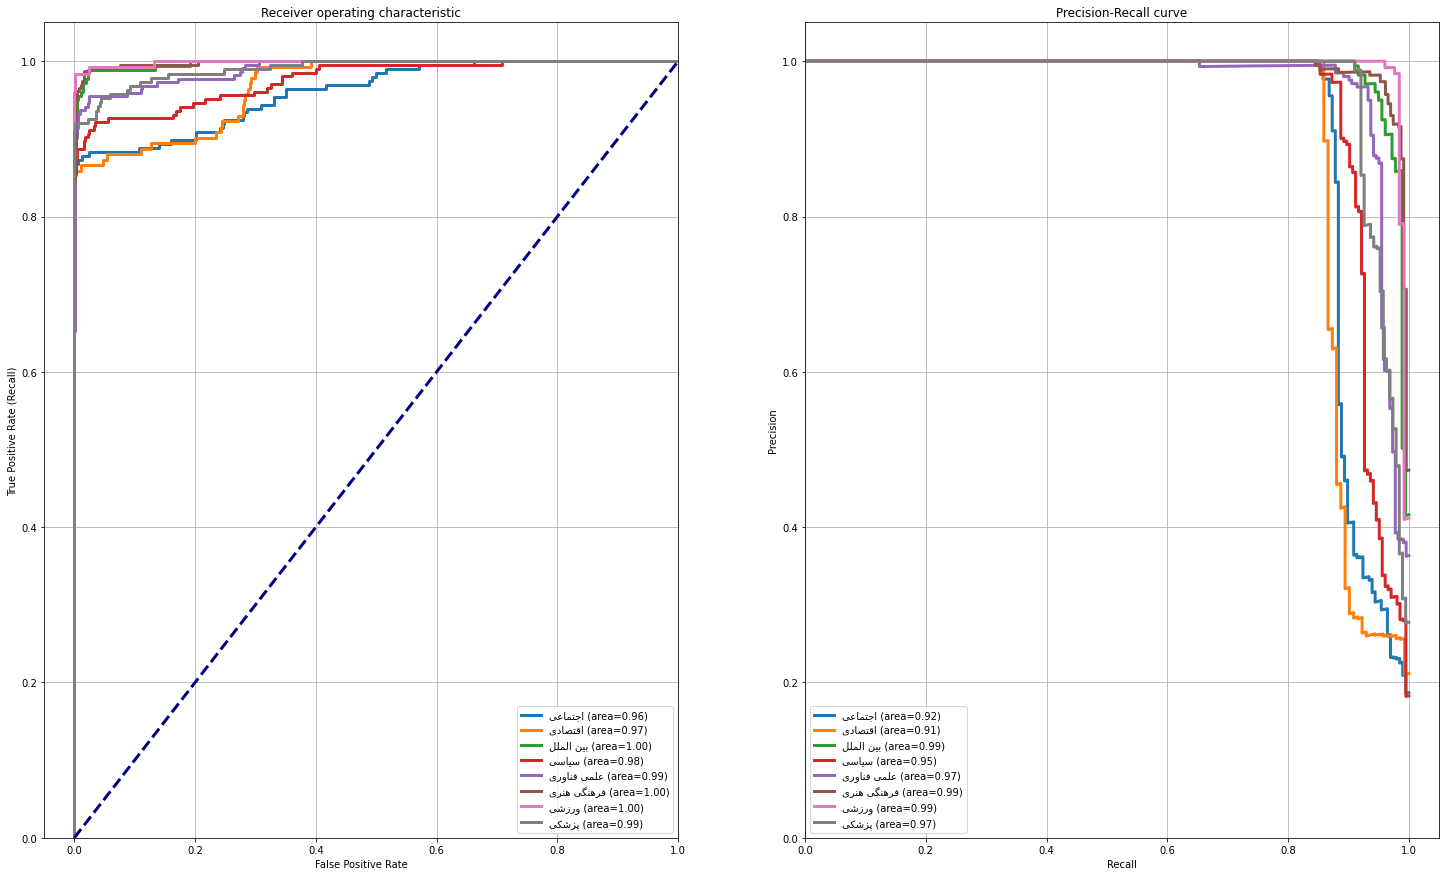

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,15))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_m[:,i],  
                           np.array(predictions)[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(per_label[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_m[:,i], np.array(predictions)[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(per_label[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## CNN_BILSTM config100-quarter on ds1

### train

In [ ]:
x_train_m = x_train_m[:,:10]
x_valid_m = x_valid_m[:,:10]

In [ ]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_size, weights=[word_vector_l], input_length=maxlim, trainable=True))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=10, strides=None, padding="valid"))
model.add(Dropout(0.5, seed=100))
model.add(Bidirectional(LSTM(128, activation="tanh", recurrent_activation="sigmoid", dropout=0.0, recurrent_dropout=0.0)))
model.add(Dropout(0.7, seed=100))
model.add(Dense(y_train_m.shape[1], activation='sigmoid'))

print(model.summary())
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint("/content/drive/MyDrive/best_model.h5", monitor='val_accuracy', mode='max',
                              verbose=1, save_best_only=True)

print('Training model...')
history = model.fit(x_train_m, y_train_m, epochs=50, batch_size=8,
                validation_data=(x_valid_m, y_valid_m), callbacks=[es,mc], verbose=1)

with open("/content/drive/MyDrive/history.h5", 'wb') as f2:
        pickle.dump(history.history, f2)
        f2.close()

Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_79 (Embedding)    (None, 10, 100)           10220500  
                                                                 
 conv1d_87 (Conv1D)          (None, 10, 32)            22432     
                                                                 
 max_pooling1d_83 (MaxPoolin  (None, 1, 32)            0         
 g1D)                                                            
                                                                 
 dropout_132 (Dropout)       (None, 1, 32)             0         
                                                                 
 bidirectional_73 (Bidirecti  (None, 256)              164864    
 onal)                                                           
                                                                 
 dropout_133 (Dropout)       (None, 256)             

### predict

In [ ]:
model=load_model("/content/drive/MyDrive/best_model.h5")

In [ ]:
predictions=[]
prediction=[]
x_test_m = x_test_m[:,:10]
predictions=model.predict(x_test_m[:])

prediction = np.zeros_like(predictions, dtype=int)

predictions=predictions.tolist()
prediction=prediction.tolist()

for i in range(len(predictions)):
  prediction[i][predictions[i].index(max(predictions[i]))]=1

prediction = np.array(prediction)

y_test_array = y_test_m.argmax(axis=1)

per_label = []
for lb in labels:
  per_label.append(get_display(arabic_reshaper.reshape(lb)))

### Results

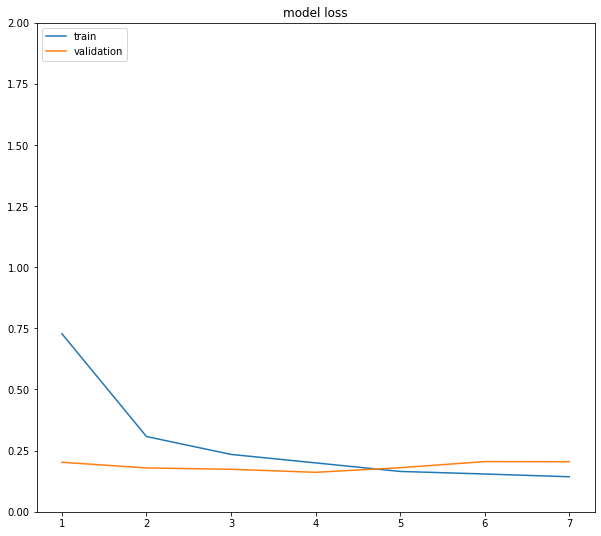

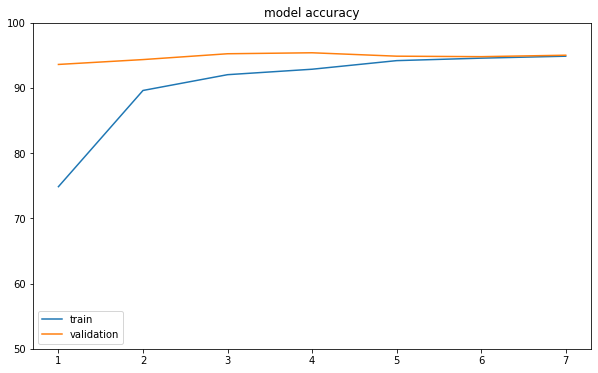

In [ ]:
with open("/content/drive/MyDrive/history.h5", "rb") as f:
    hist = pickle.load(f)

# Plotting Loss and Accuracy Graphs
plt.rcParams["figure.figsize"] = (10,9)
e_arr = np.array(range(1,8))
plt.plot(e_arr, hist['loss'])
plt.plot(e_arr, hist['val_loss'])
# plt.xticks(range(1, 14))
plt.ylim(0,2)
plt.title('model loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(e_arr, np.array(hist['accuracy'])*100)
plt.plot(e_arr, np.array(hist['val_accuracy'])*100)
# plt.xticks(range(1, 4))
plt.ylim(50,100)
plt.title('model accuracy')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

In [ ]:
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test_m, prediction)
auc = metrics.roc_auc_score(y_test_m, predictions, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print(f'F1: {f1_score(y_test_m, prediction, average="weighted")}')
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test_m, prediction))
  

Accuracy: 0.95
F1: 0.94784356895341
Auc: 0.98
Detail:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       197
           1       0.96      0.90      0.93       142
           2       0.97      0.96      0.97       179
           3       0.94      0.90      0.92       204
           4       0.96      0.95      0.96       222
           5       0.96      0.98      0.97       232
           6       0.99      0.98      0.98       126
           7       0.96      0.96      0.96       189

   micro avg       0.95      0.95      0.95      1491
   macro avg       0.95      0.95      0.95      1491
weighted avg       0.95      0.95      0.95      1491
 samples avg       0.95      0.95      0.95      1491



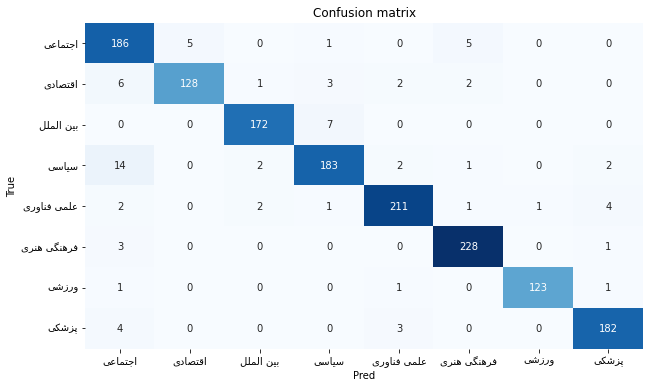

In [ ]:
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_array, np.array(prediction).argmax(axis=1))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=per_label, 
       yticklabels=per_label, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

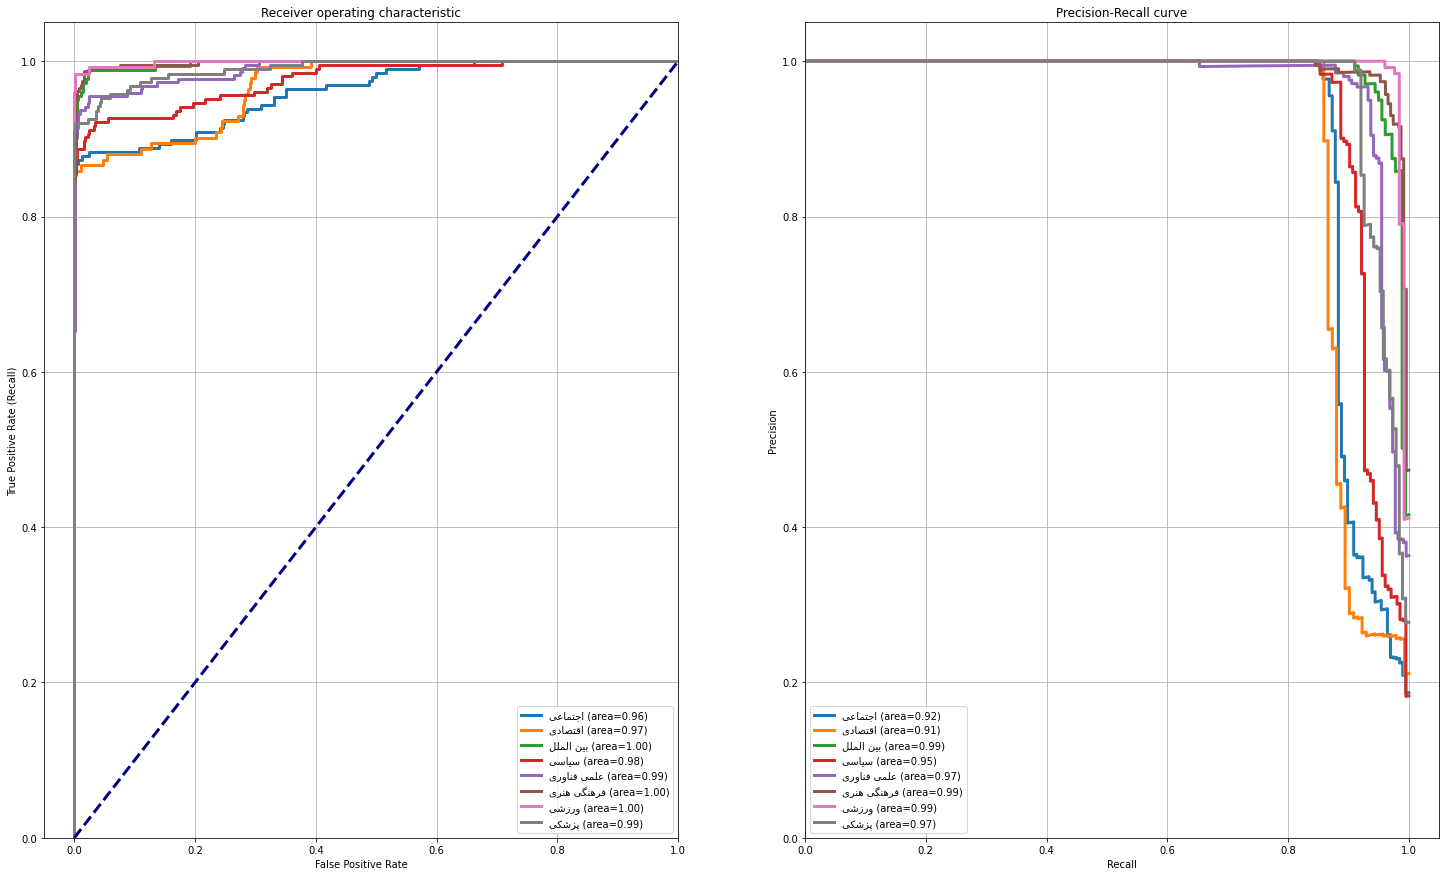

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,15))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_m[:,i],  
                           np.array(predictions)[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(per_label[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_m[:,i], np.array(predictions)[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(per_label[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## CNN_BILSTM config100-qualtel on ds1

### train

In [ ]:
x_train_m = x_train_m[:,:5]
x_valid_m = x_valid_m[:,:5]

In [ ]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_size, weights=[word_vector_l], input_length=maxlim, trainable=True))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=None, padding="valid"))
model.add(Dropout(0.5, seed=100))
model.add(Bidirectional(LSTM(128, activation="tanh", recurrent_activation="sigmoid", dropout=0.0, recurrent_dropout=0.0)))
model.add(Dropout(0.7, seed=100))
model.add(Dense(y_train_m.shape[1], activation='sigmoid'))

print(model.summary())
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint("/content/drive/MyDrive/best_model.h5", monitor='val_accuracy', mode='max',
                              verbose=1, save_best_only=True)

print('Training model...')
history = model.fit(x_train_m, y_train_m, epochs=50, batch_size=8,
                validation_data=(x_valid_m, y_valid_m), callbacks=[es,mc], verbose=1)

with open("/content/drive/MyDrive/history.h5", 'wb') as f2:
        pickle.dump(history.history, f2)
        f2.close()

Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_81 (Embedding)    (None, 5, 100)            10220500  
                                                                 
 conv1d_89 (Conv1D)          (None, 5, 32)             22432     
                                                                 
 max_pooling1d_85 (MaxPoolin  (None, 1, 32)            0         
 g1D)                                                            
                                                                 
 dropout_136 (Dropout)       (None, 1, 32)             0         
                                                                 
 bidirectional_75 (Bidirecti  (None, 256)              164864    
 onal)                                                           
                                                                 
 dropout_137 (Dropout)       (None, 256)             

### predict

In [ ]:
model=load_model("/content/drive/MyDrive/best_model.h5")

In [ ]:
predictions=[]
prediction=[]
x_test_m = x_test_m[:,:5]
predictions=model.predict(x_test_m[:])

prediction = np.zeros_like(predictions, dtype=int)

predictions=predictions.tolist()
prediction=prediction.tolist()

for i in range(len(predictions)):
  prediction[i][predictions[i].index(max(predictions[i]))]=1

prediction = np.array(prediction)

y_test_array = y_test_m.argmax(axis=1)

per_label = []
for lb in labels:
  per_label.append(get_display(arabic_reshaper.reshape(lb)))

### Results

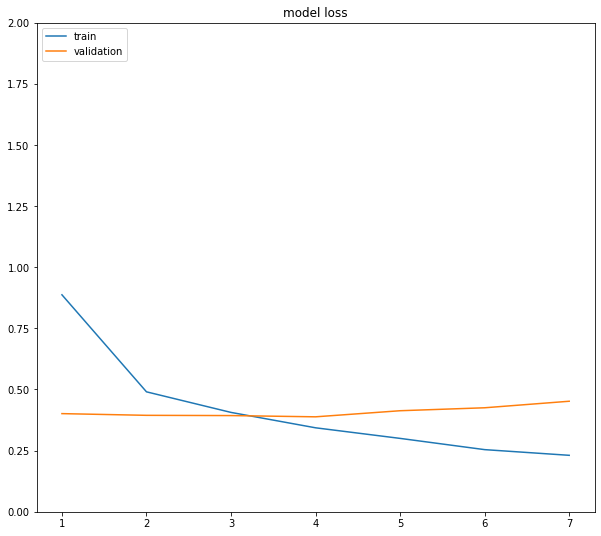

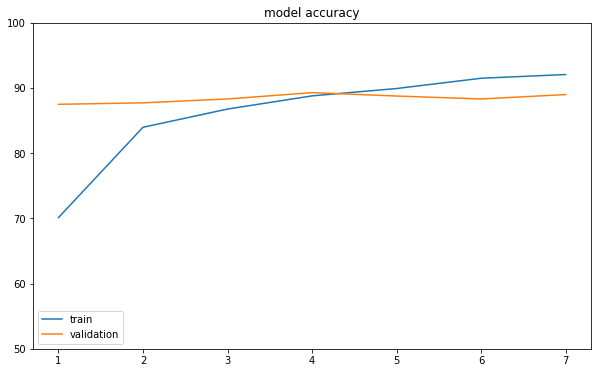

In [ ]:
with open("/content/drive/MyDrive/history.h5", "rb") as f:
    hist = pickle.load(f)

# Plotting Loss and Accuracy Graphs
plt.rcParams["figure.figsize"] = (10,9)
e_arr = np.array(range(1,8))
plt.plot(e_arr, hist['loss'])
plt.plot(e_arr, hist['val_loss'])
# plt.xticks(range(1, 14))
plt.ylim(0,2)
plt.title('model loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(e_arr, np.array(hist['accuracy'])*100)
plt.plot(e_arr, np.array(hist['val_accuracy'])*100)
# plt.xticks(range(1, 4))
plt.ylim(50,100)
plt.title('model accuracy')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

In [ ]:
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test_m, prediction)
auc = metrics.roc_auc_score(y_test_m, predictions, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print(f'F1: {f1_score(y_test_m, prediction, average="weighted")}')
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test_m, prediction))
  

Accuracy: 0.88
F1: 0.8751871445112729
Auc: 0.97
Detail:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       197
           1       0.79      0.89      0.84       142
           2       0.97      0.94      0.96       179
           3       0.83      0.83      0.83       204
           4       0.88      0.91      0.89       222
           5       0.92      0.91      0.91       232
           6       0.95      0.88      0.91       126
           7       0.87      0.89      0.88       189

   micro avg       0.88      0.88      0.88      1491
   macro avg       0.88      0.88      0.88      1491
weighted avg       0.88      0.88      0.88      1491
 samples avg       0.88      0.88      0.88      1491



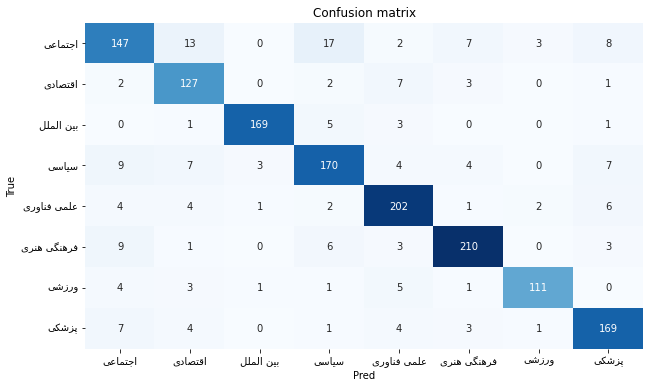

In [ ]:
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_array, np.array(prediction).argmax(axis=1))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=per_label, 
       yticklabels=per_label, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

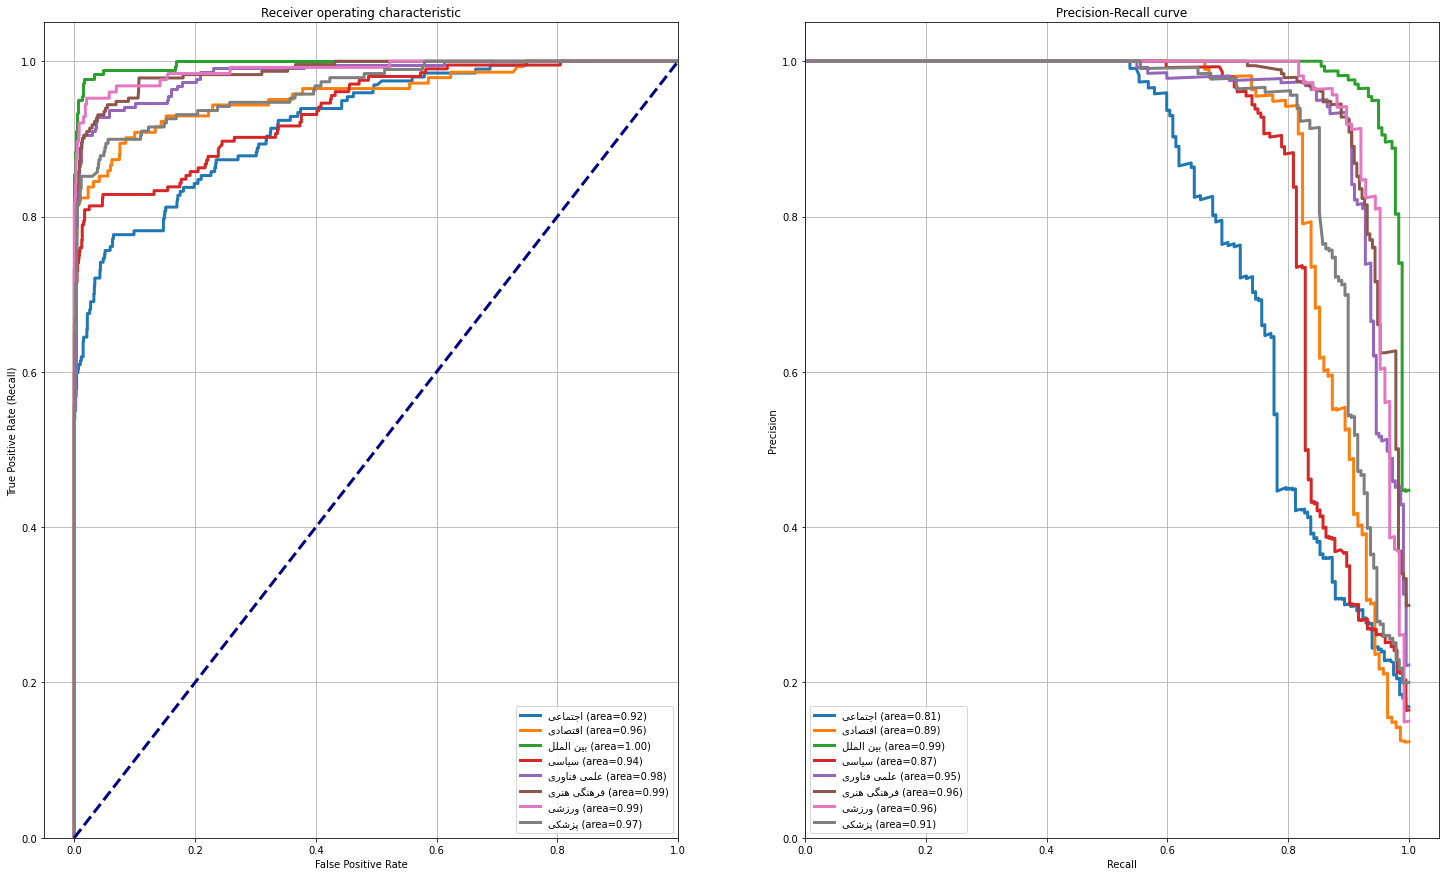

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,15))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_m[:,i],  
                           np.array(predictions)[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(per_label[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_m[:,i], np.array(predictions)[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(per_label[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## CNN_BILSTM config300 on ds1

### train

In [ ]:
# x_train_m = x_train_m[:,:50]
# x_valid_m = x_valid_m[:,:50]

In [ ]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_size, weights=[word_vector_l], input_length=maxlim, trainable=True))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=10, strides=None, padding="valid"))
model.add(Dropout(0.5, seed=100))
model.add(Bidirectional(LSTM(128, activation="tanh", recurrent_activation="sigmoid", dropout=0.0, recurrent_dropout=0.0)))
model.add(Dropout(0.7, seed=100))
model.add(Dense(y_train_m.shape[1], activation='sigmoid'))

print(model.summary())
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint("/content/drive/MyDrive/best_model.h5", monitor='val_accuracy', mode='max',
                              verbose=1, save_best_only=True)

print('Training model...')
history = model.fit(x_train_m, y_train_m, epochs=50, batch_size=8,
                validation_data=(x_valid_m, y_valid_m), callbacks=[es,mc], verbose=1)

with open("/content/drive/MyDrive/history.h5", 'wb') as f2:
        pickle.dump(history.history, f2)
        f2.close()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 300)           30661500  
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 32)            67232     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 32)            0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 32)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              164864    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 256)              

ValueError: ignored

### predict

In [ ]:
model=load_model("/content/drive/MyDrive/best_model.h5")

In [ ]:
predictions=[]
prediction=[]

predictions=model.predict(x_test_m[:])

prediction = np.zeros_like(predictions, dtype=int)

predictions=predictions.tolist()
prediction=prediction.tolist()

for i in range(len(predictions)):
  prediction[i][predictions[i].index(max(predictions[i]))]=1

prediction = np.array(prediction)

y_test_array = y_test_m.argmax(axis=1)

per_label = []
for lb in labels:
  per_label.append(get_display(arabic_reshaper.reshape(lb)))

### Results

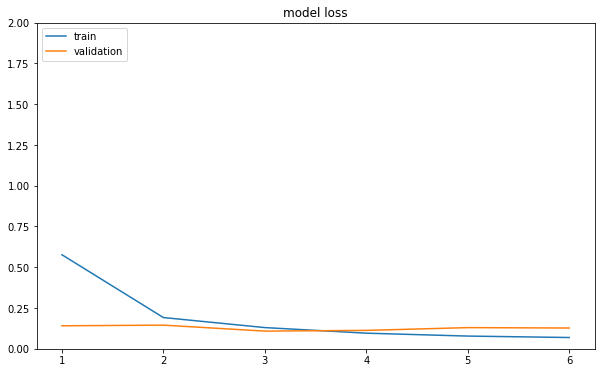

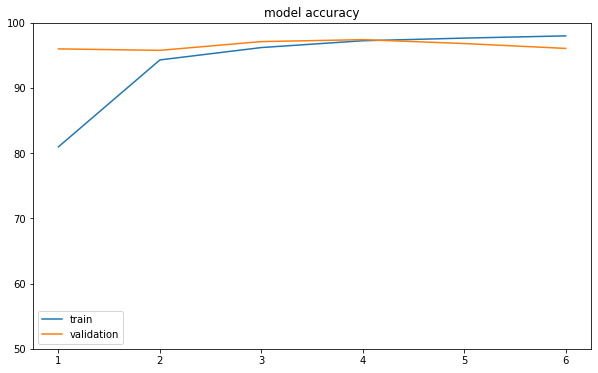

In [ ]:
with open("/content/drive/MyDrive/history.h5", "rb") as f:
    hist = pickle.load(f)

# Plotting Loss and Accuracy Graphs
plt.rcParams["figure.figsize"] = (10,6)
e_arr = np.array(range(1,7))
plt.plot(e_arr, hist['loss'])
plt.plot(e_arr, hist['val_loss'])
# plt.xticks(range(1, 14))
plt.ylim(0,2)
plt.title('model loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(e_arr, np.array(hist['accuracy'])*100)
plt.plot(e_arr, np.array(hist['val_accuracy'])*100)
# plt.xticks(range(1, 4))
plt.ylim(50,100)
plt.title('model accuracy')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

In [ ]:
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test_m, prediction)
auc = metrics.roc_auc_score(y_test_m, predictions, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print(f'F1: {f1_score(y_test_m, prediction, average="weighted")}')
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test_m, prediction))
  

Accuracy: 0.96
F1: 0.9635825710176461
Auc: 0.99
Detail:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       197
           1       0.94      0.92      0.93       142
           2       0.98      1.00      0.99       179
           3       0.99      0.92      0.95       204
           4       0.97      0.99      0.98       222
           5       0.95      1.00      0.97       232
           6       0.98      0.98      0.98       126
           7       0.96      0.97      0.96       189

   micro avg       0.96      0.96      0.96      1491
   macro avg       0.96      0.96      0.96      1491
weighted avg       0.96      0.96      0.96      1491
 samples avg       0.96      0.96      0.96      1491



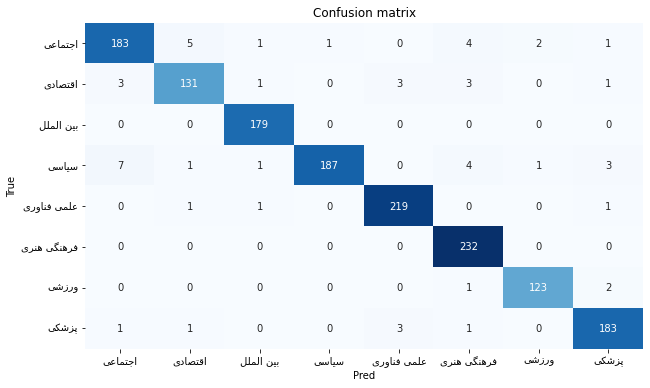

In [ ]:
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_array, np.array(prediction).argmax(axis=1))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=per_label, 
       yticklabels=per_label, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

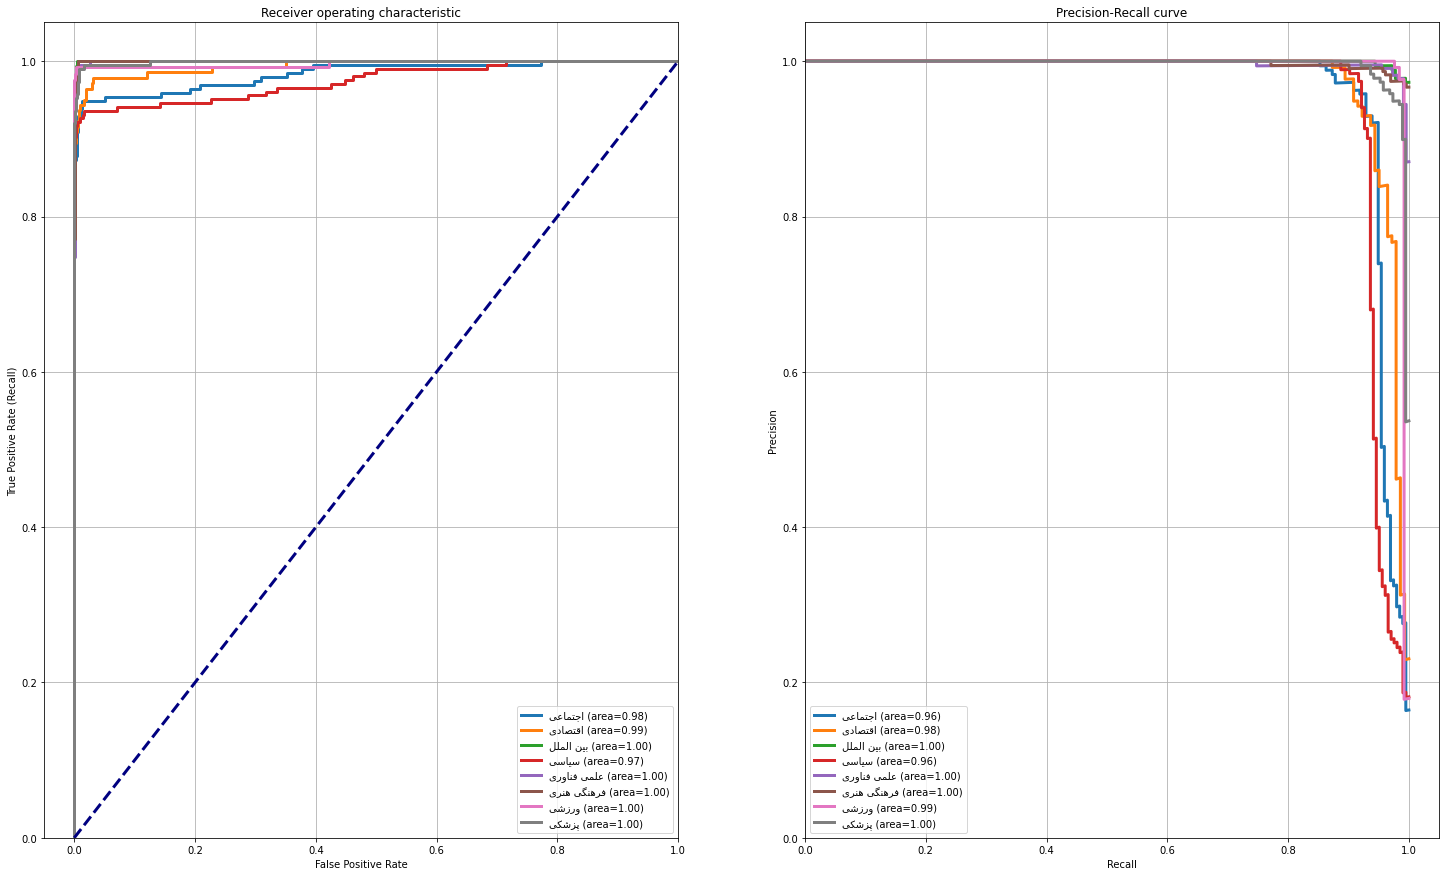

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,15))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_m[:,i],  
                           np.array(predictions)[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(per_label[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_m[:,i], np.array(predictions)[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(per_label[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## CNN_BILSTM config300-quarter on ds1

### train

In [8]:
x_train_m = x_train_m[:,:10]
x_valid_m = x_valid_m[:,:10]

In [9]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_size, weights=[word_vector_l], input_length=maxlim, trainable=True))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=10, strides=None, padding="valid"))
model.add(Dropout(0.5, seed=100))
model.add(Bidirectional(LSTM(128, activation="tanh", recurrent_activation="sigmoid", dropout=0.0, recurrent_dropout=0.0)))
model.add(Dropout(0.7, seed=100))
model.add(Dense(y_train_m.shape[1], activation='sigmoid'))

print(model.summary())
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint("/content/drive/MyDrive/best_model.h5", monitor='val_accuracy', mode='max',
                              verbose=1, save_best_only=True)

print('Training model...')
history = model.fit(x_train_m, y_train_m, epochs=50, batch_size=8,
                validation_data=(x_valid_m, y_valid_m), callbacks=[es,mc], verbose=1)

with open("/content/drive/MyDrive/history.h5", 'wb') as f2:
        pickle.dump(history.history, f2)
        f2.close()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 300)           30661500  
                                                                 
 conv1d (Conv1D)             (None, 10, 32)            67232     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 32)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 32)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              164864    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

### predict

In [10]:
model=load_model("/content/drive/MyDrive/best_model.h5")

In [11]:
predictions=[]
prediction=[]
x_test_m = x_test_m[:,:10]
predictions=model.predict(x_test_m[:])

prediction = np.zeros_like(predictions, dtype=int)

predictions=predictions.tolist()
prediction=prediction.tolist()

for i in range(len(predictions)):
  prediction[i][predictions[i].index(max(predictions[i]))]=1

prediction = np.array(prediction)

y_test_array = y_test_m.argmax(axis=1)

per_label = []
for lb in labels:
  per_label.append(get_display(arabic_reshaper.reshape(lb)))

### Results

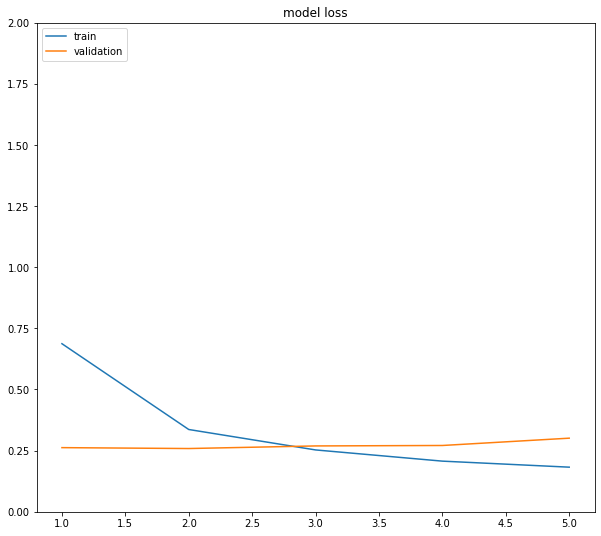

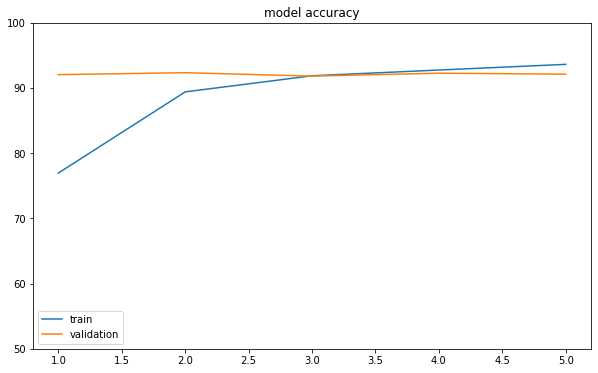

In [13]:
with open("/content/drive/MyDrive/history.h5", "rb") as f:
    hist = pickle.load(f)

# Plotting Loss and Accuracy Graphs
plt.rcParams["figure.figsize"] = (10,9)
e_arr = np.array(range(1,6))
plt.plot(e_arr, hist['loss'])
plt.plot(e_arr, hist['val_loss'])
# plt.xticks(range(1, 14))
plt.ylim(0,2)
plt.title('model loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(e_arr, np.array(hist['accuracy'])*100)
plt.plot(e_arr, np.array(hist['val_accuracy'])*100)
# plt.xticks(range(1, 4))
plt.ylim(50,100)
plt.title('model accuracy')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

In [14]:
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test_m, prediction)
auc = metrics.roc_auc_score(y_test_m, predictions, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print(f'F1: {f1_score(y_test_m, prediction, average="weighted")}')
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test_m, prediction))
  

Accuracy: 0.91
F1: 0.9118463999675486
Auc: 0.98
Detail:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       197
           1       0.81      0.92      0.86       142
           2       0.98      0.93      0.95       179
           3       0.87      0.89      0.88       204
           4       0.92      0.94      0.93       222
           5       0.91      0.92      0.92       232
           6       0.99      0.95      0.97       126
           7       0.94      0.91      0.92       189

   micro avg       0.91      0.91      0.91      1491
   macro avg       0.91      0.91      0.91      1491
weighted avg       0.91      0.91      0.91      1491
 samples avg       0.91      0.91      0.91      1491



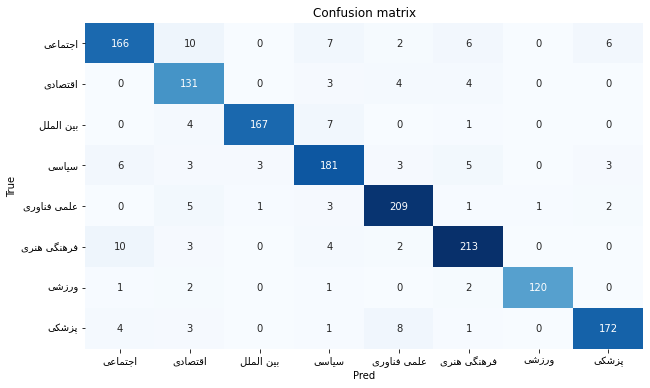

In [15]:
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_array, np.array(prediction).argmax(axis=1))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=per_label, 
       yticklabels=per_label, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

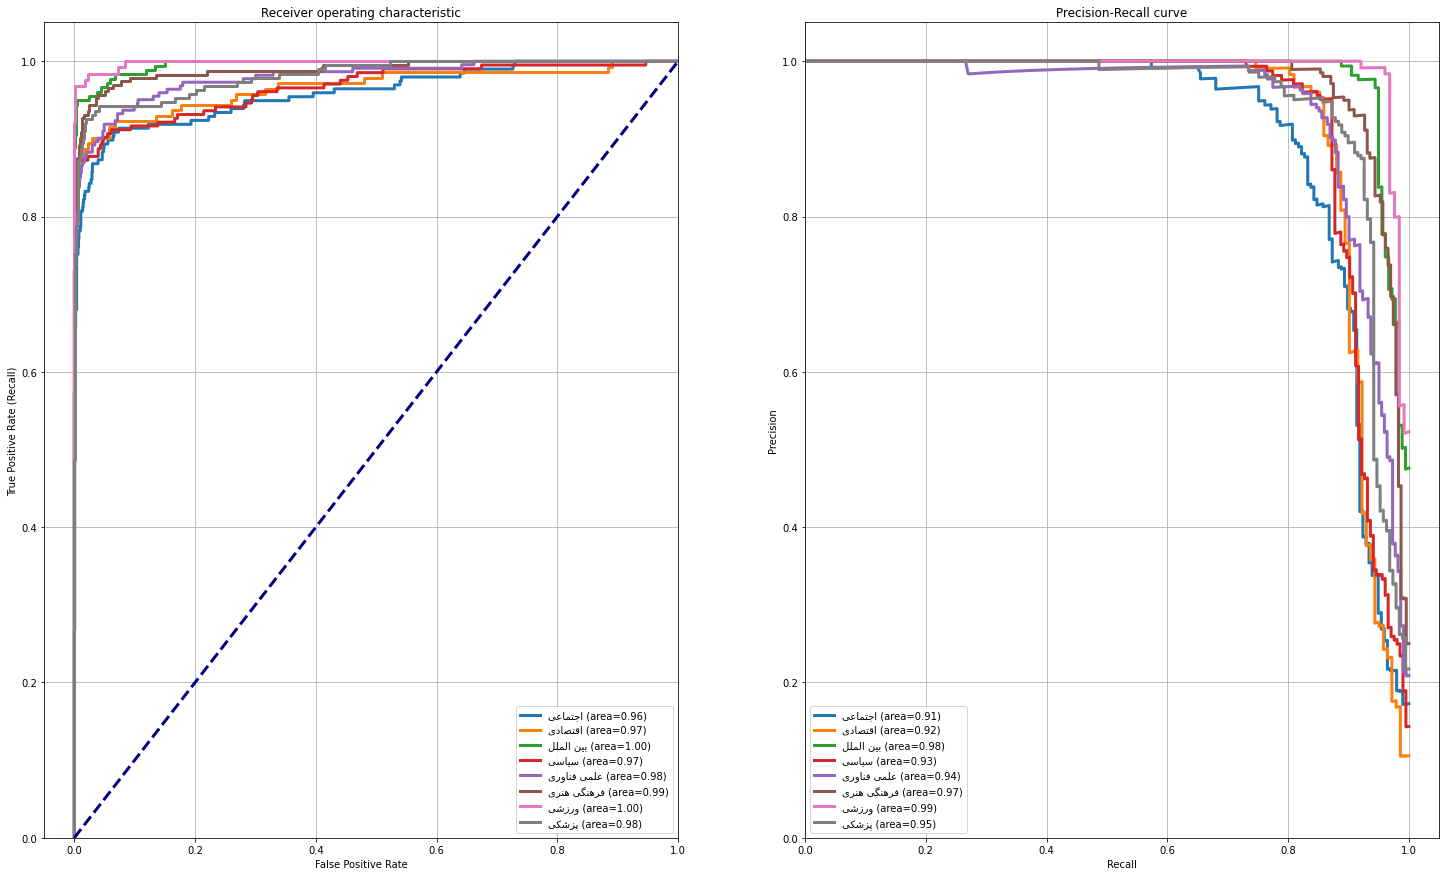

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,15))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_m[:,i],  
                           np.array(predictions)[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(per_label[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_m[:,i], np.array(predictions)[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(per_label[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## CNN_BILSTM config300-qualtel on ds1

### train

In [18]:
x_train_m = x_train_m[:,:5]
x_valid_m = x_valid_m[:,:5]

In [19]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_size, weights=[word_vector_l], input_length=maxlim, trainable=True))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=None, padding="valid"))
model.add(Dropout(0.5, seed=100))
model.add(Bidirectional(LSTM(128, activation="tanh", recurrent_activation="sigmoid", dropout=0.0, recurrent_dropout=0.0)))
model.add(Dropout(0.7, seed=100))
model.add(Dense(y_train_m.shape[1], activation='sigmoid'))

print(model.summary())
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint("/content/drive/MyDrive/best_model.h5", monitor='val_accuracy', mode='max',
                              verbose=1, save_best_only=True)

print('Training model...')
history = model.fit(x_train_m, y_train_m, epochs=50, batch_size=8,
                validation_data=(x_valid_m, y_valid_m), callbacks=[es,mc], verbose=1)

with open("/content/drive/MyDrive/history.h5", 'wb') as f2:
        pickle.dump(history.history, f2)
        f2.close()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 5, 300)            30661500  
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 32)             67232     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 32)            0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 1, 32)             0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              164864    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 256)              

### predict

In [20]:
model=load_model("/content/drive/MyDrive/best_model.h5")

In [21]:
predictions=[]
prediction=[]
x_test_m = x_test_m[:,:5]
predictions=model.predict(x_test_m[:])

prediction = np.zeros_like(predictions, dtype=int)

predictions=predictions.tolist()
prediction=prediction.tolist()

for i in range(len(predictions)):
  prediction[i][predictions[i].index(max(predictions[i]))]=1

prediction = np.array(prediction)

y_test_array = y_test_m.argmax(axis=1)

per_label = []
for lb in labels:
  per_label.append(get_display(arabic_reshaper.reshape(lb)))

### Results

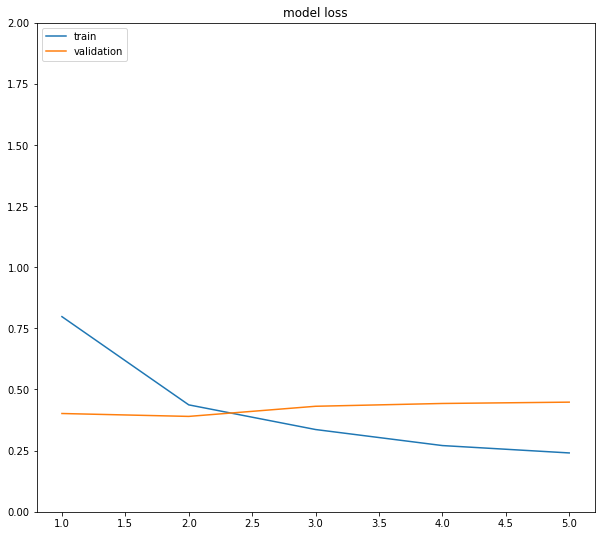

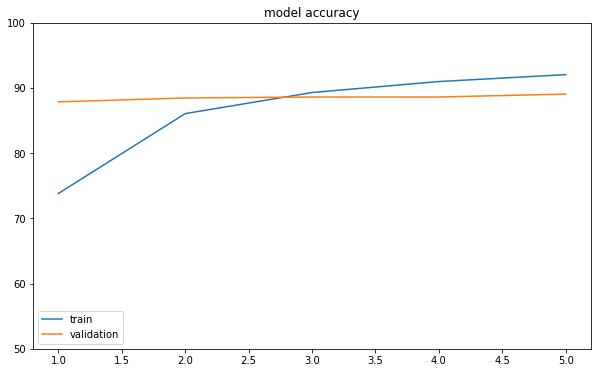

In [26]:
with open("/content/drive/MyDrive/history.h5", "rb") as f:
    hist = pickle.load(f)

# Plotting Loss and Accuracy Graphs
plt.rcParams["figure.figsize"] = (10,9)
e_arr = np.array(range(1,6))
plt.plot(e_arr, hist['loss'])
plt.plot(e_arr, hist['val_loss'])
# plt.xticks(range(1, 14))
plt.ylim(0,2)
plt.title('model loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(e_arr, np.array(hist['accuracy'])*100)
plt.plot(e_arr, np.array(hist['val_accuracy'])*100)
# plt.xticks(range(1, 4))
plt.ylim(50,100)
plt.title('model accuracy')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

In [27]:
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test_m, prediction)
auc = metrics.roc_auc_score(y_test_m, predictions, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print(f'F1: {f1_score(y_test_m, prediction, average="weighted")}')
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test_m, prediction))
  

Accuracy: 0.88
F1: 0.8794410864481627
Auc: 0.97
Detail:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       197
           1       0.80      0.88      0.84       142
           2       0.95      0.94      0.95       179
           3       0.88      0.83      0.85       204
           4       0.91      0.90      0.90       222
           5       0.92      0.91      0.91       232
           6       0.93      0.91      0.92       126
           7       0.87      0.89      0.88       189

   micro avg       0.88      0.88      0.88      1491
   macro avg       0.88      0.88      0.88      1491
weighted avg       0.88      0.88      0.88      1491
 samples avg       0.88      0.88      0.88      1491



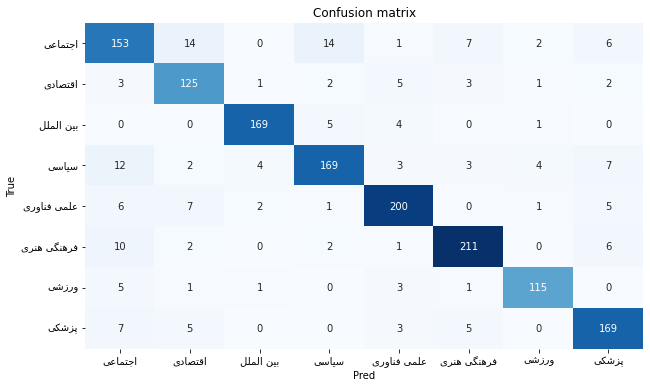

In [28]:
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_array, np.array(prediction).argmax(axis=1))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=per_label, 
       yticklabels=per_label, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

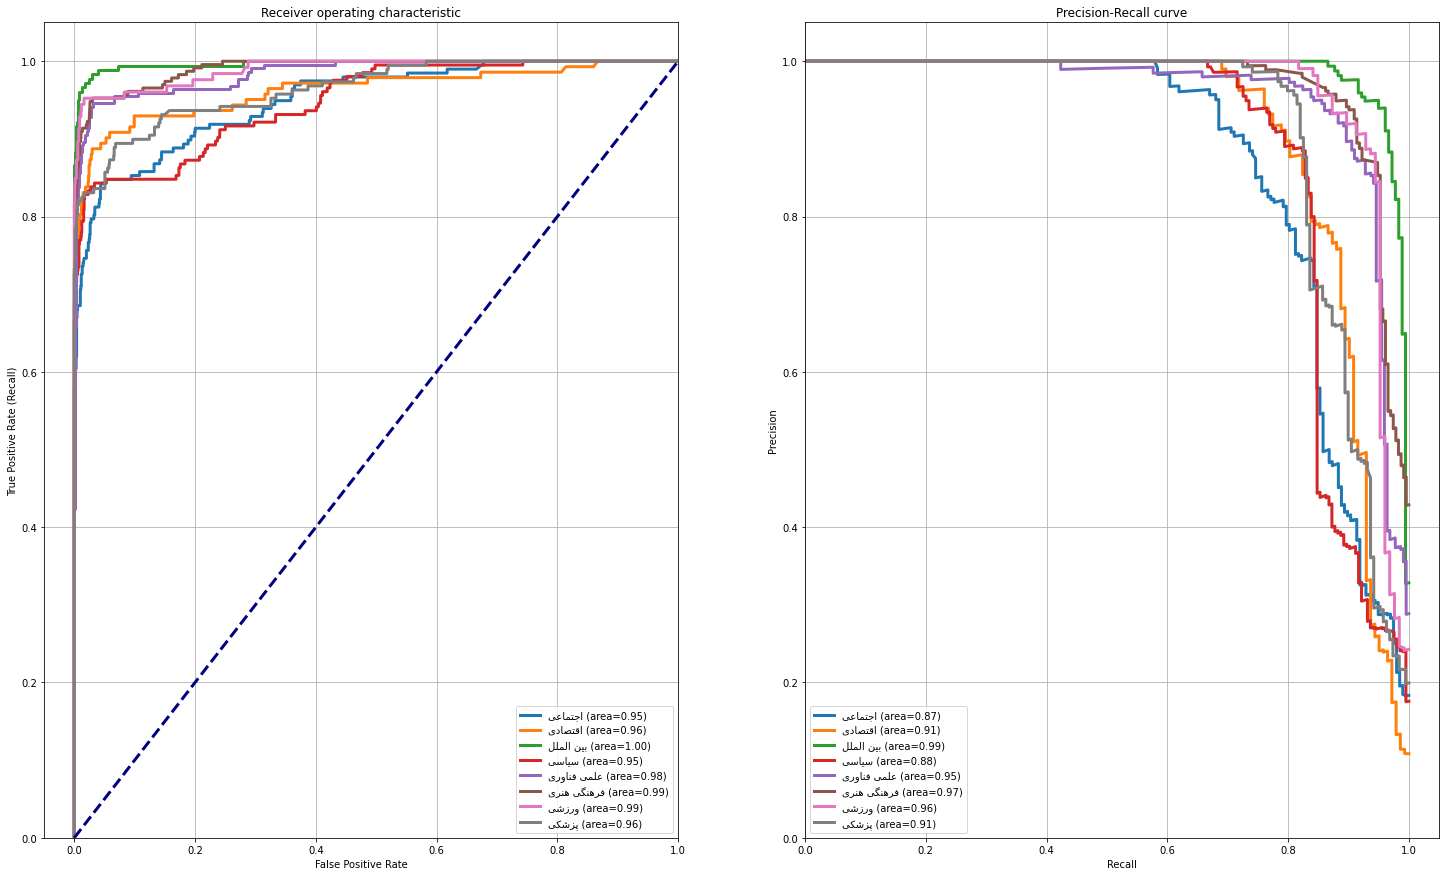

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,15))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_m[:,i],  
                           np.array(predictions)[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(per_label[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_m[:,i], np.array(predictions)[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(per_label[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## CNN_BILSTM config100 on ds2

### train

In [ ]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_size, weights=[word_vector_l], input_length=maxlim, trainable=True))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=30, strides=None, padding="valid"))
model.add(Dropout(0.5, seed=100))
model.add(Bidirectional(LSTM(128, activation="tanh", recurrent_activation="sigmoid", dropout=0.0, recurrent_dropout=0.0)))
model.add(Dropout(0.7, seed=100))
model.add(Dense(y_train_m.shape[1], activation='sigmoid'))

print(model.summary())
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint("/content/drive/MyDrive/best_model.h5", monitor='val_accuracy', mode='max',
                              verbose=1, save_best_only=True)

print('Training model...')
history = model.fit(x_train_m, y_train_m, epochs=50, batch_size=8,
                validation_data=(x_valid_m, y_valid_m), callbacks=[es,mc], verbose=1)

with open("/content/drive/MyDrive/history.h5", 'wb') as f2:
        pickle.dump(history.history, f2)
        f2.close()

Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_82 (Embedding)    (None, 512, 100)          7349700   
                                                                 
 conv1d_90 (Conv1D)          (None, 512, 32)           22432     
                                                                 
 max_pooling1d_86 (MaxPoolin  (None, 17, 32)           0         
 g1D)                                                            
                                                                 
 dropout_138 (Dropout)       (None, 17, 32)            0         
                                                                 
 bidirectional_76 (Bidirecti  (None, 256)              164864    
 onal)                                                           
                                                                 
 dropout_139 (Dropout)       (None, 256)             

### predict

In [ ]:
model=load_model("/content/drive/MyDrive/best_model.h5")

In [ ]:
predictions=[]
prediction=[]

predictions=model.predict(x_test_m[:])

prediction = np.zeros_like(predictions, dtype=int)

predictions=predictions.tolist()
prediction=prediction.tolist()

for i in range(len(predictions)):
  prediction[i][predictions[i].index(max(predictions[i]))]=1

prediction = np.array(prediction)

y_test_array = y_test_m.argmax(axis=1)

per_label = []
for lb in labels:
  per_label.append(get_display(arabic_reshaper.reshape(lb)))

### Results

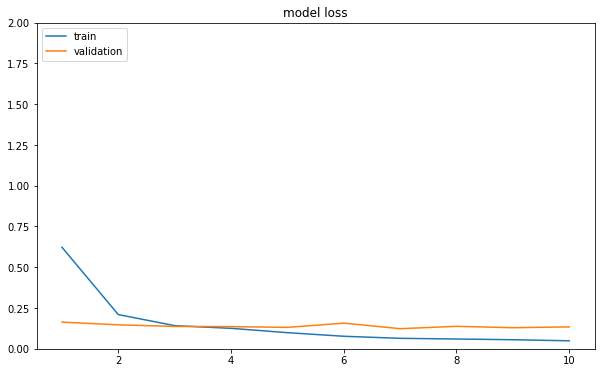

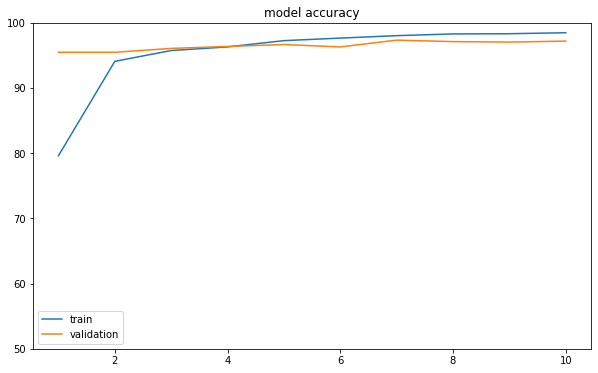

In [ ]:
with open("/content/drive/MyDrive/history.h5", "rb") as f:
    hist = pickle.load(f)

# Plotting Loss and Accuracy Graphs
plt.rcParams["figure.figsize"] = (10,6)
e_arr = np.array(range(1,11))
plt.plot(e_arr, hist['loss'])
plt.plot(e_arr, hist['val_loss'])
# plt.xticks(range(1, 14))
plt.ylim(0,2)
plt.title('model loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(e_arr, np.array(hist['accuracy'])*100)
plt.plot(e_arr, np.array(hist['val_accuracy'])*100)
# plt.xticks(range(1, 4))
plt.ylim(50,100)
plt.title('model accuracy')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

In [ ]:
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test_m, prediction)
auc = metrics.roc_auc_score(y_test_m, predictions, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print(f'F1: {f1_score(y_test_m, prediction, average="weighted")}')
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test_m, prediction))
  

Accuracy: 0.97
F1: 0.9697625940979727
Auc: 1.0
Detail:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       197
           1       0.96      0.96      0.96       142
           2       0.97      0.99      0.98       179
           3       0.98      0.95      0.96       204
           4       0.97      0.99      0.98       222
           5       0.97      0.99      0.98       232
           6       1.00      0.98      0.99       126
           7       0.97      0.96      0.97       189

   micro avg       0.97      0.97      0.97      1491
   macro avg       0.97      0.97      0.97      1491
weighted avg       0.97      0.97      0.97      1491
 samples avg       0.97      0.97      0.97      1491



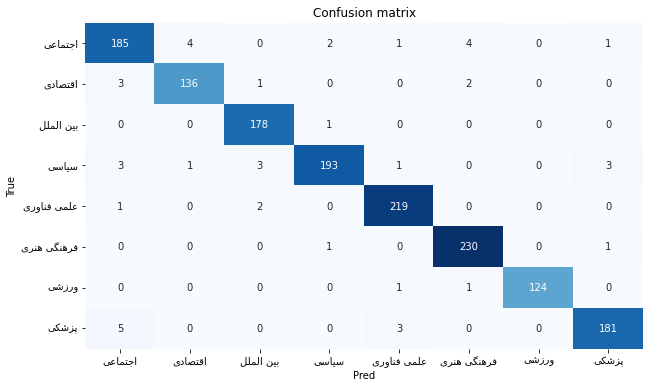

In [ ]:
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_array, np.array(prediction).argmax(axis=1))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=per_label, 
       yticklabels=per_label, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

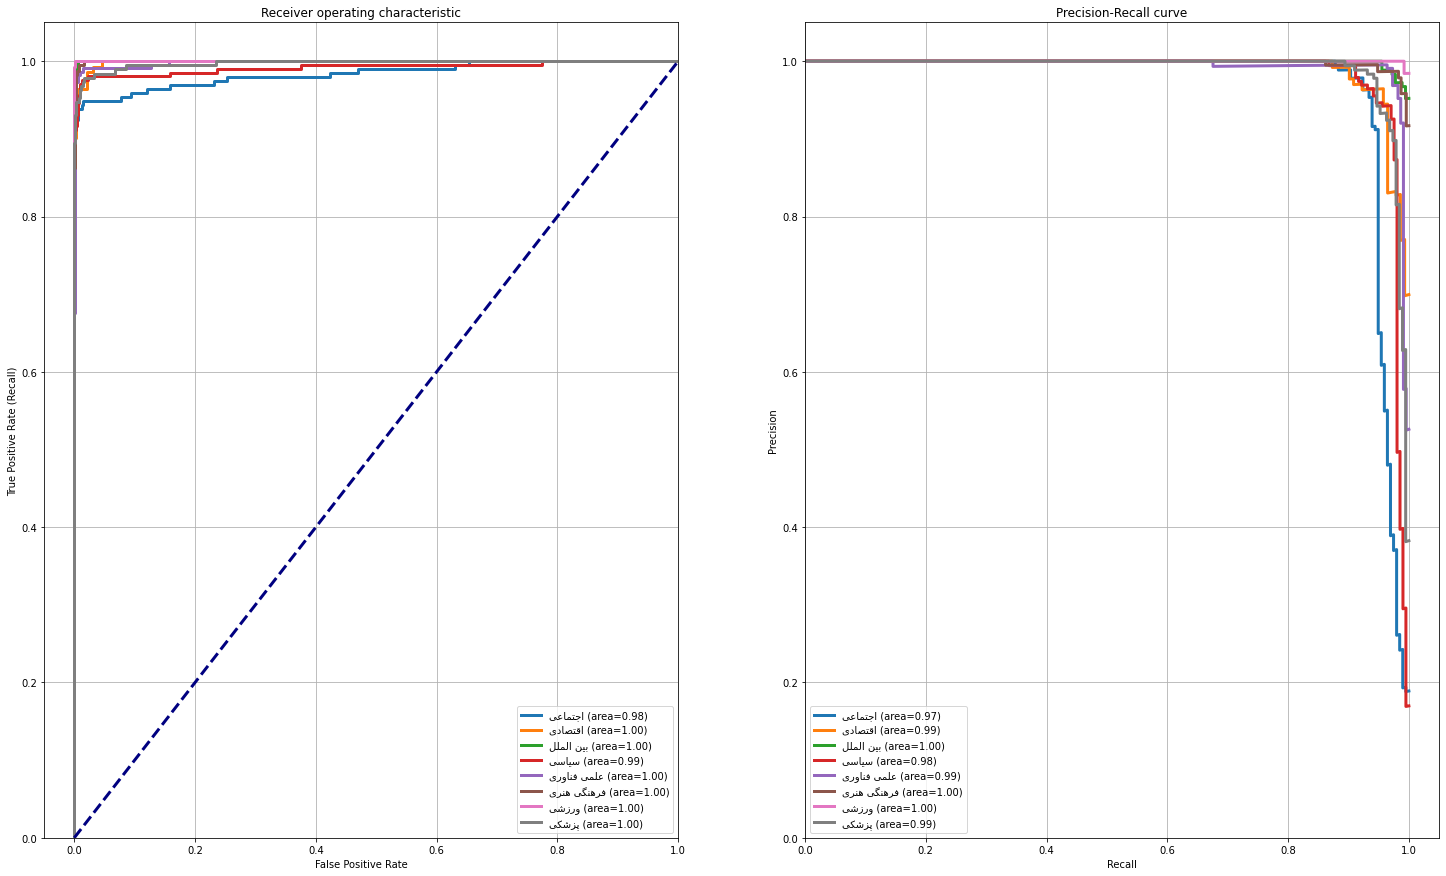

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,15))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_m[:,i],  
                           np.array(predictions)[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(per_label[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_m[:,i], np.array(predictions)[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(per_label[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## CNN_BILSTM config100-quarter on ds2

### train

In [32]:
x_train_m = x_train_m[:,:10]
x_valid_m = x_valid_m[:,:10]

In [33]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_size, weights=[word_vector_l], input_length=maxlim, trainable=True))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=10, strides=None, padding="valid"))
model.add(Dropout(0.5, seed=100))
model.add(Bidirectional(LSTM(128, activation="tanh", recurrent_activation="sigmoid", dropout=0.0, recurrent_dropout=0.0)))
model.add(Dropout(0.7, seed=100))
model.add(Dense(y_train_m.shape[1], activation='sigmoid'))

print(model.summary())
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint("/content/drive/MyDrive/best_model.h5", monitor='val_accuracy', mode='max',
                              verbose=1, save_best_only=True)

print('Training model...')
history = model.fit(x_train_m, y_train_m, epochs=50, batch_size=8,
                validation_data=(x_valid_m, y_valid_m), callbacks=[es,mc], verbose=1)

with open("/content/drive/MyDrive/history.h5", 'wb') as f2:
        pickle.dump(history.history, f2)
        f2.close()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10, 100)           7349700   
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 32)            22432     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 32)            0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 1, 32)             0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              164864    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 256)              

### predict

In [34]:
model=load_model("/content/drive/MyDrive/best_model.h5")

In [35]:
predictions=[]
prediction=[]
x_test_m = x_test_m[:,:10]
predictions=model.predict(x_test_m[:])

prediction = np.zeros_like(predictions, dtype=int)

predictions=predictions.tolist()
prediction=prediction.tolist()

for i in range(len(predictions)):
  prediction[i][predictions[i].index(max(predictions[i]))]=1

prediction = np.array(prediction)

y_test_array = y_test_m.argmax(axis=1)

per_label = []
for lb in labels:
  per_label.append(get_display(arabic_reshaper.reshape(lb)))

### Results

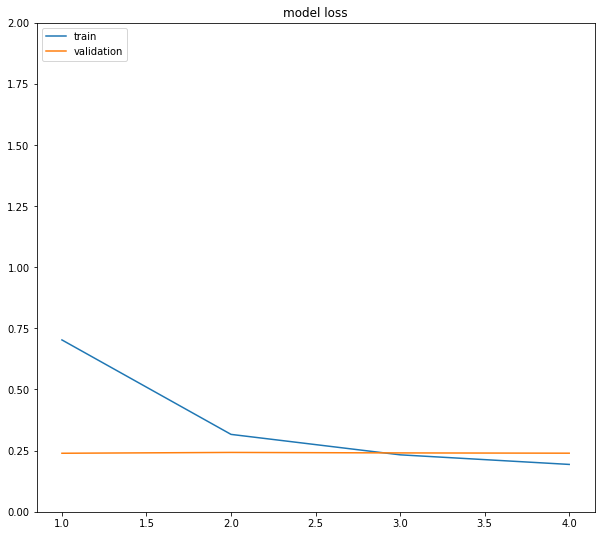

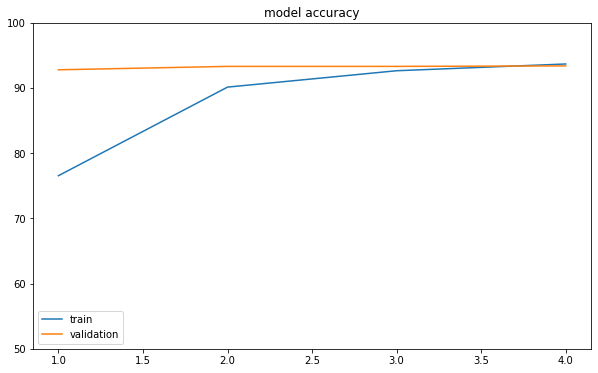

In [36]:
with open("/content/drive/MyDrive/history.h5", "rb") as f:
    hist = pickle.load(f)

# Plotting Loss and Accuracy Graphs
plt.rcParams["figure.figsize"] = (10,9)
e_arr = np.array(range(1,5))
plt.plot(e_arr, hist['loss'])
plt.plot(e_arr, hist['val_loss'])
# plt.xticks(range(1, 14))
plt.ylim(0,2)
plt.title('model loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(e_arr, np.array(hist['accuracy'])*100)
plt.plot(e_arr, np.array(hist['val_accuracy'])*100)
# plt.xticks(range(1, 4))
plt.ylim(50,100)
plt.title('model accuracy')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

In [40]:
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test_m, prediction)
auc = metrics.roc_auc_score(y_test_m, predictions, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print(f'F1: {f1_score(y_test_m, prediction, average="weighted")}')
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test_m, prediction))
  

Accuracy: 0.93
F1: 0.9260549396843716
Auc: 0.99
Detail:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       197
           1       0.89      0.93      0.91       142
           2       0.94      0.97      0.96       179
           3       0.93      0.88      0.90       204
           4       0.95      0.90      0.92       222
           5       0.96      0.94      0.95       232
           6       0.97      0.97      0.97       126
           7       0.86      0.98      0.92       189

   micro avg       0.93      0.93      0.93      1491
   macro avg       0.93      0.93      0.93      1491
weighted avg       0.93      0.93      0.93      1491
 samples avg       0.93      0.93      0.93      1491



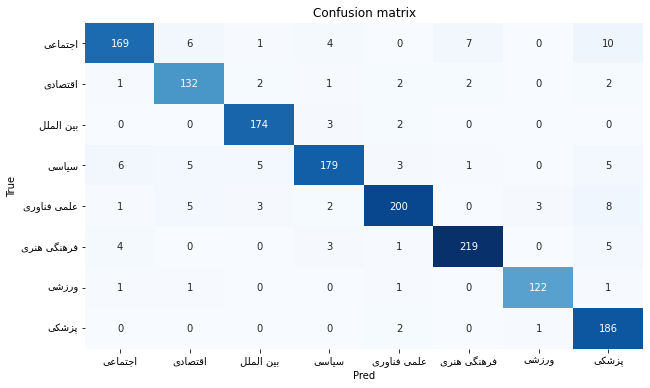

In [41]:
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_array, np.array(prediction).argmax(axis=1))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=per_label, 
       yticklabels=per_label, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

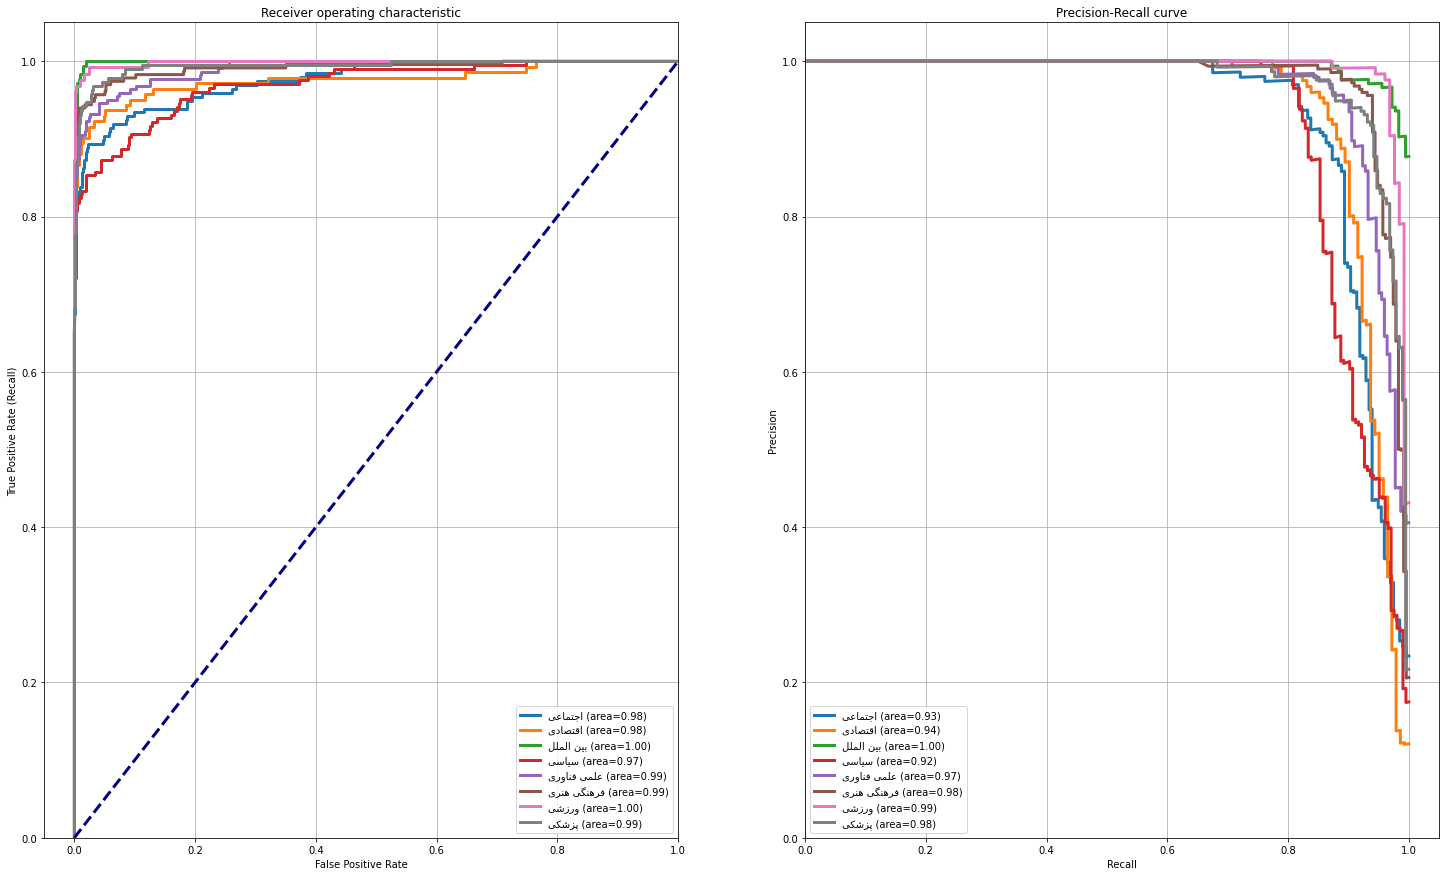

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,15))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_m[:,i],  
                           np.array(predictions)[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(per_label[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_m[:,i], np.array(predictions)[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(per_label[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## CNN_BILSTM config100-qualtel on ds2

### train

In [45]:
x_train_m = x_train_m[:,:5]
x_valid_m = x_valid_m[:,:5]

In [46]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_size, weights=[word_vector_l], input_length=maxlim, trainable=True))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=None, padding="valid"))
model.add(Dropout(0.5, seed=100))
model.add(Bidirectional(LSTM(128, activation="tanh", recurrent_activation="sigmoid", dropout=0.0, recurrent_dropout=0.0)))
model.add(Dropout(0.7, seed=100))
model.add(Dense(y_train_m.shape[1], activation='sigmoid'))

print(model.summary())
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint("/content/drive/MyDrive/best_model.h5", monitor='val_accuracy', mode='max',
                              verbose=1, save_best_only=True)

print('Training model...')
history = model.fit(x_train_m, y_train_m, epochs=50, batch_size=8,
                validation_data=(x_valid_m, y_valid_m), callbacks=[es,mc], verbose=1)

with open("/content/drive/MyDrive/history.h5", 'wb') as f2:
        pickle.dump(history.history, f2)
        f2.close()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 5, 100)            7349700   
                                                                 
 conv1d_3 (Conv1D)           (None, 5, 32)             22432     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 32)            0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 1, 32)             0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              164864    
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 256)              

### predict

In [47]:
model=load_model("/content/drive/MyDrive/best_model.h5")

In [48]:
predictions=[]
prediction=[]
x_test_m = x_test_m[:,:5]
predictions=model.predict(x_test_m[:])

prediction = np.zeros_like(predictions, dtype=int)

predictions=predictions.tolist()
prediction=prediction.tolist()

for i in range(len(predictions)):
  prediction[i][predictions[i].index(max(predictions[i]))]=1

prediction = np.array(prediction)

y_test_array = y_test_m.argmax(axis=1)

per_label = []
for lb in labels:
  per_label.append(get_display(arabic_reshaper.reshape(lb)))

### Results

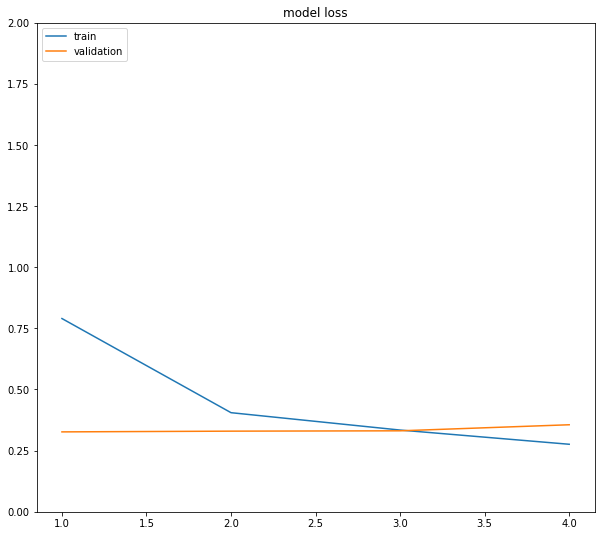

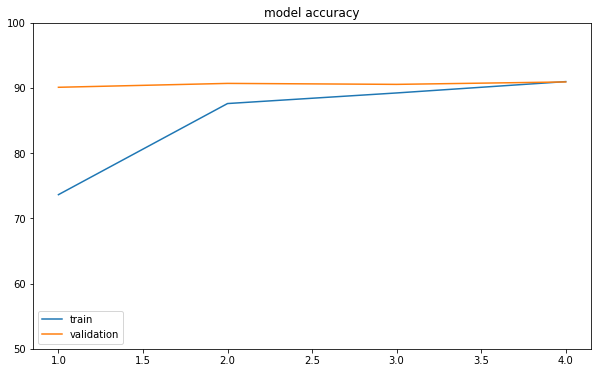

In [50]:
with open("/content/drive/MyDrive/history.h5", "rb") as f:
    hist = pickle.load(f)

# Plotting Loss and Accuracy Graphs
plt.rcParams["figure.figsize"] = (10,9)
e_arr = np.array(range(1,5))
plt.plot(e_arr, hist['loss'])
plt.plot(e_arr, hist['val_loss'])
# plt.xticks(range(1, 14))
plt.ylim(0,2)
plt.title('model loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(e_arr, np.array(hist['accuracy'])*100)
plt.plot(e_arr, np.array(hist['val_accuracy'])*100)
# plt.xticks(range(1, 4))
plt.ylim(50,100)
plt.title('model accuracy')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

In [51]:
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test_m, prediction)
auc = metrics.roc_auc_score(y_test_m, predictions, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print(f'F1: {f1_score(y_test_m, prediction, average="weighted")}')
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test_m, prediction))
  

Accuracy: 0.9
F1: 0.897872836175008
Auc: 0.98
Detail:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       197
           1       0.87      0.89      0.88       142
           2       0.96      0.96      0.96       179
           3       0.91      0.85      0.88       204
           4       0.92      0.91      0.91       222
           5       0.94      0.91      0.93       232
           6       0.94      0.92      0.93       126
           7       0.86      0.88      0.87       189

   micro avg       0.90      0.90      0.90      1491
   macro avg       0.90      0.90      0.90      1491
weighted avg       0.90      0.90      0.90      1491
 samples avg       0.90      0.90      0.90      1491



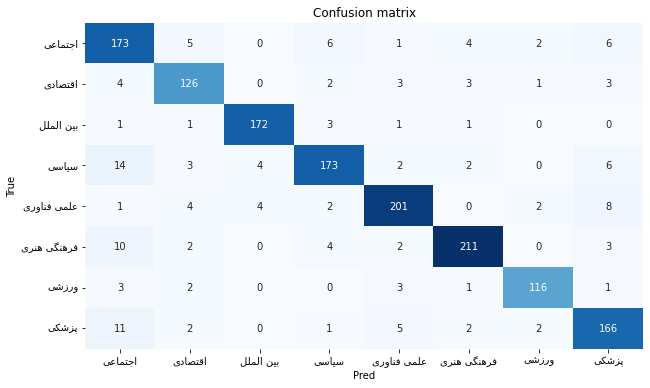

In [52]:
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_array, np.array(prediction).argmax(axis=1))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=per_label, 
       yticklabels=per_label, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

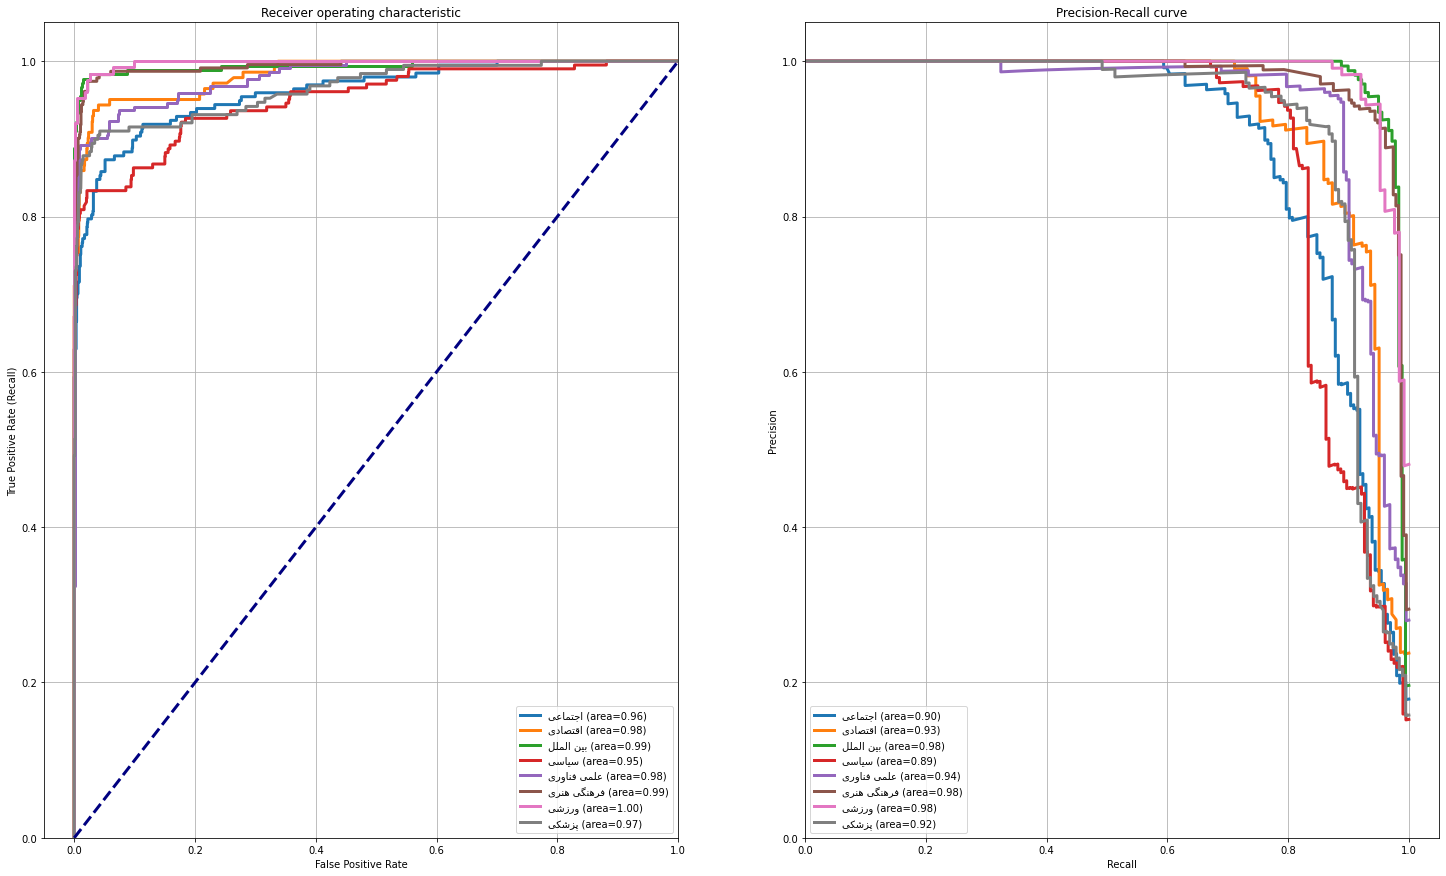

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,15))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_m[:,i],  
                           np.array(predictions)[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(per_label[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_m[:,i], np.array(predictions)[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(per_label[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## CNN_BILSTM config300 on ds2

### train

In [ ]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_size, weights=[word_vector_l], input_length=maxlim, trainable=True))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=30, strides=None, padding="valid"))
model.add(Dropout(0.5, seed=100))
model.add(Bidirectional(LSTM(128, activation="tanh", recurrent_activation="sigmoid", dropout=0.0, recurrent_dropout=0.0)))
model.add(Dropout(0.7, seed=100))
model.add(Dense(y_train_m.shape[1], activation='sigmoid'))

print(model.summary())
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint("/content/drive/MyDrive/best_model.h5", monitor='val_accuracy', mode='max',
                              verbose=1, save_best_only=True)

print('Training model...')
history = model.fit(x_train_m, y_train_m, epochs=50, batch_size=8,
                validation_data=(x_valid_m, y_valid_m), callbacks=[es,mc], verbose=1)

with open("/content/drive/MyDrive/history.h5", 'wb') as f2:
        pickle.dump(history.history, f2)
        f2.close()

Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_83 (Embedding)    (None, 512, 300)          22049100  
                                                                 
 conv1d_91 (Conv1D)          (None, 512, 32)           67232     
                                                                 
 max_pooling1d_87 (MaxPoolin  (None, 17, 32)           0         
 g1D)                                                            
                                                                 
 dropout_140 (Dropout)       (None, 17, 32)            0         
                                                                 
 bidirectional_77 (Bidirecti  (None, 256)              164864    
 onal)                                                           
                                                                 
 dropout_141 (Dropout)       (None, 256)             

### predict

In [ ]:
model=load_model("/content/drive/MyDrive/best_model.h5")

In [ ]:
predictions=[]
prediction=[]

predictions=model.predict(x_test_m[:])

prediction = np.zeros_like(predictions, dtype=int)

predictions=predictions.tolist()
prediction=prediction.tolist()

for i in range(len(predictions)):
  prediction[i][predictions[i].index(max(predictions[i]))]=1

prediction = np.array(prediction)

y_test_array = y_test_m.argmax(axis=1)

per_label = []
for lb in labels:
  per_label.append(get_display(arabic_reshaper.reshape(lb)))

### Results

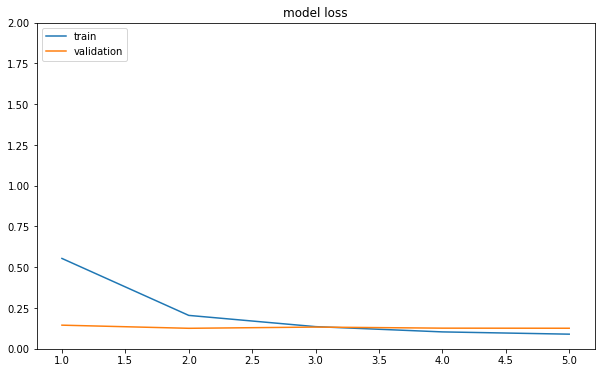

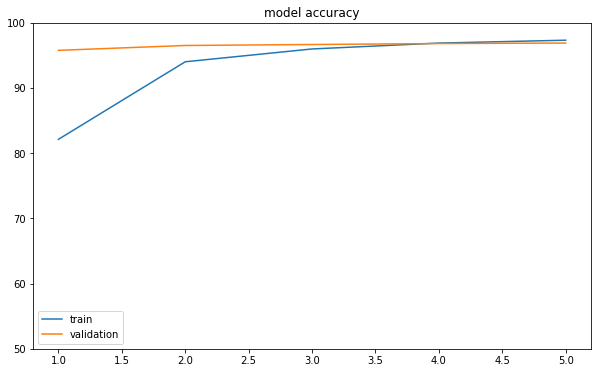

In [ ]:
with open("/content/drive/MyDrive/history.h5", "rb") as f:
    hist = pickle.load(f)

# Plotting Loss and Accuracy Graphs
plt.rcParams["figure.figsize"] = (10,6)
e_arr = np.array(range(1,6))
plt.plot(e_arr, hist['loss'])
plt.plot(e_arr, hist['val_loss'])
# plt.xticks(range(1, 14))
plt.ylim(0,2)
plt.title('model loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(e_arr, np.array(hist['accuracy'])*100)
plt.plot(e_arr, np.array(hist['val_accuracy'])*100)
# plt.xticks(range(1, 4))
plt.ylim(50,100)
plt.title('model accuracy')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

In [ ]:
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test_m, prediction)
auc = metrics.roc_auc_score(y_test_m, predictions, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print(f'F1: {f1_score(y_test_m, prediction, average="weighted")}')
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test_m, prediction))
  

Accuracy: 0.96
F1: 0.9630057649016093
Auc: 1.0
Detail:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       197
           1       0.93      0.95      0.94       142
           2       0.97      0.99      0.98       179
           3       0.98      0.91      0.94       204
           4       0.97      0.98      0.98       222
           5       0.98      0.97      0.98       232
           6       0.98      0.98      0.98       126
           7       0.95      0.98      0.97       189

   micro avg       0.96      0.96      0.96      1491
   macro avg       0.96      0.96      0.96      1491
weighted avg       0.96      0.96      0.96      1491
 samples avg       0.96      0.96      0.96      1491



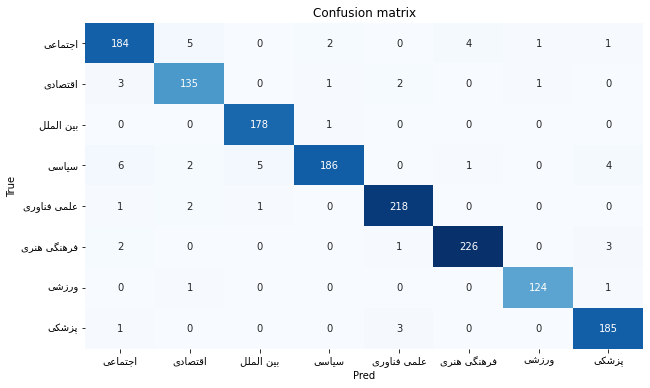

In [ ]:
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_array, np.array(prediction).argmax(axis=1))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=per_label, 
       yticklabels=per_label, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

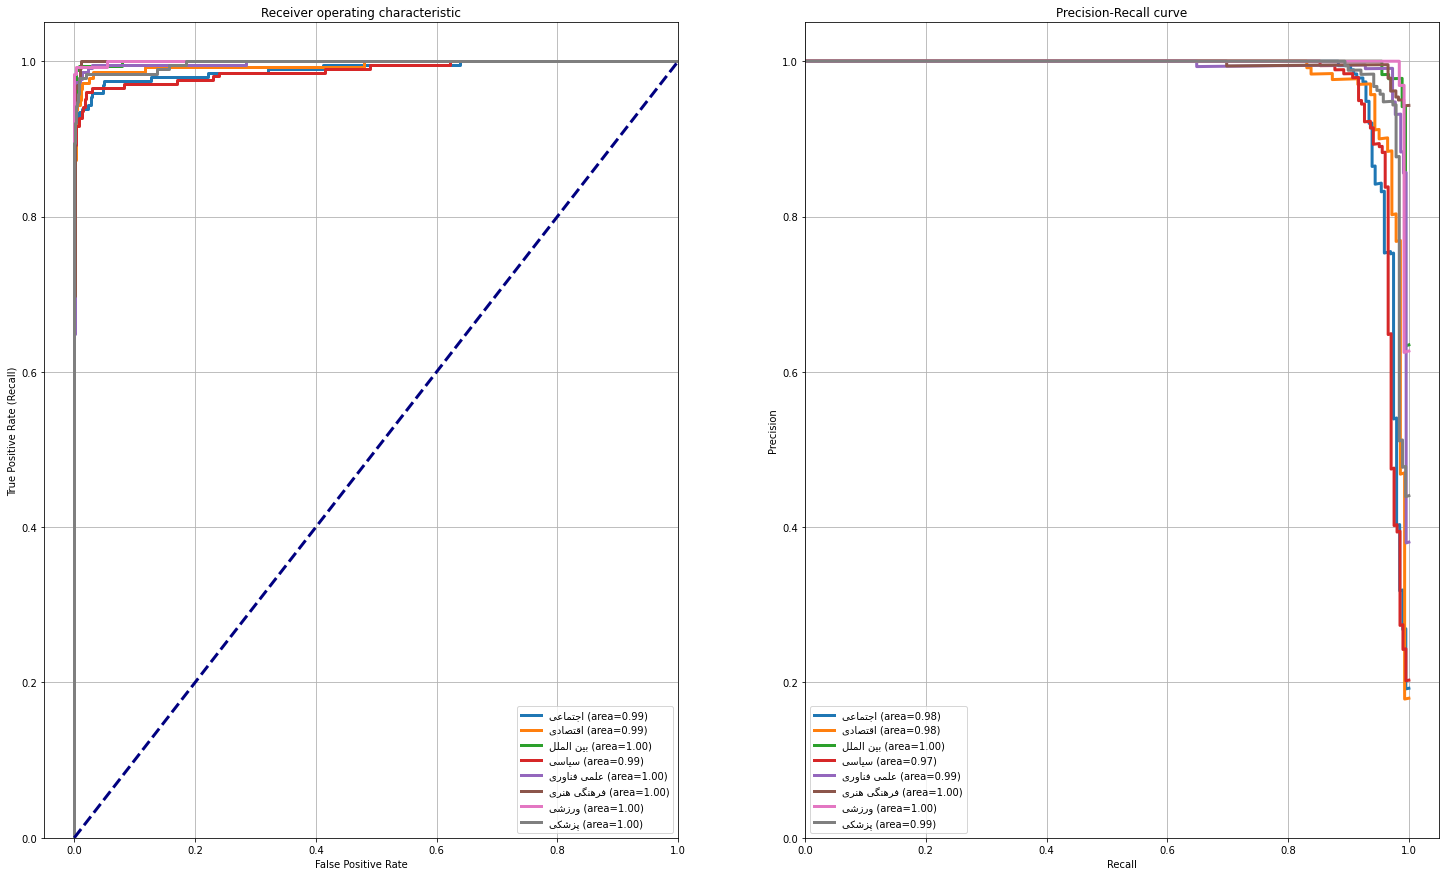

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,15))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_m[:,i],  
                           np.array(predictions)[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(per_label[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_m[:,i], np.array(predictions)[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(per_label[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## CNN_BILSTM config300-quarter on ds2

### train

In [55]:
x_train_m = x_train_m[:,:10]
x_valid_m = x_valid_m[:,:10]

In [56]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_size, weights=[word_vector_l], input_length=maxlim, trainable=True))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=10, strides=None, padding="valid"))
model.add(Dropout(0.5, seed=100))
model.add(Bidirectional(LSTM(128, activation="tanh", recurrent_activation="sigmoid", dropout=0.0, recurrent_dropout=0.0)))
model.add(Dropout(0.7, seed=100))
model.add(Dense(y_train_m.shape[1], activation='sigmoid'))

print(model.summary())
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint("/content/drive/MyDrive/best_model.h5", monitor='val_accuracy', mode='max',
                              verbose=1, save_best_only=True)

print('Training model...')
history = model.fit(x_train_m, y_train_m, epochs=50, batch_size=8,
                validation_data=(x_valid_m, y_valid_m), callbacks=[es,mc], verbose=1)

with open("/content/drive/MyDrive/history.h5", 'wb') as f2:
        pickle.dump(history.history, f2)
        f2.close()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 10, 300)           22049100  
                                                                 
 conv1d_4 (Conv1D)           (None, 10, 32)            67232     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1, 32)            0         
 1D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 1, 32)             0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 256)              164864    
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 256)              

### predict

In [57]:
model=load_model("/content/drive/MyDrive/best_model.h5")

In [58]:
predictions=[]
prediction=[]
x_test_m = x_test_m[:,:10]
predictions=model.predict(x_test_m[:])

prediction = np.zeros_like(predictions, dtype=int)

predictions=predictions.tolist()
prediction=prediction.tolist()

for i in range(len(predictions)):
  prediction[i][predictions[i].index(max(predictions[i]))]=1

prediction = np.array(prediction)

y_test_array = y_test_m.argmax(axis=1)

per_label = []
for lb in labels:
  per_label.append(get_display(arabic_reshaper.reshape(lb)))

### Results

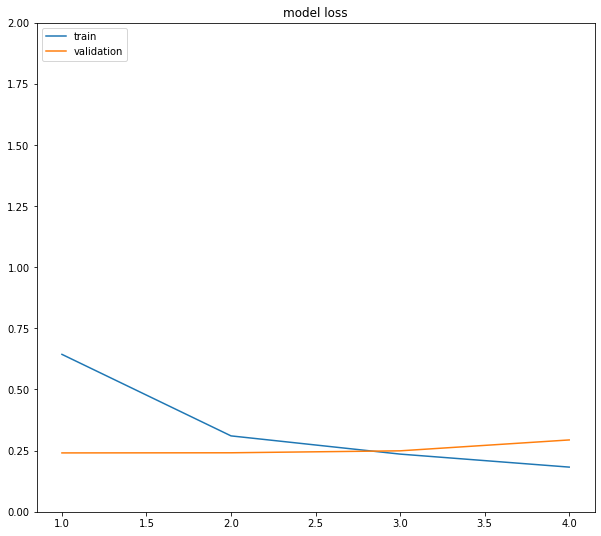

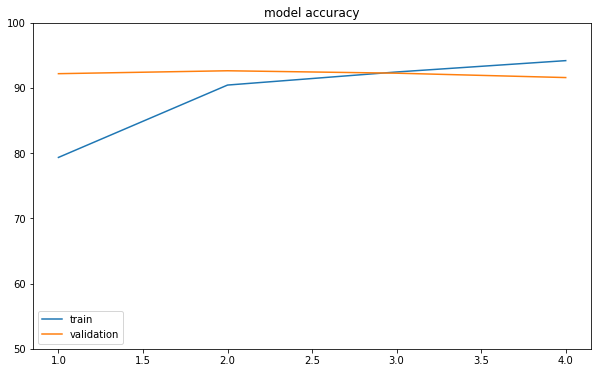

In [59]:
with open("/content/drive/MyDrive/history.h5", "rb") as f:
    hist = pickle.load(f)

# Plotting Loss and Accuracy Graphs
plt.rcParams["figure.figsize"] = (10,9)
e_arr = np.array(range(1,5))
plt.plot(e_arr, hist['loss'])
plt.plot(e_arr, hist['val_loss'])
# plt.xticks(range(1, 14))
plt.ylim(0,2)
plt.title('model loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(e_arr, np.array(hist['accuracy'])*100)
plt.plot(e_arr, np.array(hist['val_accuracy'])*100)
# plt.xticks(range(1, 4))
plt.ylim(50,100)
plt.title('model accuracy')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

In [60]:
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test_m, prediction)
auc = metrics.roc_auc_score(y_test_m, predictions, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print(f'F1: {f1_score(y_test_m, prediction, average="weighted")}')
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test_m, prediction))
  

Accuracy: 0.92
F1: 0.9217416486227403
Auc: 0.98
Detail:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       197
           1       0.84      0.91      0.87       142
           2       0.97      0.97      0.97       179
           3       0.91      0.89      0.90       204
           4       0.92      0.91      0.92       222
           5       0.94      0.95      0.95       232
           6       0.98      0.96      0.97       126
           7       0.94      0.90      0.92       189

   micro avg       0.92      0.92      0.92      1491
   macro avg       0.92      0.92      0.92      1491
weighted avg       0.92      0.92      0.92      1491
 samples avg       0.92      0.92      0.92      1491



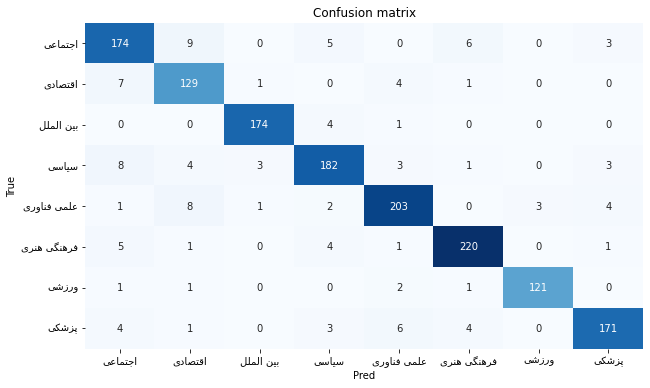

In [61]:
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_array, np.array(prediction).argmax(axis=1))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=per_label, 
       yticklabels=per_label, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

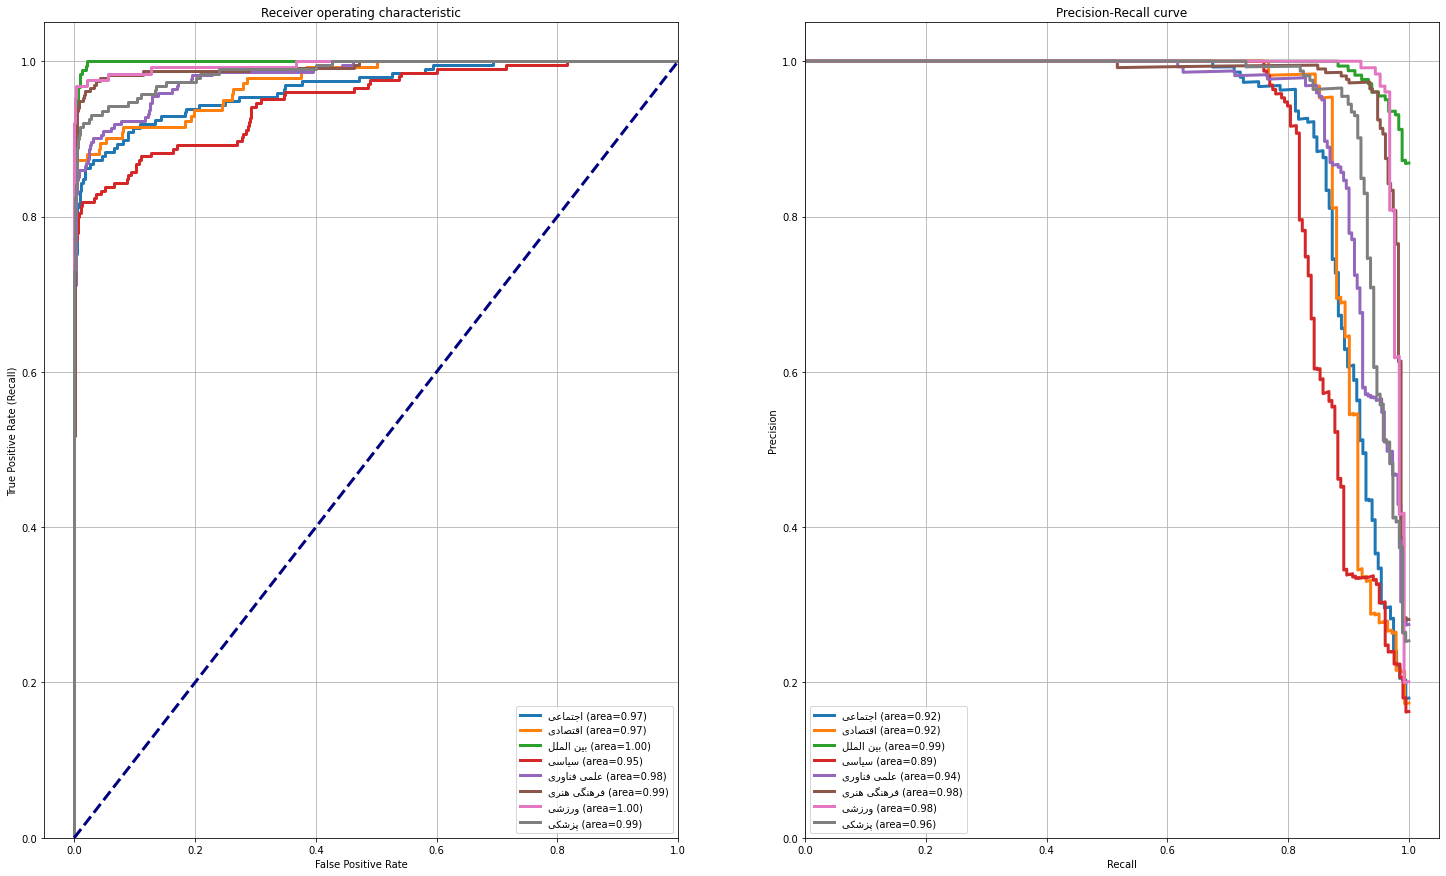

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,15))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_m[:,i],  
                           np.array(predictions)[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(per_label[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_m[:,i], np.array(predictions)[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(per_label[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## CNN_BILSTM config300-qualtel on ds2

### train

In [65]:
x_train_m = x_train_m[:,:5]
x_valid_m = x_valid_m[:,:5]

In [66]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_size, weights=[word_vector_l], input_length=maxlim, trainable=True))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=None, padding="valid"))
model.add(Dropout(0.5, seed=100))
model.add(Bidirectional(LSTM(128, activation="tanh", recurrent_activation="sigmoid", dropout=0.0, recurrent_dropout=0.0)))
model.add(Dropout(0.7, seed=100))
model.add(Dense(y_train_m.shape[1], activation='sigmoid'))

print(model.summary())
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint("/content/drive/MyDrive/best_model.h5", monitor='val_accuracy', mode='max',
                              verbose=1, save_best_only=True)

print('Training model...')
history = model.fit(x_train_m, y_train_m, epochs=50, batch_size=8,
                validation_data=(x_valid_m, y_valid_m), callbacks=[es,mc], verbose=1)

with open("/content/drive/MyDrive/history.h5", 'wb') as f2:
        pickle.dump(history.history, f2)
        f2.close()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 5, 300)            22049100  
                                                                 
 conv1d_5 (Conv1D)           (None, 5, 32)             67232     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1, 32)            0         
 1D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 1, 32)             0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              164864    
 nal)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 256)              

### predict

In [67]:
model=load_model("/content/drive/MyDrive/best_model.h5")

In [68]:
predictions=[]
prediction=[]
x_test_m = x_test_m[:,:5]
predictions=model.predict(x_test_m[:])

prediction = np.zeros_like(predictions, dtype=int)

predictions=predictions.tolist()
prediction=prediction.tolist()

for i in range(len(predictions)):
  prediction[i][predictions[i].index(max(predictions[i]))]=1

prediction = np.array(prediction)

y_test_array = y_test_m.argmax(axis=1)

per_label = []
for lb in labels:
  per_label.append(get_display(arabic_reshaper.reshape(lb)))

### Results

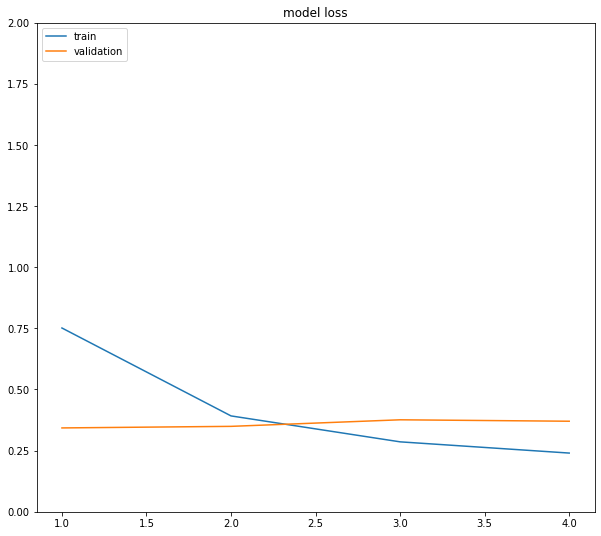

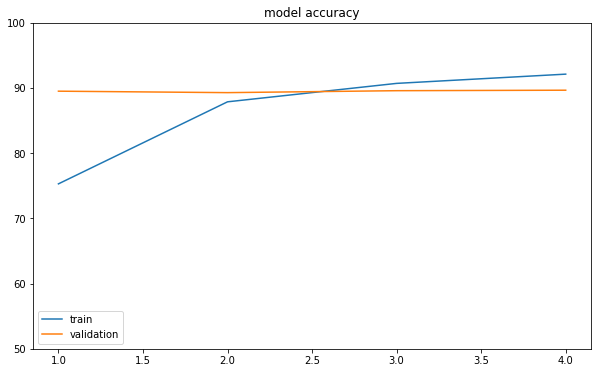

In [69]:
with open("/content/drive/MyDrive/history.h5", "rb") as f:
    hist = pickle.load(f)

# Plotting Loss and Accuracy Graphs
plt.rcParams["figure.figsize"] = (10,9)
e_arr = np.array(range(1,5))
plt.plot(e_arr, hist['loss'])
plt.plot(e_arr, hist['val_loss'])
# plt.xticks(range(1, 14))
plt.ylim(0,2)
plt.title('model loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(e_arr, np.array(hist['accuracy'])*100)
plt.plot(e_arr, np.array(hist['val_accuracy'])*100)
# plt.xticks(range(1, 4))
plt.ylim(50,100)
plt.title('model accuracy')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

In [70]:
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test_m, prediction)
auc = metrics.roc_auc_score(y_test_m, predictions, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print(f'F1: {f1_score(y_test_m, prediction, average="weighted")}')
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test_m, prediction))
  

Accuracy: 0.89
F1: 0.888010569338224
Auc: 0.98
Detail:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       197
           1       0.84      0.86      0.85       142
           2       0.94      0.95      0.95       179
           3       0.85      0.88      0.87       204
           4       0.91      0.89      0.90       222
           5       0.93      0.91      0.92       232
           6       0.93      0.93      0.93       126
           7       0.86      0.88      0.87       189

   micro avg       0.89      0.89      0.89      1491
   macro avg       0.89      0.89      0.89      1491
weighted avg       0.89      0.89      0.89      1491
 samples avg       0.89      0.89      0.89      1491



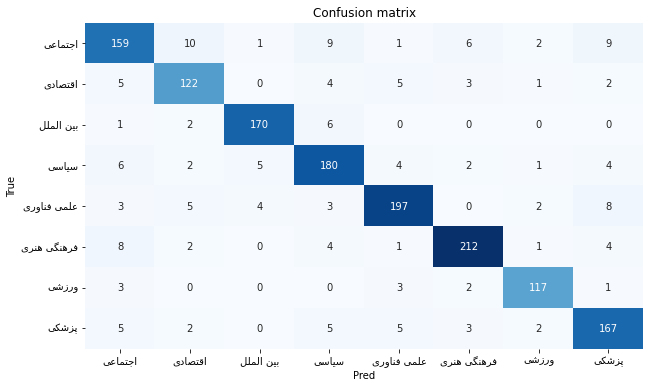

In [71]:
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_array, np.array(prediction).argmax(axis=1))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=per_label, 
       yticklabels=per_label, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

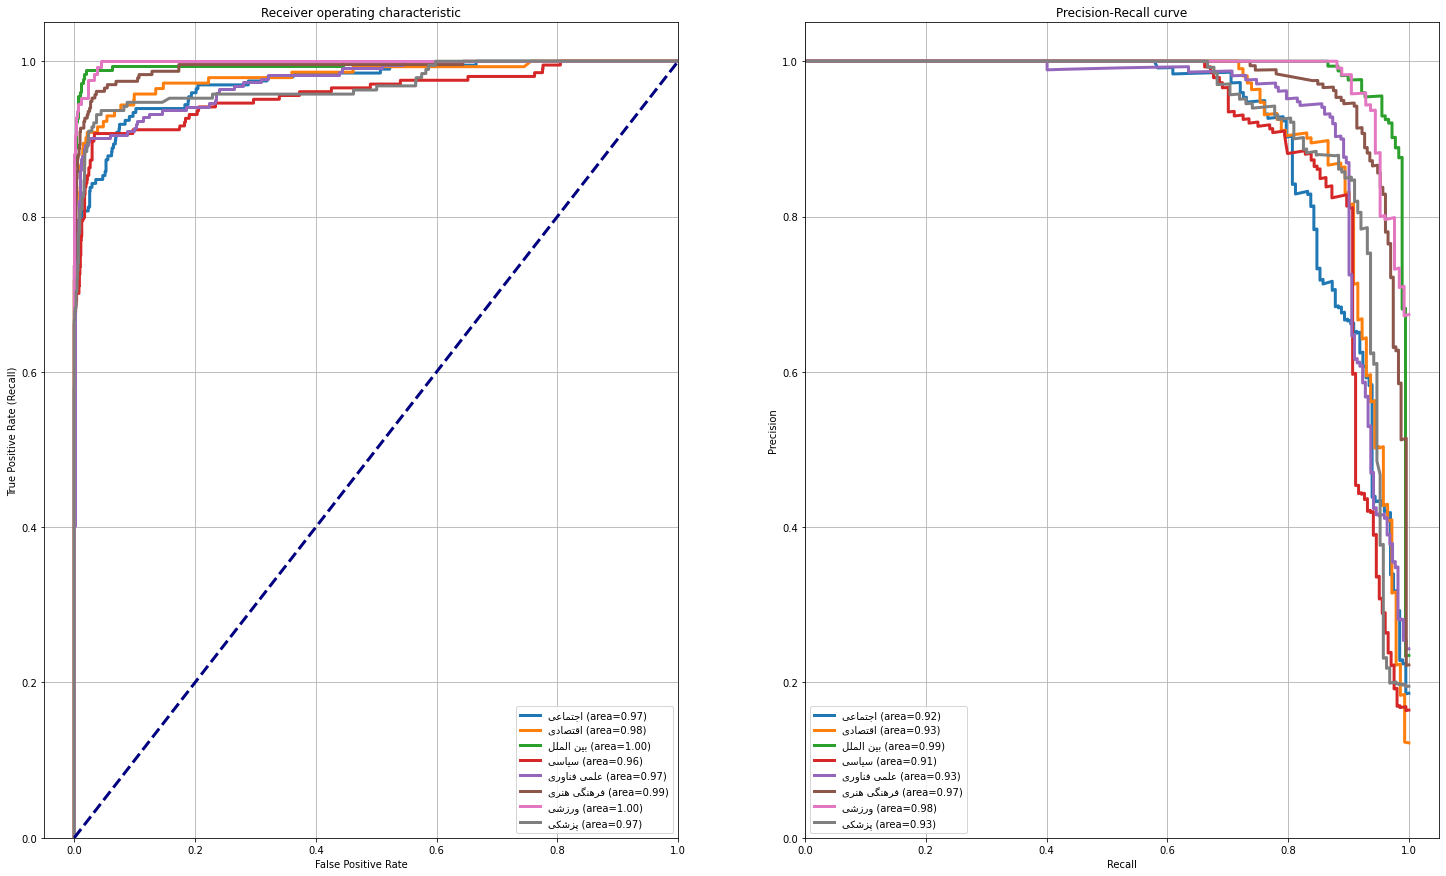

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,15))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_m[:,i],  
                           np.array(predictions)[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(per_label[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_m[:,i], np.array(predictions)[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(per_label[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()